In [212]:
from __future__ import division
import matplotlib.pyplot as plt
from functools import reduce 
from scipy import stats
import pandas as pd
import seaborn as sns
import networkx as nx
import numpy as np
import os
from datetime import datetime,timedelta
from time import time
from timezonefinder import TimezoneFinder
from pytz import timezone
from collections import deque
pd.set_option('display.max_columns', 30)
#from google.colab import files
# http://stat-computing.org/dataexpo/2009/the-data.html

In [385]:
def fun_1_simplify_step_1(data, simplify=True):
    if simplify:
        print('number of data:',len(data))
        data = data[data['Cancelled'] == 0]
        print('number of data after drop cancelled:',len(data))

        data = data[~data['ArrTime'].isnull()]
        print('number of data after drop no ArrTime:',len(data))

        data = data[~data['AirTime'].isnull()]
        print('number of data after drop no AirTime:',len(data))

        iters=data.groupby(['Origin','Dest']).groups.keys()
        one_ways=[(x,y) for x,y in  iters if (y,x) not in iters]
        #print(len(one_ways))
        if one_ways:
            data=data[~reduce(lambda x,y:x|y, [(data.Origin==x)&(data.Dest==y) for x,y in one_ways]) ]
        print('number of data after drop one way trips:',len(data))
        
        columns=['DepTime',	'CRSDepTime',	'ArrTime',	'CRSArrTime',		'ActualElapsedTime',	'CRSElapsedTime',	'AirTime',	'ArrDelay',	'DepDelay',	'Distance',	'TaxiIn',	'TaxiOut']
        for col in columns:
            data[col]=data[col].astype(int)
        print('modify all numerical data to be integer')
        #data.apply(pd.to_numeric,errors='ignore')
    else:
        print('data is not simplified')
    return data

def fun_1_to_three_tuple(df):
    A={}
    A['Distance']=df['Distance']
    A['weight']=df['TotalNumber']
    dt=datetime(year=df['Year'],month=df['Month'],day=df['DayofMonth'],hour=df['CRSArrTime']//100,minute=df['CRSArrTime']%100)
    dt-=datetime(year=df['Year'],month=df['Month'],day=df['DayofMonth'],hour=df['CRSDepTime']//100,minute=df['CRSDepTime']%100)
    #under assumption that the flight speed is smaller than the speed of roation of earth
    if dt<timedelta():
        dt+=timedelta(days=1)

    dt-=timedelta(seconds=df['CRSElapsedTime']*60)
    A['RelTime']=dt
    #print(df['Origin'],df['Dest'],dt)
    return (df['Origin'],df['Dest'],A)

def fun_1_to_nodes_dict(G,airports):
    airports=airports.set_index(airports.iata.values)
    tf = TimezoneFinder()
    A={node:{'pos':(airports.loc[node].long,airports.loc[node].lat),
             'time_zone':tf.timezone_at(lng=airports.loc[node].long, lat=airports.loc[node].lat)} for node in G.nodes }
    return A

def fun_1_network_build(data,airports):
    temp=data.groupby(['Origin','Dest'],as_index=False).first()
    temp['TotalNumber']=data.groupby(['Origin','Dest'],as_index=False)['FlightNum'].count().FlightNum
    #temp['RelTime']=temp.apply(fun_1_to_three_tuple,axis=1)[2]['RelTime']
    temp.describe()
    G=nx.DiGraph()
    G.add_edges_from(temp.apply(fun_1_to_three_tuple,axis=1))
    nx.set_node_attributes(G,fun_1_to_nodes_dict(G,airports))
    return G,temp
def fun_1_draw_network(G):
    plt.figure(1,figsize=(12,12)) 
    nx.draw(G.to_undirected(),pos=nx.get_node_attributes(G,'pos'),with_labels=True)
    plt.show()

def fun_1_abstime(G,source):
    A=dict(nx.bfs_successors(G, source=source))
    G.nodes[source]['TimeModifyer']=timedelta()
    # TimeModifyer term has following property: arr+arr_timemod=dep+dep_timemod+elaps
    # rel has property: rel=arr-dep-elaps
    # thus arr_timemod=dep_timemod-rel
    
    def fun_1_BFS(tree,origin):
        if origin not in tree:
            return
        else:
            for dest in A[origin]:
                G.nodes[dest]['TimeModifyer']=G.nodes[origin]['TimeModifyer']-G.edges[(origin,dest)]['RelTime']
                fun_1_BFS(tree,dest)

    fun_1_BFS(A,source)  

def fun_1_draw_network_nodes_attr(G,attr='TimeModifyer',size=10):
    plt.figure(1,figsize=(size,size))
    if attr == 'TimeModifyer':
        labels={node:value.total_seconds()/3600 for node,value in nx.get_node_attributes(G,attr).items()}
    elif attr=='time_zone':
        labels={node:value.split('/')[1] for node,value in nx.get_node_attributes(G,attr).items()}
    else:
        raise  
    #print(labels)
    pos=nx.get_node_attributes(G,'pos')
    nx.draw(G.to_undirected(),pos=pos,labels=labels)
    plt.show()
    
def fun1_timeseries_check(data):# check correctness for fun_1_ts_pre_gen
    temp=data[~data.apply(lambda x: abs(x.AbsDepTime+timedelta(minutes=x.AirTime+x.TaxiIn+x.TaxiOut)-x.AbsArrTime)<
                          timedelta(seconds = 120),axis=1)]
    print ('data with wrong abs time: ',len(temp), 'and error ratio:', len(temp)/len(data))
    print(temp.head())
    return temp


def fun_1_ts_pre_gen(data,G):
    columns=['Year',	'Month',	'DayofMonth','DepTime',	'ArrTime','ArrDelay','DepDelay','Origin',	'Dest','AirTime','TaxiIn','TaxiOut'	]
    data=data[columns]
    data_c=data.copy()
    t=time()
    AbsDepTime_gen=fun_1_functional(G,'Dep')
    data_c['AbsDepTime']=data.apply(AbsDepTime_gen,axis=1)
    print('++++++++++++++++++++++++  ts pre gen is half way:',time()-t,' ++++++++++++++++++++++++')
    AbsArrTime_gen=fun_1_functional(G,'Arr')
    data_c['AbsArrTime']=data.apply(AbsArrTime_gen,axis=1)
    print('++++++++++++++++++++++++  ts pre gen is almost done :',time()-t,' ++++++++++++++++++++++++')

    return data_c
  
def fun_1_functional(G,attr):#attr = 'Dep' or 'Arr'
    LAX_tz = timezone('America/Los_Angeles')
    def abstime_dep(df):
        hour_24_mod=timedelta()
        next_day_mod=timedelta()
        if attr=='Dep':
            hour=df[attr+'Time']//100
            minute=df[attr+'Time']%100
            tz=timezone(G.nodes[df['Origin']]['time_zone'])
        if attr=='Arr':
            hour=df[attr+'Time']//100
            minute=df[attr+'Time']%100
            tz=timezone(G.nodes[df['Dest']]['time_zone'])
            if int(df.ArrTime)+1200<int(df.DepTime):
                next_day_mod=timedelta(days=1)
                
        if hour>=24:
            if hour==24:
                hour_24_mod=timedelta(days=1)
                hour = 0
            else:
                print(df)
                raise
        dt=datetime(year=df['Year'],month=df['Month'],day=df['DayofMonth'],hour = hour,minute = minute)+hour_24_mod+next_day_mod
        loc_dt=tz.localize(dt).astimezone(LAX_tz)       
        return loc_dt
    return abstime_dep

def fun_1_ts_gen(data,G,airport,verbose=False):
    t=time()
    depdf=data.sort_values(by='AbsDepTime').groupby('Origin').get_group(airport).reset_index().set_index('AbsDepTime').rename_axis(None)
    depdf['Leaving']=[True]*len(depdf)
    print('AbsDepTime columnn generated:',time()-t)
    
    arrdf=data.sort_values(by='AbsArrTime').groupby('Dest').get_group(airport).reset_index().set_index('AbsArrTime').rename_axis(None)
    arrdf['Leaving']=[False]*len(arrdf)
    print('AbsArrTime columnn generated:',time()-t)
    
    res=pd.concat([depdf,arrdf],sort=False).sort_index(axis = 0)
    print('data concated:',time()-t)
    
    if not verbose:
        columns=[ 'Year',  'Month',  'DayofMonth' , 'AirTime' , 'TaxiIn' , 'TaxiOut']
        print('fun_1_ts_gen ended:',time()-t)
        return res.drop(columns=columns)
    print('fun_1_ts_gen ended:',time()-t)
    return res

def fun_1_delay_rate(airport,grid,dt,pre_data,G):
    t=time()
    #pre_data=pd.read_csv("Data/pre_timeseries.csv")
    print('loading finished:' ,time()-t)
    t=time()
    
    data=fun_1_ts_gen(pre_data,G,airport)
    
    delay_data=data[(data.ArrDelay>15) | (data.DepDelay>15)]

    total_series=fun_1_counter(pd.to_datetime(data.index),grid,dt).rename('TotalFlights')
    
    if delay_data.empty:
        print('delay_data is empty')
        delay_series=pd.Series(data=[0]*len(grid),index=grid,name='DelayFlights')
    else:
        delay_series=fun_1_counter(pd.to_datetime(delay_data.index),grid,dt).rename('DelayFlights')
    
    res=pd.concat([total_series,delay_series],axis=1)
    
    res['DelayRatio']=res.apply(lambda x: x.DelayFlights/x.TotalFlights,axis=1)
   
    return  res

def fun_1_counter(ts_raw_data,grid,dt):# covolution of delta)[t,t+dt) for t in grid
    t=time()
    if ts_raw_data.empty:
        raise
    if grid.empty:
        raise
#     if (ts_raw_data[0]>grid[0]) | (ts_raw_data[-1]<(grid[-1]+dt)):
#         print('time grid out of range')
#         print('ts_raw_data[0]: ',ts_raw_data[0])
#         print('grid[0]: ',grid[0])
#         print('ts_raw_data[-1]: ',ts_raw_data[-1])
#         print('grid[-1]: ',grid[-1])
#         print('dt: ',dt)
        
#         raise
#     print("checking validity:",time()-t)
    
#     t=time()
#     for i in range(len(ts_raw_data)):
#        if ts_raw_data[i]>=grid[0]:
#           r_idx=i
#           break
#     print("set starting timestamp:",time()-t)
    t=time()
    covolution=[]
    interval=deque()
    r_idx=0
    for ts in grid:
        while r_idx<len(ts_raw_data) and ts_raw_data[r_idx]<ts+dt :
            interval.append(ts_raw_data[r_idx])
            #print('append',ts_raw_data[r_idx])
            r_idx+=1
        
        while interval and interval[0]< ts+dt-pd.to_timedelta(grid.freq):
        #print('pop:',interval.popleft())
            interval.popleft()
        #print(interval)
        covolution.append(len(interval))
    return pd.Series(covolution,index=grid)

def fun_2_pre_data_gen(years,sample_airports=[]):
    t=time()
    trips=[pd.read_csv('Data/trip/'+str(year)+'.csv') for year in years]# little bit slow 30 seconds
    trips_all=pd.concat(trips,ignore_index=True)
    
    if sample_airports:
        trips_all=trips_all[(trips_all['Origin'].isin(sample_airports)) & (trips_all['Dest'].isin( sample_airports))].copy()
        print('+++++++++++++++++++sample airports has set:',time()-t,' +++++++++++++++++++++++++++++++++++++++++')
    
    airports  = pd.read_csv('Data/airports.csv').query("country == 'USA'")
    trips_all = fun_1_simplify_step_1(trips_all)# little bit slow, approximate 3 min on colab
    print('+++++++++++++++++++data has been simplified:',time()-t,' +++++++++++++++++++++++++++++++++++++++++')
    G_all,data_G_all=fun_1_network_build(trips_all,airports)
    #fun_1_abstime(G_all,'LAX')#  slow, ~ 15 min on colab ~8min on local
    print('+++++++++++++++++++generating deault pre_data:',time()-t,' +++++++++++++++++++++++++++++++++++++++++')
    pre_data=fun_1_ts_pre_gen(trips_all,G_all)
    print('+++++++++++++++++++pre_data has generated :' ,time()-t,'+++++++++++++++++++++++++++++++++++++++++')
    
    data_error=fun1_timeseries_check(pre_data.sample(len(pre_data)//100))
    print('++++++++++++++++++++++++  ts pre gen finished checking :',time()-t,' ++++++++++++++++++++++++')
    
    print('++++++++++++++++++++++++++global variables initialized:',time()-t,'+++++++++++++++++++++++++++++++++++')
    return pre_data,G_all,airports,data_G_all,data_error

def fun_25_datasets_gen(G,attr,grid,dt,pre_data,number_index=False,
                        airport2idx=dict(),time_stamp2idx=dict(),idx2airport=dict(),idx2time_stamp=dict()):
    
    t=time()
    counter=0
    dfs=[]
    
    if (len(airport2idx)>0) & (len(time_stamp2idx)>0) & (len(idx2airport)>0) & (len(idx2time_stamp)>0) :
        for airport in G.nodes:
            print("=========Testing ",airport,"==========airports remains :", len(G.nodes)-counter,'========time lasted so far: ',time()-t)
            temp=fun_1_delay_rate(airport,grid=grid,dt=dt,pre_data=pre_data,G=G)[attr]
            #temp.index=temp.reset_index().apply(lambda x: time_stamp2idx[x['index']], axis=1)
            temp.index=map(lambda x: time_stamp2idx[x], temp.index)
            temp.name=airport2idx[airport]
            counter+=1
            dfs.append(temp)
        ans=pd.concat(dfs,axis=1).sort_index(axis=1)
        
        if not number_index:
            ans.index=map(lambda x: idx2time_stamp[x], ans.index)
            ans.columns=map(lambda x: idx2airport[x], ans.columns)
            
            
        print('======================Total time:',time()-t)
        return ans.transpose()
    else:
        print('At least one dict is empty')
        print(len(airport2idx) ,len(time_stamp2idx) ,len(idx2airport) ,len(idx2time_stamp))
        raise
        return

    
def fun_1_draw_network_attr(G,nodes_attr= None,edges_attr='weight',size=10,with_pos=True):
    plt.figure(1,figsize=(size,size))
    if nodes_attr == 'TimeModifyer':
        labels={node:value.total_seconds()/3600 for node,value in nx.get_node_attributes(G,nodes_attr).items()}
    elif nodes_attr =='time_zone':
        labels={node:value.split('/')[1] for node,value in nx.get_node_attributes(G,nodes_attr).items()}
    elif nodes_attr is None:
        labels=None
    else:
        raise  
    #print(labels)
    pos=nx.get_node_attributes(G,'pos')
    if not with_pos:
        pos=nx.spring_layout(G)
    nx.draw(G,pos=pos,labels = labels)
    nx.draw_networkx_edge_labels(G,pos=pos,edge_labels=nx.get_edge_attributes(G,edges_attr))
    plt.show()
    

#export_data
def fun25_export_data_sets(grid,dt,G,pre_data):
    idx2airport={x:y for x,y in enumerate(sorted(G.nodes))}
    pd.Series(idx2airport).to_csv('idx2airport'+'.csv',header=True)
    
    airport2idx={y:x for x,y in enumerate(sorted(G.nodes))}
    pd.Series(airport2idx).to_csv('airport2idx'+'.csv',header=True)
    
    idx2time_stamp={x:y for x,y in enumerate(grid)}
    pd.Series(idx2time_stamp).to_csv('idx2time_stamp'+'.csv',header=True)
    
    time_stamp2idx={y:x for x,y in enumerate(grid)}
    pd.Series(time_stamp2idx).to_csv('time_stamp2idx'+'.csv',header=True)
    
    dt=dt
    attrs=['TotalFlights','DelayFlights']
    for attr in attrs:
        fun_25_datasets_gen(G=G,attr=attr,grid=grid,dt=dt,pre_data=pre_data,
                    number_index=True,airport2idx=airport2idx,time_stamp2idx=time_stamp2idx,
                             idx2airport=idx2airport,idx2time_stamp=idx2time_stamp).to_csv(attr+'.csv')
    TotalFlights=pd.read_csv("TotalFlights.csv",index_col=0)
    DelayFlights=pd.read_csv("DelayFlights.csv",index_col=0)
    pd.DataFrame(data=DelayFlights.values/TotalFlights.values,index=DelayFlights.index,
                 columns=DelayFlights.columns).to_csv('DelayRatio.csv')
    
    pre_data.to_csv('pre_data'+'.csv')
    nx.to_pandas_edgelist(G).to_csv('graph_edges'+'.csv')
    pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index').to_csv('graph_nodes'+'.csv')
    
    return

def fun_1_nework_build_with_pre_data(st_abstime_str,end_abstime_str,pre_data,G):
    
    st_abstime = datetime.strptime(st_abstime_str,'%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone('America/Los_Angeles'))
    end_abstime = datetime.strptime(end_abstime_str,'%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone('America/Los_Angeles'))
    attrs={edge:{'TotalNumberinRange': len(pre_data[(pre_data.AbsArrTime>st_abstime) &
                                                    (pre_data.AbsDepTime<end_abstime) &
                                                    (pre_data.Origin==edge[0]) &
                                                    (pre_data.Dest==edge[1])])} for edge in G.edges}
    nx.set_edge_attributes(G, attrs)
    
def fun_1_to_undir_G(G):
    G_new=G.to_undirected()
    def swap(edge):
        return (edge[1],edge[0])
    for edge in G_new.edges:
        G_new.edges[edge]['Distance'] = (G.edges[edge]['Distance'] + G.edges[swap(edge)]['Distance'])//2
        G_new.edges[edge]['weight'] = G.edges[edge]['weight'] + G.edges[swap(edge)]['weight']
        #G_new.edges[edge]['TotalNumberinRange'] = G.edges[edge]['TotalNumberinRange'] + G.edges[swap(edge)]['TotalNumberinRange']
    return G_new

def fun25_import_datasets():
    idx2airport=pd.read_csv("idx2airport.csv",index_col=0)['0'].to_dict()
    airport2idx=pd.read_csv("airport2idx.csv",index_col=0)['0'].to_dict()
    idx2time_stamp=pd.read_csv("idx2time_stamp.csv",index_col=0)['0'].to_dict()
    time_stamp2idx=pd.read_csv("time_stamp2idx.csv",index_col=0)['0'].to_dict()
    TotalFlights=pd.read_csv("TotalFlights.csv",index_col=0)
    DelayFlights=pd.read_csv("DelayFlights.csv",index_col=0)
    DelayRatio=pd.read_csv("DelayRatio.csv",index_col=0)
    test_index=pd.read_csv("test.csv",index_col=0,header=None).values.T[0,:]
    pre_data=pd.read_csv("pre_data.csv",index_col=0)
    G=nx.DiGraph()
    G.add_edges_from(pd.read_csv('graph_edges.csv',index_col=0).apply(lambda x:(x.source,x.target,{'Distance':x.Distance,'weight':x.weight}),axis=1))
    nx.set_node_attributes(G,pd.read_csv('graph_nodes.csv',index_col=0).apply(
        lambda x:{'pos':tuple(map(float,x.pos[1:-1].split(','))),'weight':x.time_zone},axis=1).to_dict())
    
    return idx2airport,airport2idx,idx2time_stamp,time_stamp2idx,TotalFlights,DelayFlights,DelayRatio,test_index,pre_data,G

In [118]:
#Demo 1
years = [2007,2008]
sample_airports = ['SEA','LAX','LAS','SAN']
pre_data_all,G_all,airports,data_G_all,data_error=fun_2_pre_data_gen(years = years,sample_airports = sample_airports )
#180k data 2min on colab

error_airports=list(set(data_error.Origin.values) | set(data_error.Dest.values))
print('error_airports',len(error_airports))
fun_1_draw_network_nodes_attr(G_all,attr='time_zone',size=4) 

number of data: 14462943
number of data after drop cancelled: 14164761
number of data after drop no ArrTime: 14133367
number of data after drop no AirTime: 14130317
number of data after drop one way trips: 14127306
modify all numerical data to be integer
+++++++++++++++++++data has been simplified: 351.81123447418213  +++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++generating deault pre_data: 359.8319900035858  +++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++  pre gen is half way: 866.4260516166687  ++++++++++++++++++++++++
data with wrong abs time:  121983
     Year  Month  DayofMonth  DepTime  ArrTime  ArrDelay  DepDelay Origin  \
309  2007      1           2     1613     1604        -1         8    AMA   
310  2007      1           2      714      711        -4        -1    AMA   
319  2007      1           2     1301     1250       -20         1    AMA   
494  2007      1           2     1511     1510         5         6    BOI   
495  2007      1    

In [132]:
error_airports=list(set(data_error.Origin.values) | set(data_error.Dest.values))
len(error_airports)

126

C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


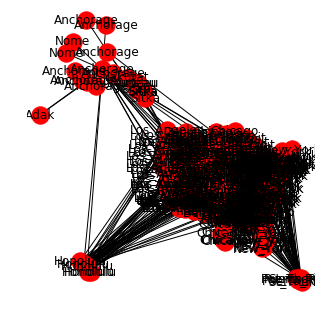

In [120]:
fun_1_draw_network_nodes_attr(G_all,attr='time_zone',size=4) 

In [144]:
#Demo 2 11m data 30min
years = [2007,2008]
sample_airports = error_airports
pre_data_2,G_all_2,airports_2,data_G_all_2,data_error_2=fun_2_pre_data_gen(years = years,sample_airports = sample_airports )#11m data ~30min

+++++++++++++++++++sample airports has set: 38.25693964958191  +++++++++++++++++++++++++++++++++++++++++
number of data: 11673485
number of data after drop cancelled: 11448256
number of data after drop no ArrTime: 11423786
number of data after drop no AirTime: 11421345
number of data after drop one way trips: 11420719
modify all numerical data to be integer
+++++++++++++++++++data has been simplified: 138.0956757068634  +++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++generating deault pre_data: 144.4996931552887  +++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++  ts pre gen is half way: 698.5996026992798  ++++++++++++++++++++++++
++++++++++++++++++++++++  ts pre gen is almost done : 1603.8374588489532  ++++++++++++++++++++++++
+++++++++++++++++++pre_data has generated : 1748.9651730060577 +++++++++++++++++++++++++++++++++++++++++
data with wrong abs time:  709 and error ratio: 0.006208025777754428
         Year  Month  DayofMonth  DepTime  ArrTime  ArrDela

In [146]:
data_error_2.head()

,Year,Month,DayofMonth,DepTime,ArrTime,ArrDelay,DepDelay,Origin,Dest,AirTime,TaxiIn,TaxiOut,AbsDepTime,AbsArrTime
4754679,2007,8,5,1450,2309,-1,-10,OGG,PDX,488,3,8,2007-08-05 17:50:00-07:00,2007-08-05 23:09:00-07:00
2385895,2007,4,16,2002,2119,-41,2,JFK,ORD,51,7,19,2007-04-16 17:02:00-07:00,2007-04-16 19:19:00-07:00
5993638,2007,10,14,244,539,-6,-1,LAS,HNL,154,6,15,2007-10-14 02:44:00-07:00,2007-10-14 08:39:00-07:00
5373369,2007,9,7,2217,648,-7,-8,HNL,LAS,488,7,16,2007-09-08 01:17:00-07:00,2007-09-08 06:48:00-07:00
2386538,2007,4,17,1312,2130,20,17,LGB,JFK,479,6,13,2007-04-17 13:12:00-07:00,2007-04-17 18:30:00-07:00


+++++++++++++++++++sample airports has set: 41.79627013206482  +++++++++++++++++++++++++++++++++++++++++
number of data: 182623
number of data after drop cancelled: 180172
number of data after drop no ArrTime: 180048
number of data after drop no AirTime: 180035
number of data after drop one way trips: 180035
modify all numerical data to be integer
+++++++++++++++++++data has been simplified: 45.02432084083557  +++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++generating deault pre_data: 45.193764448165894  +++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++  ts pre gen is half way: 11.434897422790527  ++++++++++++++++++++++++
++++++++++++++++++++++++  ts pre gen is almost done : 25.97579073905945  ++++++++++++++++++++++++
+++++++++++++++++++pre_data has generated : 71.17853164672852 +++++++++++++++++++++++++++++++++++++++++
data with wrong abs time:  0 and error ratio: 0.0
Empty DataFrame
Columns: [Year, Month, DayofMonth, DepTime, ArrTime, ArrDelay, DepDelay,

C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


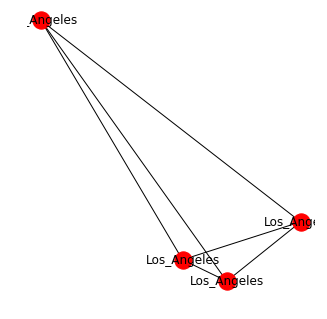

In [149]:
# Demo 3 180k data 71 seconds
years = [2007,2008]
sample_airports = ['SEA','LAX','LAS','SAN']
pre_data_3,G_all_3,airports_3,data_G_all_3,data_error_3=fun_2_pre_data_gen(years = years,sample_airports = sample_airports )
G=G_all_3
fun_1_draw_network_nodes_attr(G=G,attr='time_zone',size=4) 

In [152]:
#Demo 3 continued
airport='SEA'
grid=pd.date_range('2007-01-01 00:00:00','2008-12-30 00:00:00',freq='h',tz=timezone('America/Los_Angeles'))
dt=timedelta(seconds=3600)
pre_data=pre_data_3
#pre_data=pd.read_csv("Data/pre_timeseries.csv")
fun_1_delay_rate(airport,grid=grid,dt=dt,pre_data=pre_data,G=G).head()

loading finished: 0.0
AbsDepTime columnn generated: 0.5617499351501465
AbsArrTime columnn generated: 1.1392810344696045
data concated: 1.154266357421875
fun_1_ts_gen ended: 1.154266357421875


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


,TotalFlights,DelayFlights,DelayRatio
2007-01-01 00:00:00-08:00,0,0,NaN
2007-01-01 01:00:00-08:00,0,0,NaN
2007-01-01 02:00:00-08:00,1,1,1.0
2007-01-01 03:00:00-08:00,0,0,NaN
2007-01-01 04:00:00-08:00,0,0,NaN


In [180]:
#Demo 3 continued 46 seconds
fun25_export_data_sets(grid,dt,G,pre_data)
idx2airport,airport2idx,idx2time_stamp,time_stamp2idx,TotalFlights,DelayFlights,DelayRatio,test_index=fun25_import_datasets()

=========Testing  LAS ==========airports remains : 4 ========time lasted so far:  0.0
loading finished: 0.0
AbsDepTime columnn generated: 0.6639034748077393
AbsArrTime columnn generated: 1.3251936435699463
data concated: 1.3491597175598145
fun_1_ts_gen ended: 1.3501591682434082


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LAX ==========airports remains : 3 ========time lasted so far:  12.017971277236938
loading finished: 0.0
AbsDepTime columnn generated: 0.6621043682098389
AbsArrTime columnn generated: 1.3426508903503418
data concated: 1.3705756664276123
fun_1_ts_gen ended: 1.3705756664276123


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SAN ==========airports remains : 2 ========time lasted so far:  26.28031349182129
loading finished: 0.0
AbsDepTime columnn generated: 0.6652238368988037
AbsArrTime columnn generated: 1.3353791236877441
data concated: 1.350999355316162
fun_1_ts_gen ended: 1.350999355316162


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SEA ==========airports remains : 1 ========time lasted so far:  36.70245099067688
loading finished: 0.0
AbsDepTime columnn generated: 0.6781871318817139
AbsArrTime columnn generated: 1.3623933792114258
data concated: 1.3773488998413086
fun_1_ts_gen ended: 1.3773488998413086


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in longlong_scalars


======================Total time: 45.74660539627075
=========Testing  LAS ==========airports remains : 4 ========time lasted so far:  0.0
loading finished: 0.0
AbsDepTime columnn generated: 0.681182861328125
AbsArrTime columnn generated: 1.3693459033966064
data concated: 1.390291690826416
fun_1_ts_gen ended: 1.390291690826416


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LAX ==========airports remains : 3 ========time lasted so far:  12.280154466629028
loading finished: 0.0
AbsDepTime columnn generated: 0.6941511631011963
AbsArrTime columnn generated: 1.331444501876831
data concated: 1.3603696823120117
fun_1_ts_gen ended: 1.3603696823120117


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SAN ==========airports remains : 2 ========time lasted so far:  26.85816764831543
loading finished: 0.0
AbsDepTime columnn generated: 0.6652286052703857
AbsArrTime columnn generated: 1.3404209613800049
data concated: 1.3593723773956299
fun_1_ts_gen ended: 1.3593723773956299


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SEA ==========airports remains : 1 ========time lasted so far:  37.45284366607666
loading finished: 0.0
AbsDepTime columnn generated: 0.6811776161193848
AbsArrTime columnn generated: 1.3593640327453613
data concated: 1.3733241558074951
fun_1_ts_gen ended: 1.3733241558074951


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in longlong_scalars


======================Total time: 46.582425355911255


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:307: RuntimeWarning: invalid value encountered in true_divide


number of data: 14462943
number of data after drop cancelled: 14164761
number of data after drop no ArrTime: 14133367
number of data after drop no AirTime: 14130317
number of data after drop one way trips: 14127306
modify all numerical data to be integer
+++++++++++++++++++data has been simplified: 354.1247878074646  +++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++generating deault pre_data: 362.09457993507385  +++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++  ts pre gen is half way: 859.6677424907684  ++++++++++++++++++++++++
++++++++++++++++++++++++  ts pre gen is almost done : 1962.295053243637  ++++++++++++++++++++++++
+++++++++++++++++++pre_data has generated : 2325.128010749817 +++++++++++++++++++++++++++++++++++++++++
data with wrong abs time:  716 and error ratio: 0.005068201284038705
         Year  Month  DayofMonth  DepTime  ArrTime  ArrDelay  DepDelay Origin  \
573177   2007      1          29     2306      705         2        -4    OAK   
573

C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


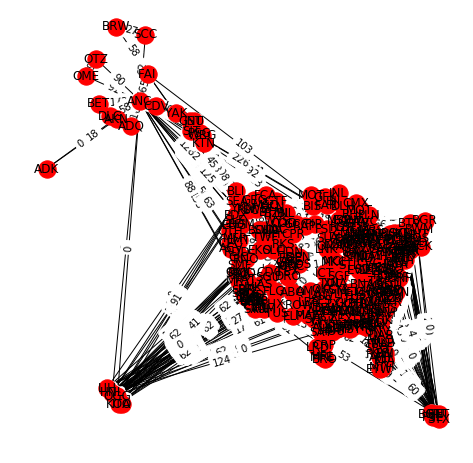

loading finished: 0.0
AbsDepTime columnn generated: 56.44146704673767
AbsArrTime columnn generated: 112.98595142364502
data concated: 113.09530091285706
fun_1_ts_gen ended: 113.09530091285706


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


,TotalFlights,DelayFlights,DelayRatio
2007-01-01 00:00:00-08:00,9,5,0.555556
2007-01-01 01:00:00-08:00,0,0,NaN
2007-01-01 02:00:00-08:00,1,1,1.000000
2007-01-01 03:00:00-08:00,0,0,NaN
2007-01-01 04:00:00-08:00,0,0,NaN


In [309]:
# Demo 4 14m data 40 min
years = [2007,2008]
sample_airports = []
pre_data_4,G_all_4,airports_4,data_G_all_4,data_error_4=fun_2_pre_data_gen(years = years,sample_airports = sample_airports )

C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


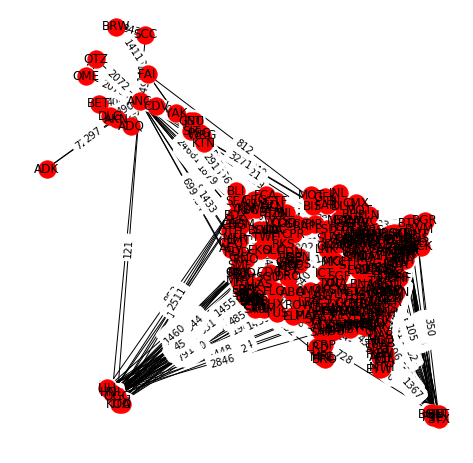

loading finished: 0.0
AbsDepTime columnn generated: 58.939196825027466
AbsArrTime columnn generated: 115.91362690925598
data concated: 116.01735019683838
fun_1_ts_gen ended: 116.01735019683838


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


,TotalFlights,DelayFlights,DelayRatio
2007-01-01 00:00:00-08:00,9,5,0.555556
2007-01-01 01:00:00-08:00,0,0,NaN
2007-01-01 02:00:00-08:00,1,1,1.000000
2007-01-01 03:00:00-08:00,0,0,NaN
2007-01-01 04:00:00-08:00,0,0,NaN


In [401]:
# Demo 4 continued fun_1_nework_build_with_pre_data is extremly slow
G=G_all_4
pre_data=pre_data_4
airport='SEA'
grid=pd.date_range('2007-01-01 00:00:00','2008-12-30 00:00:00',freq='h',tz=timezone('America/Los_Angeles'))
dt=timedelta(seconds=3600)
st_abstime_str = '2007-08-01 00:00:00'
end_abstime_str = '2007-09-01 00:00:00'

#add totalnumber and delay number between st_abstime and end_abstime for each edge
#fun_1_nework_build_with_pre_data(st_abstime_str = st_abstime_str,end_abstime_str = end_abstime_str,pre_data = pre_data, G = G)
G_und=fun_1_to_undir_G(G)
#nx.to_pandas_edgelist(G).to_csv('directedgraph_TotalFlights_in_range.csv')

fun_1_draw_network_attr(G_und,nodes_attr=None,edges_attr='weight',size=6)
fun_1_delay_rate(airport,grid=grid,dt=dt,pre_data=pre_data,G=G).head()

In [402]:
fun25_export_data_sets(grid,dt,G,pre_data)

=========Testing  ABE ==========airports remains : 311 ========time lasted so far:  0.0
loading finished: 0.0
AbsDepTime columnn generated: 57.08221387863159
AbsArrTime columnn generated: 112.72427916526794
data concated: 112.72427916526794
fun_1_ts_gen ended: 112.72427916526794


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ATL ==========airports remains : 310 ========time lasted so far:  116.46158838272095
loading finished: 0.0
AbsDepTime columnn generated: 55.10444617271423
AbsArrTime columnn generated: 112.57448077201843
data concated: 112.90456366539001
fun_1_ts_gen ended: 112.9055609703064


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BWI ==========airports remains : 309 ========time lasted so far:  370.8514771461487
loading finished: 0.0
AbsDepTime columnn generated: 55.417969942092896
AbsArrTime columnn generated: 110.69816088676453
data concated: 110.82313108444214
fun_1_ts_gen ended: 110.82313108444214


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CLE ==========airports remains : 308 ========time lasted so far:  518.3777866363525
loading finished: 0.0
AbsDepTime columnn generated: 56.85377478599548
AbsArrTime columnn generated: 112.85956120491028
data concated: 112.92204737663269
fun_1_ts_gen ended: 112.92204737663269


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CLT ==========airports remains : 307 ========time lasted so far:  657.4970455169678
loading finished: 0.0
AbsDepTime columnn generated: 56.014036655426025
AbsArrTime columnn generated: 111.79937934875488
data concated: 111.93202495574951
fun_1_ts_gen ended: 111.93302273750305


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CVG ==========airports remains : 306 ========time lasted so far:  814.0900447368622
loading finished: 0.0
AbsDepTime columnn generated: 56.147905111312866
AbsArrTime columnn generated: 111.84546947479248
data concated: 111.94597959518433
fun_1_ts_gen ended: 111.94597959518433


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DTW ==========airports remains : 305 ========time lasted so far:  961.527480840683
loading finished: 0.0
AbsDepTime columnn generated: 55.78790283203125
AbsArrTime columnn generated: 111.88591527938843
data concated: 112.02653980255127
fun_1_ts_gen ended: 112.02653980255127


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ORD ==========airports remains : 304 ========time lasted so far:  1132.6509282588959
loading finished: 0.0
AbsDepTime columnn generated: 56.198381423950195
AbsArrTime columnn generated: 112.4463279247284
data concated: 112.72761940956116
fun_1_ts_gen ended: 112.72761940956116


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ABI ==========airports remains : 303 ========time lasted so far:  1369.9508996009827
loading finished: 0.0
AbsDepTime columnn generated: 56.78641390800476
AbsArrTime columnn generated: 112.75641918182373
data concated: 112.75641918182373
fun_1_ts_gen ended: 112.75641918182373


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DFW ==========airports remains : 302 ========time lasted so far:  1485.4295547008514
loading finished: 0.0
AbsDepTime columnn generated: 55.97965955734253
AbsArrTime columnn generated: 112.04545331001282
data concated: 112.27977252006531
fun_1_ts_gen ended: 112.27977252006531


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ABQ ==========airports remains : 301 ========time lasted so far:  1695.8467907905579
loading finished: 0.0
AbsDepTime columnn generated: 55.17139267921448
AbsArrTime columnn generated: 111.32886528968811
data concated: 111.37572836875916
fun_1_ts_gen ended: 111.37572836875916


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AMA ==========airports remains : 300 ========time lasted so far:  1822.9615714550018
loading finished: 0.0
AbsDepTime columnn generated: 55.82491326332092
AbsArrTime columnn generated: 112.26457500457764
data concated: 112.26457500457764
fun_1_ts_gen ended: 112.26457500457764


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AUS ==========airports remains : 299 ========time lasted so far:  1939.784892320633
loading finished: 0.0
AbsDepTime columnn generated: 55.66914224624634
AbsArrTime columnn generated: 110.71847033500671
data concated: 110.7809567451477
fun_1_ts_gen ended: 110.7809567451477


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DAL ==========airports remains : 298 ========time lasted so far:  2069.4634981155396
loading finished: 0.0
AbsDepTime columnn generated: 55.48155641555786
AbsArrTime columnn generated: 112.26662755012512
data concated: 112.31649565696716
fun_1_ts_gen ended: 112.3174934387207


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DEN ==========airports remains : 297 ========time lasted so far:  2201.129749059677
loading finished: 0.0
AbsDepTime columnn generated: 55.42115831375122
AbsArrTime columnn generated: 112.3603925704956
data concated: 112.56347155570984
fun_1_ts_gen ended: 112.56347155570984


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ELP ==========airports remains : 296 ========time lasted so far:  2396.4663820266724
loading finished: 0.0
AbsDepTime columnn generated: 54.71016550064087
AbsArrTime columnn generated: 111.16910457611084
data concated: 111.1847243309021
fun_1_ts_gen ended: 111.1847243309021


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EWR ==========airports remains : 295 ========time lasted so far:  2516.9365532398224
loading finished: 0.0
AbsDepTime columnn generated: 55.86602330207825
AbsArrTime columnn generated: 112.3649230003357
data concated: 112.4806137084961
fun_1_ts_gen ended: 112.48161125183105


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HOU ==========airports remains : 294 ========time lasted so far:  2684.3937187194824
loading finished: 0.0
AbsDepTime columnn generated: 55.32002806663513
AbsArrTime columnn generated: 111.1893904209137
data concated: 111.25187587738037
fun_1_ts_gen ended: 111.25187587738037


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  IAD ==========airports remains : 293 ========time lasted so far:  2816.6189770698547
loading finished: 0.0
AbsDepTime columnn generated: 56.44662642478943
AbsArrTime columnn generated: 111.91600728034973
data concated: 111.97849249839783
fun_1_ts_gen ended: 111.9941132068634


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  IAH ==========airports remains : 292 ========time lasted so far:  2959.043539047241
loading finished: 0.0
AbsDepTime columnn generated: 56.57126593589783
AbsArrTime columnn generated: 112.72655463218689
data concated: 112.91400909423828
fun_1_ts_gen ended: 112.91400909423828


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LAS ==========airports remains : 291 ========time lasted so far:  3136.8025736808777
loading finished: 0.0
AbsDepTime columnn generated: 55.80983066558838
AbsArrTime columnn generated: 111.51514387130737
data concated: 111.67135643959045
fun_1_ts_gen ended: 111.67135643959045


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LAX ==========airports remains : 290 ========time lasted so far:  3309.9830057621
loading finished: 0.0
AbsDepTime columnn generated: 56.10169553756714
AbsArrTime columnn generated: 111.80091142654419
data concated: 112.00399041175842
fun_1_ts_gen ended: 112.00399041175842


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LBB ==========airports remains : 289 ========time lasted so far:  3497.8150556087494
loading finished: 0.0
AbsDepTime columnn generated: 55.6592059135437
AbsArrTime columnn generated: 112.34406566619873
data concated: 112.34406566619873
fun_1_ts_gen ended: 112.34406566619873


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MAF ==========airports remains : 288 ========time lasted so far:  3615.110941886902
loading finished: 0.0
AbsDepTime columnn generated: 55.45486640930176
AbsArrTime columnn generated: 111.28140568733215
data concated: 111.28140568733215
fun_1_ts_gen ended: 111.28140568733215


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MCI ==========airports remains : 287 ========time lasted so far:  3730.8461022377014
loading finished: 0.0
AbsDepTime columnn generated: 56.64307451248169
AbsArrTime columnn generated: 112.26743721961975
data concated: 112.32992243766785
fun_1_ts_gen ended: 112.32992243766785


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MCO ==========airports remains : 286 ========time lasted so far:  3865.9034864902496
loading finished: 0.0
AbsDepTime columnn generated: 56.807748794555664
AbsArrTime columnn generated: 112.72415971755981
data concated: 112.84916257858276
fun_1_ts_gen ended: 112.84916257858276


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MDW ==========airports remains : 285 ========time lasted so far:  4023.9395904541016
loading finished: 0.0
AbsDepTime columnn generated: 55.47693181037903
AbsArrTime columnn generated: 110.89122176170349
data concated: 110.98495078086853
fun_1_ts_gen ended: 110.98495078086853


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MSP ==========airports remains : 284 ========time lasted so far:  4166.878673791885
loading finished: 0.0
AbsDepTime columnn generated: 56.459660053253174
AbsArrTime columnn generated: 111.43855118751526
data concated: 111.56352138519287
fun_1_ts_gen ended: 111.56352138519287


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OAK ==========airports remains : 283 ========time lasted so far:  4327.157706022263
loading finished: 0.0
AbsDepTime columnn generated: 56.095324993133545
AbsArrTime columnn generated: 112.57919502258301
data concated: 112.641681432724
fun_1_ts_gen ended: 112.641681432724


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OKC ==========airports remains : 282 ========time lasted so far:  4464.190503120422
loading finished: 0.0
AbsDepTime columnn generated: 55.04842281341553
AbsArrTime columnn generated: 110.5882658958435
data concated: 110.61950826644897
fun_1_ts_gen ended: 110.61950826644897


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ONT ==========airports remains : 281 ========time lasted so far:  4585.986104726791
loading finished: 0.0
AbsDepTime columnn generated: 57.07170104980469
AbsArrTime columnn generated: 112.43141436576843
data concated: 112.46265745162964
fun_1_ts_gen ended: 112.46265745162964


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PDX ==========airports remains : 280 ========time lasted so far:  4713.132034063339
loading finished: 0.0
AbsDepTime columnn generated: 55.34621071815491
AbsArrTime columnn generated: 111.79606699943542
data concated: 111.84293174743652
fun_1_ts_gen ended: 111.84293174743652


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PHX ==========airports remains : 279 ========time lasted so far:  4846.520526647568
loading finished: 0.0
AbsDepTime columnn generated: 55.43079924583435
AbsArrTime columnn generated: 111.76784157752991
data concated: 111.94038009643555
fun_1_ts_gen ended: 111.94137763977051


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SAN ==========airports remains : 278 ========time lasted so far:  5026.920751094818
loading finished: 0.0
AbsDepTime columnn generated: 55.45223903656006
AbsArrTime columnn generated: 111.19313859939575
data concated: 111.28289842605591
fun_1_ts_gen ended: 111.28389596939087


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SAT ==========airports remains : 277 ========time lasted so far:  5171.632048368454
loading finished: 0.0
AbsDepTime columnn generated: 55.576929569244385
AbsArrTime columnn generated: 111.13659429550171
data concated: 111.16783666610718
fun_1_ts_gen ended: 111.16783666610718


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SEA ==========airports remains : 276 ========time lasted so far:  5300.16760468483
loading finished: 0.0
AbsDepTime columnn generated: 55.30468702316284
AbsArrTime columnn generated: 111.57920956611633
data concated: 111.67293787002563
fun_1_ts_gen ended: 111.67293787002563


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SFO ==========airports remains : 275 ========time lasted so far:  5450.735846757889
loading finished: 0.0
AbsDepTime columnn generated: 55.89224600791931
AbsArrTime columnn generated: 112.39891004562378
data concated: 112.51559782028198
fun_1_ts_gen ended: 112.51659536361694


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SLC ==========airports remains : 274 ========time lasted so far:  5613.730640172958
loading finished: 0.0
AbsDepTime columnn generated: 56.569018840789795
AbsArrTime columnn generated: 111.74361205101013
data concated: 111.86628413200378
fun_1_ts_gen ended: 111.86728167533875


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SMF ==========airports remains : 273 ========time lasted so far:  5773.805530786514
loading finished: 0.0
AbsDepTime columnn generated: 55.82396340370178
AbsArrTime columnn generated: 112.0734224319458
data concated: 112.1359076499939
fun_1_ts_gen ended: 112.1359076499939


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  STL ==========airports remains : 272 ========time lasted so far:  5906.442088365555
loading finished: 0.0
AbsDepTime columnn generated: 56.389819622039795
AbsArrTime columnn generated: 111.81127882003784
data concated: 111.87376523017883
fun_1_ts_gen ended: 111.87376523017883


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TPA ==========airports remains : 271 ========time lasted so far:  6041.567744970322
loading finished: 0.0
AbsDepTime columnn generated: 55.96949601173401
AbsArrTime columnn generated: 112.43541264533997
data concated: 112.51352047920227
fun_1_ts_gen ended: 112.51352047920227


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TUL ==========airports remains : 270 ========time lasted so far:  6182.1922080516815
loading finished: 0.0
AbsDepTime columnn generated: 54.935962438583374
AbsArrTime columnn generated: 111.74889659881592
data concated: 111.76454067230225
fun_1_ts_gen ended: 111.76454067230225


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TUS ==========airports remains : 269 ========time lasted so far:  6304.387785434723
loading finished: 0.0
AbsDepTime columnn generated: 56.005900621414185
AbsArrTime columnn generated: 111.77270174026489
data concated: 111.80397081375122
fun_1_ts_gen ended: 111.80397081375122


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ABY ==========airports remains : 268 ========time lasted so far:  6427.555678606033
loading finished: 0.0
AbsDepTime columnn generated: 55.58809304237366
AbsArrTime columnn generated: 111.30666017532349
data concated: 111.32227754592896
fun_1_ts_gen ended: 111.32227754592896


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ACK ==========airports remains : 267 ========time lasted so far:  6540.868229150772
loading finished: 0.0
AbsDepTime columnn generated: 55.7907555103302
AbsArrTime columnn generated: 111.24277067184448
data concated: 111.2467908859253
fun_1_ts_gen ended: 111.24779796600342


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  JFK ==========airports remains : 266 ========time lasted so far:  6653.589883089066
loading finished: 0.0
AbsDepTime columnn generated: 56.74347496032715
AbsArrTime columnn generated: 112.57873773574829
data concated: 112.68744683265686
fun_1_ts_gen ended: 112.68844413757324


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ACT ==========airports remains : 265 ========time lasted so far:  6811.626800298691
loading finished: 0.0
AbsDepTime columnn generated: 55.797966957092285
AbsArrTime columnn generated: 112.14161491394043
data concated: 112.14161491394043
fun_1_ts_gen ended: 112.14161491394043


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ACV ==========airports remains : 264 ========time lasted so far:  6926.17542886734
loading finished: 0.0
AbsDepTime columnn generated: 55.65810799598694
AbsArrTime columnn generated: 111.46924138069153
data concated: 111.48486185073853
fun_1_ts_gen ended: 111.48486185073853


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CEC ==========airports remains : 263 ========time lasted so far:  7040.867230892181
loading finished: 0.0
AbsDepTime columnn generated: 54.98959732055664
AbsArrTime columnn generated: 110.00847959518433
data concated: 110.01246929168701
fun_1_ts_gen ended: 110.01246929168701


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ACY ==========airports remains : 262 ========time lasted so far:  7152.7623908519745
loading finished: 0.0
AbsDepTime columnn generated: 55.5999321937561
AbsArrTime columnn generated: 111.47111749649048
data concated: 111.47510123252869
fun_1_ts_gen ended: 111.47609877586365


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ADK ==========airports remains : 261 ========time lasted so far:  7265.604020357132
loading finished: 0.0
AbsDepTime columnn generated: 56.28930950164795
AbsArrTime columnn generated: 111.59671688079834
data concated: 111.60070610046387
fun_1_ts_gen ended: 111.60070610046387


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AKN ==========airports remains : 260 ========time lasted so far:  7378.585847854614
loading finished: 0.0
AbsDepTime columnn generated: 55.7783637046814
AbsArrTime columnn generated: 111.09322333335876
data concated: 111.09322333335876
fun_1_ts_gen ended: 111.09322333335876


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ANC ==========airports remains : 259 ========time lasted so far:  7490.998762369156
loading finished: 0.0
AbsDepTime columnn generated: 55.78652310371399
AbsArrTime columnn generated: 111.41086959838867
data concated: 111.4421124458313
fun_1_ts_gen ended: 111.4421124458313


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ADQ ==========airports remains : 258 ========time lasted so far:  7611.558665752411
loading finished: 0.0
AbsDepTime columnn generated: 56.539024114608765
AbsArrTime columnn generated: 111.72620129585266
data concated: 111.7418110370636
fun_1_ts_gen ended: 111.7418110370636


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AEX ==========airports remains : 257 ========time lasted so far:  7724.958758831024
loading finished: 0.0
AbsDepTime columnn generated: 55.355409383773804
AbsArrTime columnn generated: 112.09134411811829
data concated: 112.09633159637451
fun_1_ts_gen ended: 112.097341299057


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AGS ==========airports remains : 256 ========time lasted so far:  7839.817493200302
loading finished: 0.0
AbsDepTime columnn generated: 55.469955921173096
AbsArrTime columnn generated: 110.81131076812744
data concated: 110.81131076812744
fun_1_ts_gen ended: 110.81131076812744


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LGA ==========airports remains : 255 ========time lasted so far:  7953.260549783707
loading finished: 0.0
AbsDepTime columnn generated: 56.12037920951843
AbsArrTime columnn generated: 111.71293902397156
data concated: 111.80679106712341
fun_1_ts_gen ended: 111.80679106712341


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ALB ==========airports remains : 254 ========time lasted so far:  8108.514409542084
loading finished: 0.0
AbsDepTime columnn generated: 56.130730867385864
AbsArrTime columnn generated: 112.06750750541687
data concated: 112.0831286907196
fun_1_ts_gen ended: 112.0831286907196


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DCA ==========airports remains : 253 ========time lasted so far:  8227.763897657394
loading finished: 0.0
AbsDepTime columnn generated: 55.004589796066284
AbsArrTime columnn generated: 110.66703128814697
data concated: 110.76676440238953
fun_1_ts_gen ended: 110.76676440238953


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FLL ==========airports remains : 252 ========time lasted so far:  8369.473495721817
loading finished: 0.0
AbsDepTime columnn generated: 55.19876480102539
AbsArrTime columnn generated: 110.78071188926697
data concated: 110.8494656085968
fun_1_ts_gen ended: 110.8494656085968


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PHL ==========airports remains : 251 ========time lasted so far:  8506.011821746826
loading finished: 0.0
AbsDepTime columnn generated: 55.52305579185486
AbsArrTime columnn generated: 111.49242091178894
data concated: 111.5861485004425
fun_1_ts_gen ended: 111.5861485004425


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ALO ==========airports remains : 250 ========time lasted so far:  8654.763946294785
loading finished: 0.0
AbsDepTime columnn generated: 55.943257093429565
AbsArrTime columnn generated: 111.77109289169312
data concated: 111.78672099113464
fun_1_ts_gen ended: 111.78672099113464


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BET ==========airports remains : 249 ========time lasted so far:  8768.000375032425
loading finished: 0.0
AbsDepTime columnn generated: 55.21119666099548
AbsArrTime columnn generated: 110.69171738624573
data concated: 110.69171738624573
fun_1_ts_gen ended: 110.69171738624573


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CDV ==========airports remains : 248 ========time lasted so far:  8880.548805475235
loading finished: 0.0
AbsDepTime columnn generated: 54.908833026885986
AbsArrTime columnn generated: 110.59654259681702
data concated: 110.59654259681702
fun_1_ts_gen ended: 110.59654259681702


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DLG ==========airports remains : 247 ========time lasted so far:  8992.828330993652
loading finished: 0.0
AbsDepTime columnn generated: 56.09530329704285
AbsArrTime columnn generated: 111.32989311218262
data concated: 111.34551310539246
fun_1_ts_gen ended: 111.34551310539246


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FAI ==========airports remains : 246 ========time lasted so far:  9105.496259212494
loading finished: 0.0
AbsDepTime columnn generated: 56.21012020111084
AbsArrTime columnn generated: 111.37751054763794
data concated: 111.38346266746521
fun_1_ts_gen ended: 111.38346266746521


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HNL ==========airports remains : 245 ========time lasted so far:  9220.505935430527
loading finished: 0.0
AbsDepTime columnn generated: 55.0438814163208
AbsArrTime columnn generated: 111.74835157394409
data concated: 111.82315182685852
fun_1_ts_gen ended: 111.82315182685852


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  JNU ==========airports remains : 244 ========time lasted so far:  9352.934772729874
loading finished: 0.0
AbsDepTime columnn generated: 55.27216863632202
AbsArrTime columnn generated: 110.54521441459656
data concated: 110.55119848251343
fun_1_ts_gen ended: 110.55119848251343


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OGG ==========airports remains : 243 ========time lasted so far:  9466.974026441574
loading finished: 0.0
AbsDepTime columnn generated: 55.66939568519592
AbsArrTime columnn generated: 110.88795566558838
data concated: 110.90357685089111
fun_1_ts_gen ended: 110.90357685089111


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OME ==========airports remains : 242 ========time lasted so far:  9586.667404413223
loading finished: 0.0
AbsDepTime columnn generated: 55.757429122924805
AbsArrTime columnn generated: 111.44650983810425
data concated: 111.44650983810425
fun_1_ts_gen ended: 111.44650983810425


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OTZ ==========airports remains : 241 ========time lasted so far:  9700.018939495087
loading finished: 0.0
AbsDepTime columnn generated: 56.56218957901001
AbsArrTime columnn generated: 112.08078479766846
data concated: 112.08078479766846
fun_1_ts_gen ended: 112.08078479766846


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SCC ==========airports remains : 240 ========time lasted so far:  9813.997889757156
loading finished: 0.0
AbsDepTime columnn generated: 55.18778872489929
AbsArrTime columnn generated: 111.69911932945251
data concated: 111.70310854911804
fun_1_ts_gen ended: 111.70310854911804


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  APF ==========airports remains : 239 ========time lasted so far:  9927.333290338516
loading finished: 0.0
AbsDepTime columnn generated: 54.950363874435425
AbsArrTime columnn generated: 111.09232687950134
data concated: 111.09232687950134
fun_1_ts_gen ended: 111.09232687950134


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ASE ==========airports remains : 238 ========time lasted so far:  10039.582121610641
loading finished: 0.0
AbsDepTime columnn generated: 55.027848958969116
AbsArrTime columnn generated: 111.60822296142578
data concated: 111.60822296142578
fun_1_ts_gen ended: 111.60822296142578


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ATW ==========airports remains : 237 ========time lasted so far:  10154.722881555557
loading finished: 0.0
AbsDepTime columnn generated: 55.07804274559021
AbsArrTime columnn generated: 110.1546585559845
data concated: 110.17025351524353
fun_1_ts_gen ended: 110.17025351524353


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AVL ==========airports remains : 236 ========time lasted so far:  10268.900168657303
loading finished: 0.0
AbsDepTime columnn generated: 56.06144881248474
AbsArrTime columnn generated: 111.35474872589111
data concated: 111.370370388031
fun_1_ts_gen ended: 111.370370388031


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AVP ==========airports remains : 235 ========time lasted so far:  10383.561565160751
loading finished: 0.0
AbsDepTime columnn generated: 55.97435474395752
AbsArrTime columnn generated: 111.72507214546204
data concated: 111.72507214546204
fun_1_ts_gen ended: 111.72507214546204


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AZO ==========airports remains : 234 ========time lasted so far:  10497.959195375443
loading finished: 0.0
AbsDepTime columnn generated: 55.608447313308716
AbsArrTime columnn generated: 110.87259769439697
data concated: 110.87259769439697
fun_1_ts_gen ended: 110.87259769439697


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BDL ==========airports remains : 233 ========time lasted so far:  10612.139117240906
loading finished: 0.0
AbsDepTime columnn generated: 55.543312311172485
AbsArrTime columnn generated: 110.83363437652588
data concated: 110.86484980583191
fun_1_ts_gen ended: 110.86484980583191


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BGM ==========airports remains : 232 ========time lasted so far:  10735.887959957123
loading finished: 0.0
AbsDepTime columnn generated: 55.4590208530426
AbsArrTime columnn generated: 110.9432463645935
data concated: 110.9432463645935
fun_1_ts_gen ended: 110.9432463645935


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BGR ==========airports remains : 231 ========time lasted so far:  10848.598895311356
loading finished: 0.0
AbsDepTime columnn generated: 56.10847997665405
AbsArrTime columnn generated: 112.01551938056946
data concated: 112.03109884262085
fun_1_ts_gen ended: 112.03109884262085


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BHM ==========airports remains : 230 ========time lasted so far:  10963.710586071014
loading finished: 0.0
AbsDepTime columnn generated: 55.70059323310852
AbsArrTime columnn generated: 111.51132678985596
data concated: 111.52694392204285
fun_1_ts_gen ended: 111.52694392204285


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BMI ==========airports remains : 229 ========time lasted so far:  11085.473482608795
loading finished: 0.0
AbsDepTime columnn generated: 56.10805797576904
AbsArrTime columnn generated: 111.95290684700012
data concated: 111.95290684700012
fun_1_ts_gen ended: 111.95290684700012


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BNA ==========airports remains : 228 ========time lasted so far:  11200.794644594193
loading finished: 0.0
AbsDepTime columnn generated: 54.98997211456299
AbsArrTime columnn generated: 110.4287109375
data concated: 110.4911961555481
fun_1_ts_gen ended: 110.4911961555481


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BOI ==========airports remains : 227 ========time lasted so far:  11333.550651788712
loading finished: 0.0
AbsDepTime columnn generated: 55.56145477294922
AbsArrTime columnn generated: 110.46782660484314
data concated: 110.48344707489014
fun_1_ts_gen ended: 110.48344707489014


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BOS ==========airports remains : 226 ========time lasted so far:  11452.068551301956
loading finished: 0.0
AbsDepTime columnn generated: 55.529929876327515
AbsArrTime columnn generated: 110.79554176330566
data concated: 110.90492463111877
fun_1_ts_gen ended: 110.90492463111877


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BQK ==========airports remains : 225 ========time lasted so far:  11606.346259117126
loading finished: 0.0
AbsDepTime columnn generated: 56.12546348571777
AbsArrTime columnn generated: 111.90663886070251
data concated: 111.90663886070251
fun_1_ts_gen ended: 111.90663886070251


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BTR ==========airports remains : 224 ========time lasted so far:  11720.085075616837
loading finished: 0.0
AbsDepTime columnn generated: 55.76056265830994
AbsArrTime columnn generated: 111.41140818595886
data concated: 111.42134022712708
fun_1_ts_gen ended: 111.42134022712708


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BTV ==========airports remains : 223 ========time lasted so far:  11836.994733810425
loading finished: 0.0
AbsDepTime columnn generated: 55.04257106781006
AbsArrTime columnn generated: 110.19560194015503
data concated: 110.21119260787964
fun_1_ts_gen ended: 110.21119260787964


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BUF ==========airports remains : 222 ========time lasted so far:  11951.879690170288
loading finished: 0.0
AbsDepTime columnn generated: 55.10892295837402
AbsArrTime columnn generated: 110.64050507545471
data concated: 110.67174792289734
fun_1_ts_gen ended: 110.67174792289734


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BZN ==========airports remains : 221 ========time lasted so far:  12073.94525027275
loading finished: 0.0
AbsDepTime columnn generated: 56.1825532913208
AbsArrTime columnn generated: 111.0890851020813
data concated: 111.0890851020813
fun_1_ts_gen ended: 111.0890851020813


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CAE ==========airports remains : 220 ========time lasted so far:  12188.680841684341
loading finished: 0.0
AbsDepTime columnn generated: 55.234784841537476
AbsArrTime columnn generated: 111.7127857208252
data concated: 111.72840738296509
fun_1_ts_gen ended: 111.72840738296509


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CAK ==========airports remains : 219 ========time lasted so far:  12306.323997497559
loading finished: 0.0
AbsDepTime columnn generated: 55.00917053222656
AbsArrTime columnn generated: 110.13197255134583
data concated: 110.14759159088135
fun_1_ts_gen ended: 110.14759159088135


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CHA ==========airports remains : 218 ========time lasted so far:  12421.729415893555
loading finished: 0.0
AbsDepTime columnn generated: 55.32065796852112
AbsArrTime columnn generated: 111.0232286453247
data concated: 111.0232286453247
fun_1_ts_gen ended: 111.0232286453247


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CHO ==========airports remains : 217 ========time lasted so far:  12536.152160167694
loading finished: 0.0
AbsDepTime columnn generated: 54.647252321243286
AbsArrTime columnn generated: 111.1161539554596
data concated: 111.13173246383667
fun_1_ts_gen ended: 111.13173246383667


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CHS ==========airports remains : 216 ========time lasted so far:  12649.159242391586
loading finished: 0.0
AbsDepTime columnn generated: 55.95504426956177
AbsArrTime columnn generated: 111.72681069374084
data concated: 111.72681069374084
fun_1_ts_gen ended: 111.74239587783813


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CID ==========airports remains : 215 ========time lasted so far:  12768.330099105835
loading finished: 0.0
AbsDepTime columnn generated: 55.39548707008362
AbsArrTime columnn generated: 110.7768964767456
data concated: 110.78689455986023
fun_1_ts_gen ended: 110.78689455986023


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CMH ==========airports remains : 214 ========time lasted so far:  12884.744458675385
loading finished: 0.0
AbsDepTime columnn generated: 55.75835037231445
AbsArrTime columnn generated: 111.76627206802368
data concated: 111.80117845535278
fun_1_ts_gen ended: 111.80217552185059


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  COS ==========airports remains : 213 ========time lasted so far:  13011.03262591362
loading finished: 0.0
AbsDepTime columnn generated: 56.11231207847595
AbsArrTime columnn generated: 112.5487859249115
data concated: 112.56440544128418
fun_1_ts_gen ended: 112.56440544128418


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CRP ==========airports remains : 212 ========time lasted so far:  13131.480620145798
loading finished: 0.0
AbsDepTime columnn generated: 55.53819298744202
AbsArrTime columnn generated: 110.91336345672607
data concated: 110.91336345672607
fun_1_ts_gen ended: 110.91336345672607


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CRW ==========airports remains : 211 ========time lasted so far:  13246.385167121887
loading finished: 0.0
AbsDepTime columnn generated: 55.82137703895569
AbsArrTime columnn generated: 112.42998218536377
data concated: 112.42998218536377
fun_1_ts_gen ended: 112.42998218536377


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CSG ==========airports remains : 210 ========time lasted so far:  13361.77960395813
loading finished: 0.0
AbsDepTime columnn generated: 56.451842069625854
AbsArrTime columnn generated: 111.98973155021667
data concated: 111.98973155021667
fun_1_ts_gen ended: 111.98973155021667


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DAB ==========airports remains : 209 ========time lasted so far:  13475.897856712341
loading finished: 0.0
AbsDepTime columnn generated: 55.40227937698364
AbsArrTime columnn generated: 110.46337151527405
data concated: 110.46835780143738
fun_1_ts_gen ended: 110.46835780143738


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DAY ==========airports remains : 208 ========time lasted so far:  13589.395018815994
loading finished: 0.0
AbsDepTime columnn generated: 55.26963257789612
AbsArrTime columnn generated: 111.68624663352966
data concated: 111.70182704925537
fun_1_ts_gen ended: 111.70182704925537


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DHN ==========airports remains : 207 ========time lasted so far:  13708.598130226135
loading finished: 0.0
AbsDepTime columnn generated: 55.74934363365173
AbsArrTime columnn generated: 111.46722483634949
data concated: 111.48284578323364
fun_1_ts_gen ended: 111.48284578323364


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DSM ==========airports remains : 206 ========time lasted so far:  13822.241914987564
loading finished: 0.0
AbsDepTime columnn generated: 55.201010942459106
AbsArrTime columnn generated: 110.82520961761475
data concated: 110.85645151138306
fun_1_ts_gen ended: 110.85645151138306


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EGE ==========airports remains : 205 ========time lasted so far:  13940.967759609222
loading finished: 0.0
AbsDepTime columnn generated: 54.95669198036194
AbsArrTime columnn generated: 110.83835935592651
data concated: 110.84234833717346
fun_1_ts_gen ended: 110.84334588050842


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ERI ==========airports remains : 204 ========time lasted so far:  14054.619779348373
loading finished: 0.0
AbsDepTime columnn generated: 55.38441038131714
AbsArrTime columnn generated: 111.40044713020325
data concated: 111.40044713020325
fun_1_ts_gen ended: 111.40044713020325


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EVV ==========airports remains : 203 ========time lasted so far:  14168.036124229431
loading finished: 0.0
AbsDepTime columnn generated: 55.40218186378479
AbsArrTime columnn generated: 110.80525803565979
data concated: 110.80525803565979
fun_1_ts_gen ended: 110.80525803565979


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EWN ==========airports remains : 202 ========time lasted so far:  14282.74248790741
loading finished: 0.0
AbsDepTime columnn generated: 55.119468212127686
AbsArrTime columnn generated: 110.18216872215271
data concated: 110.18216872215271
fun_1_ts_gen ended: 110.18216872215271


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EYW ==========airports remains : 201 ========time lasted so far:  14394.706271886826
loading finished: 0.0
AbsDepTime columnn generated: 56.34352779388428
AbsArrTime columnn generated: 111.96989679336548
data concated: 111.96989679336548
fun_1_ts_gen ended: 111.96989679336548


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FAY ==========airports remains : 200 ========time lasted so far:  14508.601121664047
loading finished: 0.0
AbsDepTime columnn generated: 54.83908820152283
AbsArrTime columnn generated: 111.35372352600098
data concated: 111.35372352600098
fun_1_ts_gen ended: 111.35372352600098


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FCA ==========airports remains : 199 ========time lasted so far:  14622.507021427155
loading finished: 0.0
AbsDepTime columnn generated: 55.77853965759277
AbsArrTime columnn generated: 111.65281701087952
data concated: 111.65281701087952
fun_1_ts_gen ended: 111.65281701087952


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FLO ==========airports remains : 198 ========time lasted so far:  14736.881170272827
loading finished: 0.0
AbsDepTime columnn generated: 55.413121461868286
AbsArrTime columnn generated: 110.68562841415405
data concated: 110.70125007629395
fun_1_ts_gen ended: 110.70125007629395


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FNT ==========airports remains : 197 ========time lasted so far:  14849.267312765121
loading finished: 0.0
AbsDepTime columnn generated: 54.98645901679993
AbsArrTime columnn generated: 111.22143864631653
data concated: 111.22143864631653
fun_1_ts_gen ended: 111.22143864631653


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FSD ==========airports remains : 196 ========time lasted so far:  14965.395494699478
loading finished: 0.0
AbsDepTime columnn generated: 55.49915099143982
AbsArrTime columnn generated: 111.01436686515808
data concated: 111.02998852729797
fun_1_ts_gen ended: 111.02998852729797


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FSM ==========airports remains : 195 ========time lasted so far:  15080.590516328812
loading finished: 0.0
AbsDepTime columnn generated: 55.287029504776
AbsArrTime columnn generated: 110.64698052406311
data concated: 110.65196681022644
fun_1_ts_gen ended: 110.65196681022644


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FWA ==========airports remains : 194 ========time lasted so far:  15193.948874950409
loading finished: 0.0
AbsDepTime columnn generated: 55.13225269317627
AbsArrTime columnn generated: 110.24204277992249
data concated: 110.24204277992249
fun_1_ts_gen ended: 110.24204277992249


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GNV ==========airports remains : 193 ========time lasted so far:  15308.30389213562
loading finished: 0.0
AbsDepTime columnn generated: 55.66903376579285
AbsArrTime columnn generated: 111.65288639068604
data concated: 111.65288639068604
fun_1_ts_gen ended: 111.65288639068604


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GPT ==========airports remains : 192 ========time lasted so far:  15422.365960121155
loading finished: 0.0
AbsDepTime columnn generated: 55.69214105606079
AbsArrTime columnn generated: 110.66830801963806
data concated: 110.68393301963806
fun_1_ts_gen ended: 110.68393301963806


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GRB ==========airports remains : 191 ========time lasted so far:  15537.633610248566
loading finished: 0.0
AbsDepTime columnn generated: 54.886115312576294
AbsArrTime columnn generated: 111.07357025146484
data concated: 111.08919143676758
fun_1_ts_gen ended: 111.08919143676758


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GRK ==========airports remains : 190 ========time lasted so far:  15653.44640493393
loading finished: 0.0
AbsDepTime columnn generated: 55.618977308273315
AbsArrTime columnn generated: 110.90119123458862
data concated: 110.91681146621704
fun_1_ts_gen ended: 110.91681146621704


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GRR ==========airports remains : 189 ========time lasted so far:  15767.690351247787
loading finished: 0.0
AbsDepTime columnn generated: 55.49343013763428
AbsArrTime columnn generated: 110.5771803855896
data concated: 110.59513306617737
fun_1_ts_gen ended: 110.59513306617737


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GSO ==========airports remains : 188 ========time lasted so far:  15885.94334769249
loading finished: 0.0
AbsDepTime columnn generated: 55.606284856796265
AbsArrTime columnn generated: 111.82632207870483
data concated: 111.84227919578552
fun_1_ts_gen ended: 111.84227919578552


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GSP ==========airports remains : 187 ========time lasted so far:  16004.767466306686
loading finished: 0.0
AbsDepTime columnn generated: 55.86399817466736
AbsArrTime columnn generated: 111.17314219474792
data concated: 111.18871831893921
fun_1_ts_gen ended: 111.18871831893921


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GTR ==========airports remains : 186 ========time lasted so far:  16122.367681026459
loading finished: 0.0
AbsDepTime columnn generated: 55.40078520774841
AbsArrTime columnn generated: 111.10692000389099
data concated: 111.10692000389099
fun_1_ts_gen ended: 111.10692000389099


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GUC ==========airports remains : 185 ========time lasted so far:  16235.36008644104
loading finished: 0.0
AbsDepTime columnn generated: 55.22208070755005
AbsArrTime columnn generated: 111.52370953559875
data concated: 111.52766537666321
fun_1_ts_gen ended: 111.52766537666321


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HDN ==========airports remains : 184 ========time lasted so far:  16348.758262634277
loading finished: 0.0
AbsDepTime columnn generated: 55.728596925735474
AbsArrTime columnn generated: 111.82179117202759
data concated: 111.82179117202759
fun_1_ts_gen ended: 111.82179117202759


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HHH ==========airports remains : 183 ========time lasted so far:  16463.09391617775
loading finished: 0.0
AbsDepTime columnn generated: 55.786297082901
AbsArrTime columnn generated: 111.62970781326294
data concated: 111.64532780647278
fun_1_ts_gen ended: 111.64532780647278


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HPN ==========airports remains : 182 ========time lasted so far:  16576.56183052063
loading finished: 0.0
AbsDepTime columnn generated: 55.31481695175171
AbsArrTime columnn generated: 110.45564365386963
data concated: 110.47123622894287
fun_1_ts_gen ended: 110.47123622894287


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HSV ==========airports remains : 181 ========time lasted so far:  16693.23044514656
loading finished: 0.0
AbsDepTime columnn generated: 57.35089063644409
AbsArrTime columnn generated: 113.02323722839355
data concated: 113.03881406784058
fun_1_ts_gen ended: 113.03881406784058


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HTS ==========airports remains : 180 ========time lasted so far:  16811.823910951614
loading finished: 0.0
AbsDepTime columnn generated: 54.88350200653076
AbsArrTime columnn generated: 110.85171008110046
data concated: 110.85171008110046
fun_1_ts_gen ended: 110.85171008110046


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ICT ==========airports remains : 179 ========time lasted so far:  16924.09710764885
loading finished: 0.0
AbsDepTime columnn generated: 54.749751329422
AbsArrTime columnn generated: 110.9994146823883
data concated: 111.01499652862549
fun_1_ts_gen ended: 111.01499652862549


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ILG ==========airports remains : 178 ========time lasted so far:  17042.17353439331
loading finished: 0.0
AbsDepTime columnn generated: 55.22050905227661
AbsArrTime columnn generated: 111.92440700531006
data concated: 111.940025806427
fun_1_ts_gen ended: 111.940025806427


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ILM ==========airports remains : 177 ========time lasted so far:  17155.24436569214
loading finished: 0.0
AbsDepTime columnn generated: 54.87238359451294
AbsArrTime columnn generated: 110.39909720420837
data concated: 110.41471886634827
fun_1_ts_gen ended: 110.41471886634827


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  IND ==========airports remains : 176 ========time lasted so far:  17268.816574573517
loading finished: 0.0
AbsDepTime columnn generated: 56.00068998336792
AbsArrTime columnn generated: 112.57873821258545
data concated: 112.62560296058655
fun_1_ts_gen ended: 112.62560296058655


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ISO ==========airports remains : 175 ========time lasted so far:  17398.143698453903
loading finished: 0.0
AbsDepTime columnn generated: 54.940131425857544
AbsArrTime columnn generated: 110.73509287834167
data concated: 110.73509287834167
fun_1_ts_gen ended: 110.73509287834167


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ISP ==========airports remains : 174 ========time lasted so far:  17509.660846233368
loading finished: 0.0
AbsDepTime columnn generated: 56.469637870788574
AbsArrTime columnn generated: 112.4831383228302
data concated: 112.49875783920288
fun_1_ts_gen ended: 112.49875783920288


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  JAC ==========airports remains : 173 ========time lasted so far:  17627.936388492584
loading finished: 0.0
AbsDepTime columnn generated: 55.15553903579712
AbsArrTime columnn generated: 111.47154211997986
data concated: 111.47652840614319
fun_1_ts_gen ended: 111.47652840614319


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  JAN ==========airports remains : 172 ========time lasted so far:  17742.398018836975
loading finished: 0.0
AbsDepTime columnn generated: 56.442036628723145
AbsArrTime columnn generated: 111.6533739566803
data concated: 111.66899561882019
fun_1_ts_gen ended: 111.66899561882019


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  JAX ==========airports remains : 171 ========time lasted so far:  17860.594725608826
loading finished: 0.0
AbsDepTime columnn generated: 57.01862668991089
AbsArrTime columnn generated: 112.5646243095398
data concated: 112.59586715698242
fun_1_ts_gen ended: 112.59586715698242


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LAN ==========airports remains : 170 ========time lasted so far:  17986.90968298912
loading finished: 0.0
AbsDepTime columnn generated: 55.030431032180786
AbsArrTime columnn generated: 111.52987289428711
data concated: 111.54545164108276
fun_1_ts_gen ended: 111.54545164108276


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LAW ==========airports remains : 169 ========time lasted so far:  18101.69546699524
loading finished: 0.0
AbsDepTime columnn generated: 55.04200220108032
AbsArrTime columnn generated: 111.79217863082886
data concated: 111.79217863082886
fun_1_ts_gen ended: 111.79217863082886


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LEX ==========airports remains : 168 ========time lasted so far:  18215.98793888092
loading finished: 0.015582799911499023
AbsDepTime columnn generated: 55.21832251548767
AbsArrTime columnn generated: 112.18047904968262
data concated: 112.19144606590271
fun_1_ts_gen ended: 112.19144606590271


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LFT ==========airports remains : 167 ========time lasted so far:  30987.521455287933
loading finished: 0.0
AbsDepTime columnn generated: 61.475207805633545
AbsArrTime columnn generated: 117.80503582954407
data concated: 117.80503582954407
fun_1_ts_gen ended: 117.80503582954407


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LIT ==========airports remains : 166 ========time lasted so far:  31109.10747909546
loading finished: 0.0
AbsDepTime columnn generated: 55.69315958023071
AbsArrTime columnn generated: 111.48454976081848
data concated: 111.50016379356384
fun_1_ts_gen ended: 111.50016379356384


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LWB ==========airports remains : 165 ========time lasted so far:  31228.501065015793
loading finished: 0.0
AbsDepTime columnn generated: 57.0595383644104
AbsArrTime columnn generated: 114.40161848068237
data concated: 114.40464186668396
fun_1_ts_gen ended: 114.40464186668396


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LYH ==========airports remains : 164 ========time lasted so far:  31344.30163025856
loading finished: 0.0
AbsDepTime columnn generated: 55.25996232032776
AbsArrTime columnn generated: 111.74175000190735
data concated: 111.74175000190735
fun_1_ts_gen ended: 111.74175000190735


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MCN ==========airports remains : 163 ========time lasted so far:  31457.7850754261
loading finished: 0.0
AbsDepTime columnn generated: 55.054882287979126
AbsArrTime columnn generated: 111.96204972267151
data concated: 111.96204972267151
fun_1_ts_gen ended: 111.96204972267151


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MDT ==========airports remains : 162 ========time lasted so far:  31571.53809118271
loading finished: 0.0
AbsDepTime columnn generated: 55.739086866378784
AbsArrTime columnn generated: 111.33525323867798
data concated: 111.33525323867798
fun_1_ts_gen ended: 111.33525323867798


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MEI ==========airports remains : 161 ========time lasted so far:  31687.909091472626
loading finished: 0.0
AbsDepTime columnn generated: 55.32168650627136
AbsArrTime columnn generated: 110.15130400657654
data concated: 110.15130400657654
fun_1_ts_gen ended: 110.15130400657654


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MEM ==========airports remains : 160 ========time lasted so far:  31799.78040099144
loading finished: 0.0
AbsDepTime columnn generated: 56.98316979408264
AbsArrTime columnn generated: 113.41394543647766
data concated: 113.48974275588989
fun_1_ts_gen ended: 113.48974275588989


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MFE ==========airports remains : 159 ========time lasted so far:  31942.113597393036
loading finished: 0.0
AbsDepTime columnn generated: 55.274486780166626
AbsArrTime columnn generated: 111.6854178905487
data concated: 111.69136810302734
fun_1_ts_gen ended: 111.69236373901367


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MGM ==========airports remains : 158 ========time lasted so far:  32057.21736073494
loading finished: 0.0
AbsDepTime columnn generated: 55.35148525238037
AbsArrTime columnn generated: 112.26340675354004
data concated: 112.26340675354004
fun_1_ts_gen ended: 112.26340675354004


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MHT ==========airports remains : 157 ========time lasted so far:  32172.751598358154
loading finished: 0.0
AbsDepTime columnn generated: 56.58859062194824
AbsArrTime columnn generated: 112.49692583084106
data concated: 112.5281662940979
fun_1_ts_gen ended: 112.5281662940979


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MIA ==========airports remains : 156 ========time lasted so far:  32294.3851249218
loading finished: 0.0
AbsDepTime columnn generated: 56.06459355354309
AbsArrTime columnn generated: 111.61165356636047
data concated: 111.65851759910583
fun_1_ts_gen ended: 111.67413854598999


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MKE ==========airports remains : 155 ========time lasted so far:  32430.87430858612
loading finished: 0.0
AbsDepTime columnn generated: 57.15374565124512
AbsArrTime columnn generated: 113.02910566329956
data concated: 113.07594108581543
fun_1_ts_gen ended: 113.07594108581543


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MLB ==========airports remains : 154 ========time lasted so far:  32558.358865261078
loading finished: 0.0
AbsDepTime columnn generated: 56.012778997421265
AbsArrTime columnn generated: 112.5725257396698
data concated: 112.5725257396698
fun_1_ts_gen ended: 112.5725257396698


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MLI ==========airports remains : 153 ========time lasted so far:  32673.33936524391
loading finished: 0.0
AbsDepTime columnn generated: 55.81367254257202
AbsArrTime columnn generated: 113.03314208984375
data concated: 113.04876255989075
fun_1_ts_gen ended: 113.04876255989075


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MLU ==========airports remains : 152 ========time lasted so far:  32791.57749938965
loading finished: 0.0
AbsDepTime columnn generated: 58.15454578399658
AbsArrTime columnn generated: 114.77731251716614
data concated: 114.78226613998413
fun_1_ts_gen ended: 114.78226613998413


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MOB ==========airports remains : 151 ========time lasted so far:  32909.10995674133
loading finished: 0.0
AbsDepTime columnn generated: 55.480124950408936
AbsArrTime columnn generated: 111.01165413856506
data concated: 111.02727484703064
fun_1_ts_gen ended: 111.02727484703064


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MSN ==========airports remains : 150 ========time lasted so far:  33024.23886489868
loading finished: 0.0
AbsDepTime columnn generated: 61.97453713417053
AbsArrTime columnn generated: 119.27465629577637
data concated: 119.29027724266052
fun_1_ts_gen ended: 119.29027724266052


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MSY ==========airports remains : 149 ========time lasted so far:  33150.38689637184
loading finished: 0.0
AbsDepTime columnn generated: 56.25192475318909
AbsArrTime columnn generated: 113.98796606063843
data concated: 114.01920866966248
fun_1_ts_gen ended: 114.01920866966248


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MTH ==========airports remains : 148 ========time lasted so far:  33279.584126234055
loading finished: 0.0
AbsDepTime columnn generated: 59.543007612228394
AbsArrTime columnn generated: 118.5070481300354
data concated: 118.5070481300354
fun_1_ts_gen ended: 118.5070481300354


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MTJ ==========airports remains : 147 ========time lasted so far:  33399.027244091034
loading finished: 0.0
AbsDepTime columnn generated: 55.97110414505005
AbsArrTime columnn generated: 111.89456248283386
data concated: 111.89456248283386
fun_1_ts_gen ended: 111.89456248283386


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MYR ==========airports remains : 146 ========time lasted so far:  33513.42458200455
loading finished: 0.0
AbsDepTime columnn generated: 55.66953802108765
AbsArrTime columnn generated: 111.32264065742493
data concated: 111.3382637500763
fun_1_ts_gen ended: 111.3382637500763


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OAJ ==========airports remains : 145 ========time lasted so far:  33628.86561560631
loading finished: 0.0
AbsDepTime columnn generated: 57.037243366241455
AbsArrTime columnn generated: 112.42771053314209
data concated: 112.42771053314209
fun_1_ts_gen ended: 112.42771053314209


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OMA ==========airports remains : 144 ========time lasted so far:  33743.234149217606
loading finished: 0.0
AbsDepTime columnn generated: 55.49773144721985
AbsArrTime columnn generated: 113.62160205841064
data concated: 113.65284395217896
fun_1_ts_gen ended: 113.65284395217896


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ORF ==========airports remains : 143 ========time lasted so far:  33868.67108440399
loading finished: 0.0
AbsDepTime columnn generated: 55.60769271850586
AbsArrTime columnn generated: 116.6268937587738
data concated: 116.6581289768219
fun_1_ts_gen ended: 116.6581289768219


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PBI ==========airports remains : 142 ========time lasted so far:  33994.00751209259
loading finished: 0.0
AbsDepTime columnn generated: 61.69775700569153
AbsArrTime columnn generated: 123.63531637191772
data concated: 123.66918444633484
fun_1_ts_gen ended: 123.66918444633484


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PFN ==========airports remains : 141 ========time lasted so far:  34130.35176086426
loading finished: 0.0
AbsDepTime columnn generated: 58.781779527664185
AbsArrTime columnn generated: 114.59706115722656
data concated: 114.60114526748657
fun_1_ts_gen ended: 114.60114526748657


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PHF ==========airports remains : 140 ========time lasted so far:  34248.15942597389
loading finished: 0.0
AbsDepTime columnn generated: 62.39749598503113
AbsArrTime columnn generated: 122.97718048095703
data concated: 122.98515915870667
fun_1_ts_gen ended: 122.98515915870667


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PIA ==========airports remains : 139 ========time lasted so far:  34375.27846503258
loading finished: 0.0
AbsDepTime columnn generated: 59.713237047195435
AbsArrTime columnn generated: 121.12721014022827
data concated: 121.14283299446106
fun_1_ts_gen ended: 121.14283299446106


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PIT ==========airports remains : 138 ========time lasted so far:  34500.320687532425
loading finished: 0.0
AbsDepTime columnn generated: 59.83881425857544
AbsArrTime columnn generated: 120.20985245704651
data concated: 120.26570320129395
fun_1_ts_gen ended: 120.2667007446289


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PNS ==========airports remains : 137 ========time lasted so far:  34639.22059011459
loading finished: 0.0
AbsDepTime columnn generated: 57.993908643722534
AbsArrTime columnn generated: 116.72384858131409
data concated: 116.73382234573364
fun_1_ts_gen ended: 116.73382234573364


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PSP ==========airports remains : 136 ========time lasted so far:  34761.66610598564
loading finished: 0.0
AbsDepTime columnn generated: 59.9267098903656
AbsArrTime columnn generated: 117.52162790298462
data concated: 117.53559160232544
fun_1_ts_gen ended: 117.53559160232544


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PVD ==========airports remains : 135 ========time lasted so far:  34885.84392333031
loading finished: 0.0
AbsDepTime columnn generated: 58.62618541717529
AbsArrTime columnn generated: 117.87868070602417
data concated: 117.90361380577087
fun_1_ts_gen ended: 117.90361380577087


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PWM ==========airports remains : 134 ========time lasted so far:  35014.68030285835
loading finished: 0.0
AbsDepTime columnn generated: 60.10322427749634
AbsArrTime columnn generated: 118.49012279510498
data concated: 118.50009107589722
fun_1_ts_gen ended: 118.50009107589722


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RDU ==========airports remains : 133 ========time lasted so far:  35138.12816476822
loading finished: 0.0
AbsDepTime columnn generated: 56.65345883369446
AbsArrTime columnn generated: 117.21513104438782
data concated: 117.27397322654724
fun_1_ts_gen ended: 117.27497053146362


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RIC ==========airports remains : 132 ========time lasted so far:  35279.73733711243
loading finished: 0.0
AbsDepTime columnn generated: 59.08115482330322
AbsArrTime columnn generated: 118.6658091545105
data concated: 118.68575739860535
fun_1_ts_gen ended: 118.68575739860535


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RNO ==========airports remains : 131 ========time lasted so far:  35407.740174770355
loading finished: 0.0
AbsDepTime columnn generated: 57.68954682350159
AbsArrTime columnn generated: 116.16890859603882
data concated: 116.19683337211609
fun_1_ts_gen ended: 116.19683337211609


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ROA ==========airports remains : 130 ========time lasted so far:  35535.39038991928
loading finished: 0.0
AbsDepTime columnn generated: 58.42072653770447
AbsArrTime columnn generated: 117.78893780708313
data concated: 117.7969160079956
fun_1_ts_gen ended: 117.7969160079956


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ROC ==========airports remains : 129 ========time lasted so far:  35656.46753406525
loading finished: 0.0
AbsDepTime columnn generated: 57.23094987869263
AbsArrTime columnn generated: 115.05128288269043
data concated: 115.0682373046875
fun_1_ts_gen ended: 115.0682373046875


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RSW ==========airports remains : 128 ========time lasted so far:  35779.568321466446
loading finished: 0.0
AbsDepTime columnn generated: 57.53011775016785
AbsArrTime columnn generated: 118.55595016479492
data concated: 118.58587098121643
fun_1_ts_gen ended: 118.58686804771423


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SAV ==========airports remains : 127 ========time lasted so far:  35910.049386024475
loading finished: 0.0
AbsDepTime columnn generated: 58.374855279922485
AbsArrTime columnn generated: 116.60712599754333
data concated: 116.62208580970764
fun_1_ts_gen ended: 116.62308287620544


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SBN ==========airports remains : 126 ========time lasted so far:  36033.95004749298
loading finished: 0.0
AbsDepTime columnn generated: 60.11216497421265
AbsArrTime columnn generated: 119.4414758682251
data concated: 119.44945502281189
fun_1_ts_gen ended: 119.44945502281189


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SCE ==========airports remains : 125 ========time lasted so far:  36157.35991477966
loading finished: 0.0
AbsDepTime columnn generated: 59.74780035018921
AbsArrTime columnn generated: 119.35838508605957
data concated: 119.36137676239014
fun_1_ts_gen ended: 119.36237478256226


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SDF ==========airports remains : 124 ========time lasted so far:  36278.47763943672
loading finished: 0.0
AbsDepTime columnn generated: 59.89481329917908
AbsArrTime columnn generated: 122.38969445228577
data concated: 122.4136323928833
fun_1_ts_gen ended: 122.41462802886963


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SGF ==========airports remains : 123 ========time lasted so far:  36411.1837451458
loading finished: 0.0
AbsDepTime columnn generated: 61.83003640174866
AbsArrTime columnn generated: 123.62011480331421
data concated: 123.6300880908966
fun_1_ts_gen ended: 123.6300880908966


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SHV ==========airports remains : 122 ========time lasted so far:  36540.82775139809
loading finished: 0.0
AbsDepTime columnn generated: 59.76317763328552
AbsArrTime columnn generated: 121.22082448005676
data concated: 121.23279213905334
fun_1_ts_gen ended: 121.23379039764404


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SJC ==========airports remains : 121 ========time lasted so far:  36667.24567627907
loading finished: 0.0
AbsDepTime columnn generated: 57.64085388183594
AbsArrTime columnn generated: 114.59254956245422
data concated: 114.6483998298645
fun_1_ts_gen ended: 114.64939737319946


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SJU ==========airports remains : 120 ========time lasted so far:  36805.117970466614
loading finished: 0.0
AbsDepTime columnn generated: 61.12353825569153
AbsArrTime columnn generated: 122.26543068885803
data concated: 122.28836870193481
fun_1_ts_gen ended: 122.28836870193481


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SNA ==========airports remains : 119 ========time lasted so far:  36938.149156332016
loading finished: 0.0
AbsDepTime columnn generated: 61.01201868057251
AbsArrTime columnn generated: 123.34131217002869
data concated: 123.38918352127075
fun_1_ts_gen ended: 123.38918352127075


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SOP ==========airports remains : 118 ========time lasted so far:  37080.83844304085
loading finished: 0.0
AbsDepTime columnn generated: 58.361398458480835
AbsArrTime columnn generated: 117.98707365989685
data concated: 117.99002504348755
fun_1_ts_gen ended: 117.99002504348755


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SRQ ==========airports remains : 117 ========time lasted so far:  37200.03727722168
loading finished: 0.0
AbsDepTime columnn generated: 58.17837476730347
AbsArrTime columnn generated: 116.26890134811401
data concated: 116.28485083580017
fun_1_ts_gen ended: 116.28485083580017


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  STT ==========airports remains : 116 ========time lasted so far:  37321.09237027168
loading finished: 0.0
AbsDepTime columnn generated: 58.21298837661743
AbsArrTime columnn generated: 114.89638781547546
data concated: 114.90137505531311
fun_1_ts_gen ended: 114.90137505531311


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  STX ==========airports remains : 115 ========time lasted so far:  37438.88401508331
loading finished: 0.0
AbsDepTime columnn generated: 58.59929347038269
AbsArrTime columnn generated: 116.14539742469788
data concated: 116.1483895778656
fun_1_ts_gen ended: 116.14940166473389


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SWF ==========airports remains : 114 ========time lasted so far:  37556.70893025398
loading finished: 0.0
AbsDepTime columnn generated: 57.3069486618042
AbsArrTime columnn generated: 116.02193021774292
data concated: 116.02891182899475
fun_1_ts_gen ended: 116.02891182899475


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SYR ==========airports remains : 113 ========time lasted so far:  37676.567623376846
loading finished: 0.0
AbsDepTime columnn generated: 57.83480405807495
AbsArrTime columnn generated: 116.73655152320862
data concated: 116.74952030181885
fun_1_ts_gen ended: 116.75051140785217


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TLH ==========airports remains : 112 ========time lasted so far:  37800.437099695206
loading finished: 0.0
AbsDepTime columnn generated: 64.06765627861023
AbsArrTime columnn generated: 124.03050589561462
data concated: 124.03748726844788
fun_1_ts_gen ended: 124.03748726844788


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TOL ==========airports remains : 111 ========time lasted so far:  37928.33326816559
loading finished: 0.0
AbsDepTime columnn generated: 63.50124907493591
AbsArrTime columnn generated: 122.07621502876282
data concated: 122.08020424842834
fun_1_ts_gen ended: 122.08020424842834


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TRI ==========airports remains : 110 ========time lasted so far:  38052.73441314697
loading finished: 0.0
AbsDepTime columnn generated: 58.85882377624512
AbsArrTime columnn generated: 119.14838862419128
data concated: 119.15237832069397
fun_1_ts_gen ended: 119.1533751487732


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TTN ==========airports remains : 109 ========time lasted so far:  38174.24747920036
loading finished: 0.0
AbsDepTime columnn generated: 59.94664454460144
AbsArrTime columnn generated: 119.14130020141602
data concated: 119.14528965950012
fun_1_ts_gen ended: 119.14528965950012


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TUP ==========airports remains : 108 ========time lasted so far:  38294.63744235039
loading finished: 0.0
AbsDepTime columnn generated: 57.799824714660645
AbsArrTime columnn generated: 119.2532651424408
data concated: 119.25625729560852
fun_1_ts_gen ended: 119.25625729560852


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TVC ==========airports remains : 107 ========time lasted so far:  38415.18424868584
loading finished: 0.0
AbsDepTime columnn generated: 60.003052711486816
AbsArrTime columnn generated: 118.9141845703125
data concated: 118.92016863822937
fun_1_ts_gen ended: 118.92016863822937


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TYS ==========airports remains : 106 ========time lasted so far:  38537.67862844467
loading finished: 0.0
AbsDepTime columnn generated: 58.22358703613281
AbsArrTime columnn generated: 116.19529747962952
data concated: 116.21025776863098
fun_1_ts_gen ended: 116.21025776863098


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  VLD ==========airports remains : 105 ========time lasted so far:  38661.018819093704
loading finished: 0.0
AbsDepTime columnn generated: 59.24356746673584
AbsArrTime columnn generated: 115.9006667137146
data concated: 115.90465641021729
fun_1_ts_gen ended: 115.90465641021729


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  VPS ==========airports remains : 104 ========time lasted so far:  38778.83436560631
loading finished: 0.0
AbsDepTime columnn generated: 56.26413607597351
AbsArrTime columnn generated: 113.94705629348755
data concated: 113.95603251457214
fun_1_ts_gen ended: 113.95603251457214


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  XNA ==========airports remains : 103 ========time lasted so far:  38897.348222732544
loading finished: 0.0
AbsDepTime columnn generated: 57.149420499801636
AbsArrTime columnn generated: 115.95988941192627
data concated: 115.97385215759277
fun_1_ts_gen ended: 115.97385215759277


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HRL ==========airports remains : 102 ========time lasted so far:  39020.543763399124
loading finished: 0.0
AbsDepTime columnn generated: 57.250868797302246
AbsArrTime columnn generated: 114.45504212379456
data concated: 114.46102595329285
fun_1_ts_gen ended: 114.46102595329285


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LGB ==========airports remains : 101 ========time lasted so far:  39138.55230307579
loading finished: 0.0
AbsDepTime columnn generated: 57.25790977478027
AbsArrTime columnn generated: 113.46226525306702
data concated: 113.47922015190125
fun_1_ts_gen ended: 113.47922015190125


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BFL ==========airports remains : 100 ========time lasted so far:  39259.129541158676
loading finished: 0.0
AbsDepTime columnn generated: 57.631877422332764
AbsArrTime columnn generated: 114.1178183555603
data concated: 114.12380242347717
fun_1_ts_gen ended: 114.12380242347717


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BIL ==========airports remains : 99 ========time lasted so far:  39376.75615692139
loading finished: 0.0
AbsDepTime columnn generated: 59.94041872024536
AbsArrTime columnn generated: 119.60785222053528
data concated: 119.61383628845215
fun_1_ts_gen ended: 119.61383628845215


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BIS ==========airports remains : 98 ========time lasted so far:  39499.91750717163
loading finished: 0.0
AbsDepTime columnn generated: 57.80473017692566
AbsArrTime columnn generated: 115.07058620452881
data concated: 115.07557272911072
fun_1_ts_gen ended: 115.07557272911072


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BJI ==========airports remains : 97 ========time lasted so far:  39617.75469470024
loading finished: 0.0
AbsDepTime columnn generated: 58.51979422569275
AbsArrTime columnn generated: 114.18948268890381
data concated: 114.19347190856934
fun_1_ts_gen ended: 114.19347190856934


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BLI ==========airports remains : 96 ========time lasted so far:  39733.237365722656
loading finished: 0.0
AbsDepTime columnn generated: 56.874622106552124
AbsArrTime columnn generated: 113.96874809265137
data concated: 113.97273015975952
fun_1_ts_gen ended: 113.97376489639282


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GEG ==========airports remains : 95 ========time lasted so far:  39848.5957429409
loading finished: 0.0
AbsDepTime columnn generated: 56.46252226829529
AbsArrTime columnn generated: 113.37457370758057
data concated: 113.39294981956482
fun_1_ts_gen ended: 113.39294981956482


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BPT ==========airports remains : 94 ========time lasted so far:  39969.556076049805
loading finished: 0.0
AbsDepTime columnn generated: 56.810110330581665
AbsArrTime columnn generated: 115.75077891349792
data concated: 115.75376558303833
fun_1_ts_gen ended: 115.75376558303833


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BQN ==========airports remains : 93 ========time lasted so far:  40086.91334962845
loading finished: 0.0
AbsDepTime columnn generated: 56.98350262641907
AbsArrTime columnn generated: 112.7556631565094
data concated: 112.75965738296509
fun_1_ts_gen ended: 112.75965738296509


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BRO ==========airports remains : 92 ========time lasted so far:  40201.86641693115
loading finished: 0.0
AbsDepTime columnn generated: 56.5083794593811
AbsArrTime columnn generated: 111.99107241630554
data concated: 112.00668978691101
fun_1_ts_gen ended: 112.00668978691101


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BRW ==========airports remains : 91 ========time lasted so far:  40315.9490609169
loading finished: 0.0
AbsDepTime columnn generated: 57.32567501068115
AbsArrTime columnn generated: 117.46972346305847
data concated: 117.47371053695679
fun_1_ts_gen ended: 117.47371053695679


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BTM ==========airports remains : 90 ========time lasted so far:  40435.283125162125
loading finished: 0.0
AbsDepTime columnn generated: 58.74475288391113
AbsArrTime columnn generated: 115.63207530975342
data concated: 115.63606476783752
fun_1_ts_gen ended: 115.63606476783752


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BUR ==========airports remains : 89 ========time lasted so far:  40552.691010951996
loading finished: 0.0
AbsDepTime columnn generated: 56.562355041503906
AbsArrTime columnn generated: 113.59639596939087
data concated: 113.62831044197083
fun_1_ts_gen ended: 113.62831044197083


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CDC ==========airports remains : 88 ========time lasted so far:  40679.027980327606
loading finished: 0.0
AbsDepTime columnn generated: 57.863171100616455
AbsArrTime columnn generated: 114.15270638465881
data concated: 114.15570545196533
fun_1_ts_gen ended: 114.15669965744019


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  YAK ==========airports remains : 87 ========time lasted so far:  40794.75146365166
loading finished: 0.0
AbsDepTime columnn generated: 55.86276125907898
AbsArrTime columnn generated: 115.17357516288757
data concated: 115.17757439613342
fun_1_ts_gen ended: 115.17757439613342


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CIC ==========airports remains : 86 ========time lasted so far:  40911.70713233948
loading finished: 0.0
AbsDepTime columnn generated: 58.1808660030365
AbsArrTime columnn generated: 116.49627161026001
data concated: 116.49627161026001
fun_1_ts_gen ended: 116.49627161026001


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CLD ==========airports remains : 85 ========time lasted so far:  41030.30786180496
loading finished: 0.0
AbsDepTime columnn generated: 56.78498935699463
AbsArrTime columnn generated: 113.4514102935791
data concated: 113.4514102935791
fun_1_ts_gen ended: 113.4514102935791


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CLL ==========airports remains : 84 ========time lasted so far:  41146.30579948425
loading finished: 0.0
AbsDepTime columnn generated: 57.51092886924744
AbsArrTime columnn generated: 116.83635139465332
data concated: 116.83635139465332
fun_1_ts_gen ended: 116.83635139465332


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CMI ==========airports remains : 83 ========time lasted so far:  41265.28855895996
loading finished: 0.0
AbsDepTime columnn generated: 57.51597547531128
AbsArrTime columnn generated: 116.9171211719513
data concated: 116.92310690879822
fun_1_ts_gen ended: 116.92310690879822


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CMX ==========airports remains : 82 ========time lasted so far:  41385.19874501228
loading finished: 0.0
AbsDepTime columnn generated: 58.509713649749756
AbsArrTime columnn generated: 116.75962018966675
data concated: 116.7636091709137
fun_1_ts_gen ended: 116.7636091709137


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  COD ==========airports remains : 81 ========time lasted so far:  41503.49625277519
loading finished: 0.0
AbsDepTime columnn generated: 58.57550263404846
AbsArrTime columnn generated: 117.06478571891785
data concated: 117.06877517700195
fun_1_ts_gen ended: 117.06877517700195


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CPR ==========airports remains : 80 ========time lasted so far:  41622.5121588707
loading finished: 0.0
AbsDepTime columnn generated: 58.353330850601196
AbsArrTime columnn generated: 117.80968022346497
data concated: 117.81566429138184
fun_1_ts_gen ended: 117.81566429138184


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CWA ==========airports remains : 79 ========time lasted so far:  41743.21211075783
loading finished: 0.0
AbsDepTime columnn generated: 58.137043476104736
AbsArrTime columnn generated: 114.64574575424194
data concated: 114.64574575424194
fun_1_ts_gen ended: 114.661367893219


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DBQ ==========airports remains : 78 ========time lasted so far:  41860.27758812904
loading finished: 0.0
AbsDepTime columnn generated: 56.72187304496765
AbsArrTime columnn generated: 115.77049160003662
data concated: 115.77448105812073
fun_1_ts_gen ended: 115.77547693252563


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PLN ==========airports remains : 77 ========time lasted so far:  41978.35594058037
loading finished: 0.0
AbsDepTime columnn generated: 57.24365496635437
AbsArrTime columnn generated: 117.30878710746765
data concated: 117.30878710746765
fun_1_ts_gen ended: 117.30878710746765


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DRO ==========airports remains : 76 ========time lasted so far:  42097.19950270653
loading finished: 0.0
AbsDepTime columnn generated: 57.2018346786499
AbsArrTime columnn generated: 114.8738305568695
data concated: 114.88188624382019
fun_1_ts_gen ended: 114.88188624382019


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EUG ==========airports remains : 75 ========time lasted so far:  42215.14726352692
loading finished: 0.0
AbsDepTime columnn generated: 59.19416046142578
AbsArrTime columnn generated: 116.68711400032043
data concated: 116.70273447036743
fun_1_ts_gen ended: 116.70273447036743


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FAR ==========airports remains : 74 ========time lasted so far:  42335.79977464676
loading finished: 0.0
AbsDepTime columnn generated: 57.76200604438782
AbsArrTime columnn generated: 118.67361569404602
data concated: 118.67959952354431
fun_1_ts_gen ended: 118.67959952354431


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FAT ==========airports remains : 73 ========time lasted so far:  42457.99828028679
loading finished: 0.0
AbsDepTime columnn generated: 56.108546018600464
AbsArrTime columnn generated: 112.13898301124573
data concated: 112.1559374332428
fun_1_ts_gen ended: 112.15693497657776


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GCC ==========airports remains : 72 ========time lasted so far:  42577.26734447479
loading finished: 0.0
AbsDepTime columnn generated: 55.21824264526367
AbsArrTime columnn generated: 110.85540413856506
data concated: 110.87102580070496
fun_1_ts_gen ended: 110.87102580070496


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GJT ==========airports remains : 71 ========time lasted so far:  42689.755595207214
loading finished: 0.0
AbsDepTime columnn generated: 55.18194031715393
AbsArrTime columnn generated: 110.96336936950684
data concated: 110.97034955024719
fun_1_ts_gen ended: 110.97034955024719


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GTF ==========airports remains : 70 ========time lasted so far:  42804.22589015961
loading finished: 0.0
AbsDepTime columnn generated: 56.76198220252991
AbsArrTime columnn generated: 113.2650032043457
data concated: 113.26999044418335
fun_1_ts_gen ended: 113.26999044418335


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HLN ==========airports remains : 69 ========time lasted so far:  42919.93978047371
loading finished: 0.0
AbsDepTime columnn generated: 55.963741064071655
AbsArrTime columnn generated: 111.79657912254333
data concated: 111.79657912254333
fun_1_ts_gen ended: 111.79657912254333


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  IDA ==========airports remains : 68 ========time lasted so far:  43033.95144486427
loading finished: 0.0
AbsDepTime columnn generated: 55.50811982154846
AbsArrTime columnn generated: 111.63859438896179
data concated: 111.63859438896179
fun_1_ts_gen ended: 111.63859438896179


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  KOA ==========airports remains : 67 ========time lasted so far:  43148.42611145973
loading finished: 0.0
AbsDepTime columnn generated: 55.52291297912598
AbsArrTime columnn generated: 112.62404441833496
data concated: 112.6396734714508
fun_1_ts_gen ended: 112.6396734714508


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LIH ==========airports remains : 66 ========time lasted so far:  43267.45578742027
loading finished: 0.0
AbsDepTime columnn generated: 56.27895760536194
AbsArrTime columnn generated: 112.13819527626038
data concated: 112.15415287017822
fun_1_ts_gen ended: 112.15415287017822


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LNK ==========airports remains : 65 ========time lasted so far:  43385.895268678665
loading finished: 0.0
AbsDepTime columnn generated: 55.47782897949219
AbsArrTime columnn generated: 111.47609949111938
data concated: 111.49172115325928
fun_1_ts_gen ended: 111.49172115325928


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MFR ==========airports remains : 64 ========time lasted so far:  43500.389295578
loading finished: 0.0
AbsDepTime columnn generated: 56.10813879966736
AbsArrTime columnn generated: 115.58229231834412
data concated: 115.58229231834412
fun_1_ts_gen ended: 115.58229231834412


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MRY ==========airports remains : 63 ========time lasted so far:  43620.068220853806
loading finished: 0.0
AbsDepTime columnn generated: 55.77868151664734
AbsArrTime columnn generated: 112.34069204330444
data concated: 112.35166311264038
fun_1_ts_gen ended: 112.35166311264038


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MSO ==========airports remains : 62 ========time lasted so far:  43737.10265088081
loading finished: 0.0
AbsDepTime columnn generated: 59.64333128929138
AbsArrTime columnn generated: 117.54842257499695
data concated: 117.54842257499695
fun_1_ts_gen ended: 117.54842257499695


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PSC ==========airports remains : 61 ========time lasted so far:  43857.572771549225
loading finished: 0.0
AbsDepTime columnn generated: 55.78713321685791
AbsArrTime columnn generated: 112.02535152435303
data concated: 112.02535152435303
fun_1_ts_gen ended: 112.02535152435303


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RAP ==========airports remains : 60 ========time lasted so far:  43972.175731897354
loading finished: 0.0
AbsDepTime columnn generated: 55.69244122505188
AbsArrTime columnn generated: 114.71175479888916
data concated: 114.72172808647156
fun_1_ts_gen ended: 114.72172808647156


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RDM ==========airports remains : 59 ========time lasted so far:  44090.432986974716
loading finished: 0.0
AbsDepTime columnn generated: 61.1618549823761
AbsArrTime columnn generated: 118.84707927703857
data concated: 118.84707927703857
fun_1_ts_gen ended: 118.84707927703857


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RFD ==========airports remains : 58 ========time lasted so far:  44212.28157377243
loading finished: 0.0
AbsDepTime columnn generated: 57.50947833061218
AbsArrTime columnn generated: 114.50746178627014
data concated: 114.51045346260071
fun_1_ts_gen ended: 114.51145100593567


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RKS ==========airports remains : 57 ========time lasted so far:  44328.29401135445
loading finished: 0.0
AbsDepTime columnn generated: 56.99856925010681
AbsArrTime columnn generated: 117.00101327896118
data concated: 117.01663446426392
fun_1_ts_gen ended: 117.01663446426392


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SBA ==========airports remains : 56 ========time lasted so far:  44446.89122796059
loading finished: 0.0
AbsDepTime columnn generated: 58.21613526344299
AbsArrTime columnn generated: 116.70505332946777
data concated: 116.72067451477051
fun_1_ts_gen ended: 116.72067451477051


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GGG ==========airports remains : 55 ========time lasted so far:  44570.2201359272
loading finished: 0.0
AbsDepTime columnn generated: 57.89741325378418
AbsArrTime columnn generated: 114.26565790176392
data concated: 114.28127932548523
fun_1_ts_gen ended: 114.28127932548523


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LRD ==========airports remains : 54 ========time lasted so far:  44686.406004190445
loading finished: 0.0
AbsDepTime columnn generated: 56.70492148399353
AbsArrTime columnn generated: 114.33965420722961
data concated: 114.33965420722961
fun_1_ts_gen ended: 114.33965420722961


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ROW ==========airports remains : 53 ========time lasted so far:  44803.28114628792
loading finished: 0.0
AbsDepTime columnn generated: 57.89933133125305
AbsArrTime columnn generated: 116.49587297439575
data concated: 116.49986267089844
fun_1_ts_gen ended: 116.49986267089844


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SJT ==========airports remains : 52 ========time lasted so far:  44921.491435050964
loading finished: 0.0
AbsDepTime columnn generated: 57.7380952835083
AbsArrTime columnn generated: 115.316974401474
data concated: 115.32096409797668
fun_1_ts_gen ended: 115.32196116447449


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SPS ==========airports remains : 51 ========time lasted so far:  45038.96676492691
loading finished: 0.0
AbsDepTime columnn generated: 56.86815309524536
AbsArrTime columnn generated: 114.72675108909607
data concated: 114.73172879219055
fun_1_ts_gen ended: 114.73172879219055


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TXK ==========airports remains : 50 ========time lasted so far:  45156.026220560074
loading finished: 0.0
AbsDepTime columnn generated: 59.622682094573975
AbsArrTime columnn generated: 118.62454128265381
data concated: 118.62454128265381
fun_1_ts_gen ended: 118.62454128265381


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TYR ==========airports remains : 49 ========time lasted so far:  45276.801069021225
loading finished: 0.0
AbsDepTime columnn generated: 58.65371799468994
AbsArrTime columnn generated: 114.73506951332092
data concated: 114.73506951332092
fun_1_ts_gen ended: 114.73506951332092


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DLH ==========airports remains : 48 ========time lasted so far:  45393.69746756554
loading finished: 0.0
AbsDepTime columnn generated: 57.52683091163635
AbsArrTime columnn generated: 114.08711051940918
data concated: 114.08711051940918
fun_1_ts_gen ended: 114.08711051940918


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ELM ==========airports remains : 47 ========time lasted so far:  45510.17777824402
loading finished: 0.0
AbsDepTime columnn generated: 57.35680603981018
AbsArrTime columnn generated: 114.52186107635498
data concated: 114.52186107635498
fun_1_ts_gen ended: 114.52186107635498


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ITH ==========airports remains : 46 ========time lasted so far:  45626.66619968414
loading finished: 0.0
AbsDepTime columnn generated: 60.14517092704773
AbsArrTime columnn generated: 119.54828882217407
data concated: 119.5523157119751
fun_1_ts_gen ended: 119.5532751083374


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MBS ==========airports remains : 45 ========time lasted so far:  45747.72647809982
loading finished: 0.0
AbsDepTime columnn generated: 57.432377338409424
AbsArrTime columnn generated: 117.8233494758606
data concated: 117.82932949066162
fun_1_ts_gen ended: 117.82932949066162


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RST ==========airports remains : 44 ========time lasted so far:  45868.61562919617
loading finished: 0.0
AbsDepTime columnn generated: 61.67802023887634
AbsArrTime columnn generated: 120.73999214172363
data concated: 120.7459716796875
fun_1_ts_gen ended: 120.7459716796875


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EAU ==========airports remains : 43 ========time lasted so far:  45992.60698914528
loading finished: 0.0
AbsDepTime columnn generated: 58.368146896362305
AbsArrTime columnn generated: 117.82911229133606
data concated: 117.84469103813171
fun_1_ts_gen ended: 117.84469103813171


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EKO ==========airports remains : 42 ========time lasted so far:  46111.43126511574
loading finished: 0.0
AbsDepTime columnn generated: 57.1364369392395
AbsArrTime columnn generated: 115.82498002052307
data concated: 115.82498002052307
fun_1_ts_gen ended: 115.82498002052307


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PSE ==========airports remains : 41 ========time lasted so far:  46229.47498321533
loading finished: 0.0
AbsDepTime columnn generated: 57.67646765708923
AbsArrTime columnn generated: 116.01934337615967
data concated: 116.02253723144531
fun_1_ts_gen ended: 116.02253723144531


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FLG ==========airports remains : 40 ========time lasted so far:  46347.33972072601
loading finished: 0.0
AbsDepTime columnn generated: 59.00764441490173
AbsArrTime columnn generated: 117.17315888404846
data concated: 117.17714858055115
fun_1_ts_gen ended: 117.17714858055115


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MKG ==========airports remains : 39 ========time lasted so far:  46466.80307173729
loading finished: 0.0
AbsDepTime columnn generated: 57.557955741882324
AbsArrTime columnn generated: 115.43036031723022
data concated: 115.43335223197937
fun_1_ts_gen ended: 115.43435049057007


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GFK ==========airports remains : 38 ========time lasted so far:  46583.62972903252
loading finished: 0.0
AbsDepTime columnn generated: 58.47801423072815
AbsArrTime columnn generated: 117.23647022247314
data concated: 117.24045944213867
fun_1_ts_gen ended: 117.24045944213867


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GLH ==========airports remains : 37 ========time lasted so far:  46702.944672346115
loading finished: 0.0
AbsDepTime columnn generated: 58.65149140357971
AbsArrTime columnn generated: 116.18504285812378
data concated: 116.18703937530518
fun_1_ts_gen ended: 116.1880350112915
delay_data is empty


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MQT ==========airports remains : 36 ========time lasted so far:  46819.90265917778
loading finished: 0.0
AbsDepTime columnn generated: 57.75564360618591
AbsArrTime columnn generated: 115.7715995311737
data concated: 115.77558469772339
fun_1_ts_gen ended: 115.77558469772339


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GST ==========airports remains : 35 ========time lasted so far:  46937.73973059654
loading finished: 0.0
AbsDepTime columnn generated: 56.78892683982849
AbsArrTime columnn generated: 114.65797734260559
data concated: 114.660968542099
fun_1_ts_gen ended: 114.660968542099


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ITO ==========airports remains : 34 ========time lasted so far:  47053.82987689972
loading finished: 0.0
AbsDepTime columnn generated: 57.451738595962524
AbsArrTime columnn generated: 114.38949513435364
data concated: 114.40245056152344
fun_1_ts_gen ended: 114.40245056152344


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SPI ==========airports remains : 33 ========time lasted so far:  47172.866859674454
loading finished: 0.0
AbsDepTime columnn generated: 57.75884294509888
AbsArrTime columnn generated: 115.88815379142761
data concated: 115.89214372634888
fun_1_ts_gen ended: 115.89214372634888


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LCH ==========airports remains : 32 ========time lasted so far:  47290.961114645004
loading finished: 0.0
AbsDepTime columnn generated: 56.98164200782776
AbsArrTime columnn generated: 118.07034921646118
data concated: 118.07533478736877
fun_1_ts_gen ended: 118.07633328437805


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  INL ==========airports remains : 31 ========time lasted so far:  47411.27749085426
loading finished: 0.0
AbsDepTime columnn generated: 62.45301866531372
AbsArrTime columnn generated: 121.37662649154663
data concated: 121.3806529045105
fun_1_ts_gen ended: 121.38164448738098


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  IPL ==========airports remains : 30 ========time lasted so far:  47534.0643389225
loading finished: 0.0
AbsDepTime columnn generated: 57.29689383506775
AbsArrTime columnn generated: 113.9840452671051
data concated: 113.98803424835205
fun_1_ts_gen ended: 113.98803424835205


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  YUM ==========airports remains : 29 ========time lasted so far:  47649.955258607864
loading finished: 0.0
AbsDepTime columnn generated: 56.58079814910889
AbsArrTime columnn generated: 114.12603211402893
data concated: 114.13301396369934
fun_1_ts_gen ended: 114.13301396369934


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  IYK ==========airports remains : 28 ========time lasted so far:  47767.21822690964
loading finished: 0.0
AbsDepTime columnn generated: 56.348912954330444
AbsArrTime columnn generated: 114.51257705688477
data concated: 114.51656651496887
fun_1_ts_gen ended: 114.51656651496887


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PIR ==========airports remains : 27 ========time lasted so far:  47883.575825452805
loading finished: 0.0
AbsDepTime columnn generated: 57.781665325164795
AbsArrTime columnn generated: 115.60411143302917
data concated: 115.60710263252258
fun_1_ts_gen ended: 115.60710263252258


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  KTN ==========airports remains : 26 ========time lasted so far:  48000.683914899826
loading finished: 0.0
AbsDepTime columnn generated: 57.00683331489563
AbsArrTime columnn generated: 114.74539470672607
data concated: 114.74938225746155
fun_1_ts_gen ended: 114.74938225746155


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PSG ==========airports remains : 25 ========time lasted so far:  48118.075229644775
loading finished: 0.0
AbsDepTime columnn generated: 57.547752141952515
AbsArrTime columnn generated: 115.66288828849792
data concated: 115.6668803691864
fun_1_ts_gen ended: 115.6668803691864


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SIT ==========airports remains : 24 ========time lasted so far:  48235.62308716774
loading finished: 0.0
AbsDepTime columnn generated: 59.57646322250366
AbsArrTime columnn generated: 120.6192147731781
data concated: 120.62320137023926
fun_1_ts_gen ended: 120.62320137023926


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  WRG ==========airports remains : 23 ========time lasted so far:  48358.40849971771
loading finished: 0.0
AbsDepTime columnn generated: 60.728580474853516
AbsArrTime columnn generated: 120.42023777961731
data concated: 120.42422842979431
fun_1_ts_gen ended: 120.42422842979431


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SBP ==========airports remains : 22 ========time lasted so far:  48480.64189982414
loading finished: 0.0
AbsDepTime columnn generated: 57.57164168357849
AbsArrTime columnn generated: 115.87273097038269
data concated: 115.88270473480225
fun_1_ts_gen ended: 115.88370180130005


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MOD ==========airports remains : 21 ========time lasted so far:  48600.77827119827
loading finished: 0.0
AbsDepTime columnn generated: 59.32913851737976
AbsArrTime columnn generated: 118.91382813453674
data concated: 118.9188117980957
fun_1_ts_gen ended: 118.9188117980957


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OXR ==========airports remains : 20 ========time lasted so far:  48722.4337644577
loading finished: 0.0
AbsDepTime columnn generated: 59.611581802368164
AbsArrTime columnn generated: 117.85882353782654
data concated: 117.8628077507019
fun_1_ts_gen ended: 117.8628077507019


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PMD ==========airports remains : 19 ========time lasted so far:  48842.34908223152
loading finished: 0.0
AbsDepTime columnn generated: 58.18635964393616
AbsArrTime columnn generated: 117.33019351959229
data concated: 117.33418273925781
fun_1_ts_gen ended: 117.33418273925781


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SGU ==========airports remains : 18 ========time lasted so far:  48961.36380290985
loading finished: 0.0
AbsDepTime columnn generated: 58.185365200042725
AbsArrTime columnn generated: 118.00441765785217
data concated: 118.01142907142639
fun_1_ts_gen ended: 118.01142907142639


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SMX ==========airports remains : 17 ========time lasted so far:  49082.45697617531
loading finished: 0.0
AbsDepTime columnn generated: 59.89682126045227
AbsArrTime columnn generated: 117.53965926170349
data concated: 117.54365134239197
fun_1_ts_gen ended: 117.54365134239197


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LMT ==========airports remains : 16 ========time lasted so far:  49202.256605148315
loading finished: 0.0
AbsDepTime columnn generated: 57.74453139305115
AbsArrTime columnn generated: 117.77505350112915
data concated: 117.77801513671875
fun_1_ts_gen ended: 117.77902340888977


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LSE ==========airports remains : 15 ========time lasted so far:  49321.567523002625
loading finished: 0.0
AbsDepTime columnn generated: 58.180410623550415
AbsArrTime columnn generated: 116.2649917602539
data concated: 116.26997828483582
fun_1_ts_gen ended: 116.26997828483582


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LWS ==========airports remains : 14 ========time lasted so far:  49440.37471604347
loading finished: 0.0
AbsDepTime columnn generated: 58.923425912857056
AbsArrTime columnn generated: 118.0223696231842
data concated: 118.02635765075684
fun_1_ts_gen ended: 118.02635765075684


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MKC ==========airports remains : 13 ========time lasted so far:  49560.147404909134
loading finished: 0.0
AbsDepTime columnn generated: 59.22558331489563
AbsArrTime columnn generated: 118.67763304710388
data concated: 118.67963027954102
fun_1_ts_gen ended: 118.67963027954102


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MOT ==========airports remains : 12 ========time lasted so far:  49679.75454258919
loading finished: 0.0
AbsDepTime columnn generated: 59.563679933547974
AbsArrTime columnn generated: 118.73244786262512
data concated: 118.73643755912781
fun_1_ts_gen ended: 118.73643755912781


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RHI ==========airports remains : 11 ========time lasted so far:  49800.45277380943
loading finished: 0.0
AbsDepTime columnn generated: 59.45100951194763
AbsArrTime columnn generated: 119.03063726425171
data concated: 119.03662180900574
fun_1_ts_gen ended: 119.03662180900574


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SUX ==========airports remains : 10 ========time lasted so far:  49921.05720496178
loading finished: 0.0
AbsDepTime columnn generated: 59.64853286743164
AbsArrTime columnn generated: 118.86317539215088
data concated: 118.86616015434265
fun_1_ts_gen ended: 118.86715769767761


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OTH ==========airports remains : 9 ========time lasted so far:  50041.3246114254
loading finished: 0.0
AbsDepTime columnn generated: 59.14483332633972
AbsArrTime columnn generated: 118.39140200614929
data concated: 118.39439129829407
fun_1_ts_gen ended: 118.39439129829407


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TEX ==========airports remains : 8 ========time lasted so far:  50161.257889032364
loading finished: 0.0
AbsDepTime columnn generated: 58.36092782020569
AbsArrTime columnn generated: 117.73813772201538
data concated: 117.74012565612793
fun_1_ts_gen ended: 117.7411196231842


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PIH ==========airports remains : 7 ========time lasted so far:  50280.481050252914
loading finished: 0.0
AbsDepTime columnn generated: 59.631532192230225
AbsArrTime columnn generated: 119.58219838142395
data concated: 119.58620309829712
fun_1_ts_gen ended: 119.58620309829712


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RDD ==========airports remains : 6 ========time lasted so far:  50402.287309885025
loading finished: 0.0
AbsDepTime columnn generated: 59.06204557418823
AbsArrTime columnn generated: 118.73042893409729
data concated: 118.73442196846008
fun_1_ts_gen ended: 118.73442196846008


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SLE ==========airports remains : 5 ========time lasted so far:  50523.4472322464
loading finished: 0.0
AbsDepTime columnn generated: 60.96297812461853
AbsArrTime columnn generated: 120.62140536308289
data concated: 120.62438726425171
fun_1_ts_gen ended: 120.62438726425171


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SUN ==========airports remains : 4 ========time lasted so far:  50645.67533278465
loading finished: 0.0
AbsDepTime columnn generated: 59.9107825756073
AbsArrTime columnn generated: 120.1509792804718
data concated: 120.15696334838867
fun_1_ts_gen ended: 120.15696334838867


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TWF ==========airports remains : 3 ========time lasted so far:  50768.60886311531
loading finished: 0.0
AbsDepTime columnn generated: 58.538466691970825
AbsArrTime columnn generated: 119.2181932926178
data concated: 119.22218298912048
fun_1_ts_gen ended: 119.22218298912048


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  WYS ==========airports remains : 2 ========time lasted so far:  50890.25252985954
loading finished: 0.0
AbsDepTime columnn generated: 58.72831964492798
AbsArrTime columnn generated: 120.92203688621521
data concated: 120.926025390625
fun_1_ts_gen ended: 120.926025390625


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  YKM ==========airports remains : 1 ========time lasted so far:  51012.60873222351
loading finished: 0.0
AbsDepTime columnn generated: 61.03976273536682
AbsArrTime columnn generated: 122.51033401489258
data concated: 122.51332640647888
fun_1_ts_gen ended: 122.514324426651


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


======================Total time: 51136.779624938965
=========Testing  ABE ==========airports remains : 311 ========time lasted so far:  0.0
loading finished: 0.0
AbsDepTime columnn generated: 60.233920097351074
AbsArrTime columnn generated: 119.35614490509033
data concated: 119.36312699317932
fun_1_ts_gen ended: 119.36412358283997


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ATL ==========airports remains : 310 ========time lasted so far:  123.22234797477722
loading finished: 0.0
AbsDepTime columnn generated: 59.38076400756836
AbsArrTime columnn generated: 120.07844257354736
data concated: 120.41454482078552
fun_1_ts_gen ended: 120.41554260253906


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BWI ==========airports remains : 309 ========time lasted so far:  390.6586363315582
loading finished: 0.0
AbsDepTime columnn generated: 59.75351285934448
AbsArrTime columnn generated: 118.02645325660706
data concated: 118.12718343734741
fun_1_ts_gen ended: 118.1281795501709


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CLE ==========airports remains : 308 ========time lasted so far:  548.5166110992432
loading finished: 0.0
AbsDepTime columnn generated: 61.0746283531189
AbsArrTime columnn generated: 121.46914887428284
data concated: 121.5528929233551
fun_1_ts_gen ended: 121.5528929233551


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CLT ==========airports remains : 307 ========time lasted so far:  697.6876862049103
loading finished: 0.0
AbsDepTime columnn generated: 60.63879680633545
AbsArrTime columnn generated: 119.78010296821594
data concated: 119.89678931236267
fun_1_ts_gen ended: 119.89778709411621


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CVG ==========airports remains : 306 ========time lasted so far:  864.8861856460571
loading finished: 0.0
AbsDepTime columnn generated: 59.02899765968323
AbsArrTime columnn generated: 118.51027059555054
data concated: 118.6309461593628
fun_1_ts_gen ended: 118.63194370269775


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DTW ==========airports remains : 305 ========time lasted so far:  1021.3689477443695
loading finished: 0.0
AbsDepTime columnn generated: 60.011865854263306
AbsArrTime columnn generated: 120.87500286102295
data concated: 121.05053043365479
fun_1_ts_gen ended: 121.05053043365479


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ORD ==========airports remains : 304 ========time lasted so far:  1204.2601327896118
loading finished: 0.0
AbsDepTime columnn generated: 59.59459662437439
AbsArrTime columnn generated: 119.92381405830383
data concated: 120.20206904411316
fun_1_ts_gen ended: 120.20306611061096


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ABI ==========airports remains : 303 ========time lasted so far:  1457.768560409546
loading finished: 0.0
AbsDepTime columnn generated: 61.459633588790894
AbsArrTime columnn generated: 121.66264295578003
data concated: 121.66763305664062
fun_1_ts_gen ended: 121.66763305664062


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DFW ==========airports remains : 302 ========time lasted so far:  1582.3793177604675
loading finished: 0.0
AbsDepTime columnn generated: 60.198996782302856
AbsArrTime columnn generated: 119.5056324005127
data concated: 119.74100136756897
fun_1_ts_gen ended: 119.74100136756897


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ABQ ==========airports remains : 301 ========time lasted so far:  1804.2135984897614
loading finished: 0.0
AbsDepTime columnn generated: 57.66869807243347
AbsArrTime columnn generated: 115.38528251647949
data concated: 115.43415093421936
fun_1_ts_gen ended: 115.43415093421936


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AMA ==========airports remains : 300 ========time lasted so far:  1936.28458237648
loading finished: 0.0
AbsDepTime columnn generated: 60.48820948600769
AbsArrTime columnn generated: 119.475501537323
data concated: 119.48547410964966
fun_1_ts_gen ended: 119.48547410964966


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AUS ==========airports remains : 299 ========time lasted so far:  2060.549236536026
loading finished: 0.0
AbsDepTime columnn generated: 60.3555965423584
AbsArrTime columnn generated: 119.82658243179321
data concated: 119.88339948654175
fun_1_ts_gen ended: 119.88339948654175


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DAL ==========airports remains : 298 ========time lasted so far:  2200.1319925785065
loading finished: 0.0
AbsDepTime columnn generated: 61.51845169067383
AbsArrTime columnn generated: 121.51301121711731
data concated: 121.56387448310852
fun_1_ts_gen ended: 121.56387448310852


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DEN ==========airports remains : 297 ========time lasted so far:  2342.735625743866
loading finished: 0.0
AbsDepTime columnn generated: 60.014474630355835
AbsArrTime columnn generated: 118.60379076004028
data concated: 118.81023859977722
fun_1_ts_gen ended: 118.81123733520508


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ELP ==========airports remains : 296 ========time lasted so far:  2548.4205706119537
loading finished: 0.0
AbsDepTime columnn generated: 59.94266724586487
AbsArrTime columnn generated: 120.58291268348694
data concated: 120.61482691764832
fun_1_ts_gen ended: 120.61482691764832


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EWR ==========airports remains : 295 ========time lasted so far:  2678.9668679237366
loading finished: 0.0
AbsDepTime columnn generated: 60.523115158081055
AbsArrTime columnn generated: 119.6914165019989
data concated: 119.80910205841064
fun_1_ts_gen ended: 119.81009936332703


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HOU ==========airports remains : 294 ========time lasted so far:  2856.8127949237823
loading finished: 0.0
AbsDepTime columnn generated: 59.84891629219055
AbsArrTime columnn generated: 120.11237692832947
data concated: 120.17221546173096
fun_1_ts_gen ended: 120.17321252822876


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  IAD ==========airports remains : 293 ========time lasted so far:  2999.192623615265
loading finished: 0.0
AbsDepTime columnn generated: 59.60460066795349
AbsArrTime columnn generated: 121.24292755126953
data concated: 121.32371377944946
fun_1_ts_gen ended: 121.32470989227295


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  IAH ==========airports remains : 292 ========time lasted so far:  3152.5427284240723
loading finished: 0.0
AbsDepTime columnn generated: 60.184011697769165
AbsArrTime columnn generated: 118.78330183029175
data concated: 118.95284843444824
fun_1_ts_gen ended: 118.95384526252747


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LAS ==========airports remains : 291 ========time lasted so far:  3340.007585287094
loading finished: 0.0
AbsDepTime columnn generated: 58.76780915260315
AbsArrTime columnn generated: 117.69522190093994
data concated: 117.851802110672
fun_1_ts_gen ended: 117.85279965400696


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LAX ==========airports remains : 290 ========time lasted so far:  3522.5334646701813
loading finished: 0.0
AbsDepTime columnn generated: 59.151204109191895
AbsArrTime columnn generated: 117.44801878929138
data concated: 117.66842794418335
fun_1_ts_gen ended: 117.66942501068115


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LBB ==========airports remains : 289 ========time lasted so far:  3720.476258993149
loading finished: 0.0
AbsDepTime columnn generated: 59.95343494415283
AbsArrTime columnn generated: 118.42510485649109
data concated: 118.43507862091064
fun_1_ts_gen ended: 118.43507862091064


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MAF ==========airports remains : 288 ========time lasted so far:  3844.1034531593323
loading finished: 0.0
AbsDepTime columnn generated: 58.35797095298767
AbsArrTime columnn generated: 117.79505944252014
data concated: 117.80403518676758
fun_1_ts_gen ended: 117.80403518676758


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MCI ==========airports remains : 287 ========time lasted so far:  3966.6837151050568
loading finished: 0.0
AbsDepTime columnn generated: 59.77410912513733
AbsArrTime columnn generated: 118.19387984275818
data concated: 118.25072717666626
fun_1_ts_gen ended: 118.25172472000122


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MCO ==========airports remains : 286 ========time lasted so far:  4109.80836391449
loading finished: 0.0
AbsDepTime columnn generated: 62.14177393913269
AbsArrTime columnn generated: 123.48746705055237
data concated: 123.66100215911865
fun_1_ts_gen ended: 123.66100215911865


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MDW ==========airports remains : 285 ========time lasted so far:  4282.395569324493
loading finished: 0.0
AbsDepTime columnn generated: 59.88479042053223
AbsArrTime columnn generated: 120.40676140785217
data concated: 120.5025064945221
fun_1_ts_gen ended: 120.50350427627563


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MSP ==========airports remains : 284 ========time lasted so far:  4436.646776199341
loading finished: 0.0
AbsDepTime columnn generated: 59.074050426483154
AbsArrTime columnn generated: 117.29501390457153
data concated: 117.41070437431335
fun_1_ts_gen ended: 117.41170167922974


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OAK ==========airports remains : 283 ========time lasted so far:  4606.188968658447
loading finished: 0.0
AbsDepTime columnn generated: 59.66624474525452
AbsArrTime columnn generated: 119.17735600471497
data concated: 119.26113319396973
fun_1_ts_gen ended: 119.26113319396973


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OKC ==========airports remains : 282 ========time lasted so far:  4751.108527421951
loading finished: 0.0
AbsDepTime columnn generated: 60.06905150413513
AbsArrTime columnn generated: 120.25983786582947
data concated: 120.2877562046051
fun_1_ts_gen ended: 120.2877562046051


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ONT ==========airports remains : 281 ========time lasted so far:  4882.983306646347
loading finished: 0.0
AbsDepTime columnn generated: 58.36387634277344
AbsArrTime columnn generated: 117.70418620109558
data concated: 117.75006198883057
fun_1_ts_gen ended: 117.75006198883057


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PDX ==========airports remains : 280 ========time lasted so far:  5016.4932634830475
loading finished: 0.0
AbsDepTime columnn generated: 59.61334991455078
AbsArrTime columnn generated: 117.57235264778137
data concated: 117.62720584869385
fun_1_ts_gen ended: 117.62820315361023


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PHX ==========airports remains : 279 ========time lasted so far:  5156.754473686218
loading finished: 0.0
AbsDepTime columnn generated: 58.004260540008545
AbsArrTime columnn generated: 118.09351944923401
data concated: 118.27702856063843
fun_1_ts_gen ended: 118.27702856063843


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SAN ==========airports remains : 278 ========time lasted so far:  5347.441858530045
loading finished: 0.0
AbsDepTime columnn generated: 58.63120436668396
AbsArrTime columnn generated: 118.02736306190491
data concated: 118.12410616874695
fun_1_ts_gen ended: 118.12510180473328


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SAT ==========airports remains : 277 ========time lasted so far:  5500.68305182457
loading finished: 0.0
AbsDepTime columnn generated: 59.65546488761902
AbsArrTime columnn generated: 119.11704325675964
data concated: 119.1689064502716
fun_1_ts_gen ended: 119.1689064502716


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SEA ==========airports remains : 276 ========time lasted so far:  5637.994621753693
loading finished: 0.0
AbsDepTime columnn generated: 58.94421696662903
AbsArrTime columnn generated: 118.14940643310547
data concated: 118.26310181617737
fun_1_ts_gen ended: 118.26310181617737


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SFO ==========airports remains : 275 ========time lasted so far:  5797.059609413147
loading finished: 0.0
AbsDepTime columnn generated: 57.75920796394348
AbsArrTime columnn generated: 116.09819412231445
data concated: 116.2438051700592
fun_1_ts_gen ended: 116.24480319023132


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SLC ==========airports remains : 274 ========time lasted so far:  5966.232243299484
loading finished: 0.0
AbsDepTime columnn generated: 57.94557166099548
AbsArrTime columnn generated: 116.19874835014343
data concated: 116.32142043113708
fun_1_ts_gen ended: 116.32241749763489


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SMF ==========airports remains : 273 ========time lasted so far:  6132.890051364899
loading finished: 0.0
AbsDepTime columnn generated: 59.65147686004639
AbsArrTime columnn generated: 117.4950258731842
data concated: 117.54688835144043
fun_1_ts_gen ended: 117.54688835144043


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  STL ==========airports remains : 272 ========time lasted so far:  6271.8586847782135
loading finished: 0.0
AbsDepTime columnn generated: 59.79206681251526
AbsArrTime columnn generated: 119.33483290672302
data concated: 119.39666795730591
fun_1_ts_gen ended: 119.39666795730591


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TPA ==========airports remains : 271 ========time lasted so far:  6415.877506732941
loading finished: 0.0
AbsDepTime columnn generated: 59.84894800186157
AbsArrTime columnn generated: 118.72350215911865
data concated: 118.82024312019348
fun_1_ts_gen ended: 118.82124066352844


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TUL ==========airports remains : 270 ========time lasted so far:  6564.758400440216
loading finished: 0.0
AbsDepTime columnn generated: 60.489195823669434
AbsArrTime columnn generated: 120.21248006820679
data concated: 120.23641610145569
fun_1_ts_gen ended: 120.23641610145569


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TUS ==========airports remains : 269 ========time lasted so far:  6695.827847003937
loading finished: 0.0
AbsDepTime columnn generated: 57.79344415664673
AbsArrTime columnn generated: 118.3780574798584
data concated: 118.40793776512146
fun_1_ts_gen ended: 118.40793776512146


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ABY ==========airports remains : 268 ========time lasted so far:  6826.1211013793945
loading finished: 0.0
AbsDepTime columnn generated: 59.07998251914978
AbsArrTime columnn generated: 118.42417526245117
data concated: 118.42816710472107
fun_1_ts_gen ended: 118.42816710472107


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ACK ==========airports remains : 267 ========time lasted so far:  6946.671598434448
loading finished: 0.0
AbsDepTime columnn generated: 58.37886643409729
AbsArrTime columnn generated: 117.24942994117737
data concated: 117.25239062309265
fun_1_ts_gen ended: 117.25338768959045


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  JFK ==========airports remains : 266 ========time lasted so far:  7065.476841449738
loading finished: 0.0
AbsDepTime columnn generated: 59.14582681655884
AbsArrTime columnn generated: 117.45589089393616
data concated: 117.56958603858948
fun_1_ts_gen ended: 117.56958603858948


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ACT ==========airports remains : 265 ========time lasted so far:  7230.556399106979
loading finished: 0.0
AbsDepTime columnn generated: 59.40674304962158
AbsArrTime columnn generated: 118.23742198944092
data concated: 118.24141144752502
fun_1_ts_gen ended: 118.24141144752502


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ACV ==========airports remains : 264 ========time lasted so far:  7351.3160355091095
loading finished: 0.0
AbsDepTime columnn generated: 59.20470213890076
AbsArrTime columnn generated: 119.81361818313599
data concated: 119.81961226463318
fun_1_ts_gen ended: 119.81961226463318


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CEC ==========airports remains : 263 ========time lasted so far:  7474.505635023117
loading finished: 0.0
AbsDepTime columnn generated: 60.735567808151245
AbsArrTime columnn generated: 121.0414445400238
data concated: 121.04543113708496
fun_1_ts_gen ended: 121.04543113708496


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ACY ==========airports remains : 262 ========time lasted so far:  7597.66442322731
loading finished: 0.0
AbsDepTime columnn generated: 60.200968503952026
AbsArrTime columnn generated: 119.34484148025513
data concated: 119.34782648086548
fun_1_ts_gen ended: 119.34882974624634


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ADK ==========airports remains : 261 ========time lasted so far:  7718.484312295914
loading finished: 0.0
AbsDepTime columnn generated: 58.42276120185852
AbsArrTime columnn generated: 120.18791937828064
data concated: 120.19288229942322
fun_1_ts_gen ended: 120.19288229942322


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AKN ==========airports remains : 260 ========time lasted so far:  7840.232065916061
loading finished: 0.0
AbsDepTime columnn generated: 61.93377923965454
AbsArrTime columnn generated: 123.17304134368896
data concated: 123.17600178718567
fun_1_ts_gen ended: 123.17699885368347


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ANC ==========airports remains : 259 ========time lasted so far:  7964.960955381393
loading finished: 0.0
AbsDepTime columnn generated: 58.86757278442383
AbsArrTime columnn generated: 119.00075650215149
data concated: 119.0206983089447
fun_1_ts_gen ended: 119.0206983089447


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ADQ ==========airports remains : 258 ========time lasted so far:  8093.524144887924
loading finished: 0.0
AbsDepTime columnn generated: 61.62814712524414
AbsArrTime columnn generated: 122.76558947563171
data concated: 122.76954340934753
fun_1_ts_gen ended: 122.7705385684967


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AEX ==========airports remains : 257 ========time lasted so far:  8218.13280749321
loading finished: 0.0
AbsDepTime columnn generated: 61.99372410774231
AbsArrTime columnn generated: 122.04813838005066
data concated: 122.0521228313446
fun_1_ts_gen ended: 122.0521228313446


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AGS ==========airports remains : 256 ========time lasted so far:  8343.031301736832
loading finished: 0.0
AbsDepTime columnn generated: 60.3066987991333
AbsArrTime columnn generated: 119.98414349555969
data concated: 119.98912572860718
fun_1_ts_gen ended: 119.98912572860718


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LGA ==========airports remains : 255 ========time lasted so far:  8465.787292480469
loading finished: 0.0
AbsDepTime columnn generated: 58.46393275260925
AbsArrTime columnn generated: 116.71814727783203
data concated: 116.8298819065094
fun_1_ts_gen ended: 116.83087706565857


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ALB ==========airports remains : 254 ========time lasted so far:  8628.86123585701
loading finished: 0.0
AbsDepTime columnn generated: 62.69997477531433
AbsArrTime columnn generated: 122.4913649559021
data concated: 122.5063247680664
fun_1_ts_gen ended: 122.5063247680664


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DCA ==========airports remains : 253 ========time lasted so far:  8759.174638271332
loading finished: 0.0
AbsDepTime columnn generated: 60.806495904922485
AbsArrTime columnn generated: 121.12223720550537
data concated: 121.21993684768677
fun_1_ts_gen ended: 121.22093343734741


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FLL ==========airports remains : 252 ========time lasted so far:  8913.020592689514
loading finished: 0.0
AbsDepTime columnn generated: 59.881152868270874
AbsArrTime columnn generated: 121.29920291900635
data concated: 121.36203479766846
fun_1_ts_gen ended: 121.36203479766846


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PHL ==========airports remains : 251 ========time lasted so far:  9061.594830989838
loading finished: 0.0
AbsDepTime columnn generated: 60.327662229537964
AbsArrTime columnn generated: 121.97473335266113
data concated: 122.07247161865234
fun_1_ts_gen ended: 122.07346868515015


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ALO ==========airports remains : 250 ========time lasted so far:  9224.6836540699
loading finished: 0.0
AbsDepTime columnn generated: 58.40589666366577
AbsArrTime columnn generated: 115.52108502388
data concated: 115.52108502388
fun_1_ts_gen ended: 115.52108502388


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BET ==========airports remains : 249 ========time lasted so far:  9341.715522050858
loading finished: 0.0
AbsDepTime columnn generated: 60.949337005615234
AbsArrTime columnn generated: 121.93312692642212
data concated: 121.93711614608765
fun_1_ts_gen ended: 121.93811321258545


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CDV ==========airports remains : 248 ========time lasted so far:  9465.652295827866
loading finished: 0.0
AbsDepTime columnn generated: 60.358081340789795
AbsArrTime columnn generated: 121.17061495780945
data concated: 121.17459893226624
fun_1_ts_gen ended: 121.17559719085693


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DLG ==========airports remains : 247 ========time lasted so far:  9588.674992322922
loading finished: 0.0
AbsDepTime columnn generated: 59.58742618560791
AbsArrTime columnn generated: 119.29421162605286
data concated: 119.2972047328949
fun_1_ts_gen ended: 119.2982029914856


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FAI ==========airports remains : 246 ========time lasted so far:  9709.345591545105
loading finished: 0.0
AbsDepTime columnn generated: 59.92676401138306
AbsArrTime columnn generated: 121.20046067237854
data concated: 121.20744228363037
fun_1_ts_gen ended: 121.20744228363037


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HNL ==========airports remains : 245 ========time lasted so far:  9834.47055220604
loading finished: 0.0
AbsDepTime columnn generated: 62.68636965751648
AbsArrTime columnn generated: 122.09501695632935
data concated: 122.16682410240173
fun_1_ts_gen ended: 122.16782069206238


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  JNU ==========airports remains : 244 ========time lasted so far:  9978.656520843506
loading finished: 0.0
AbsDepTime columnn generated: 58.824498653411865
AbsArrTime columnn generated: 120.23413372039795
data concated: 120.24011850357056
fun_1_ts_gen ended: 120.24011850357056


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OGG ==========airports remains : 243 ========time lasted so far:  10102.60273694992
loading finished: 0.0
AbsDepTime columnn generated: 60.42440915107727
AbsArrTime columnn generated: 118.80159997940063
data concated: 118.82653403282166
fun_1_ts_gen ended: 118.82653403282166


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OME ==========airports remains : 242 ========time lasted so far:  10230.59878873825
loading finished: 0.0
AbsDepTime columnn generated: 61.002885580062866
AbsArrTime columnn generated: 119.64402413368225
data concated: 119.64701700210571
fun_1_ts_gen ended: 119.64701700210571


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OTZ ==========airports remains : 241 ========time lasted so far:  10352.256577253342
loading finished: 0.0
AbsDepTime columnn generated: 60.26606869697571
AbsArrTime columnn generated: 118.3626070022583
data concated: 118.36659693717957
fun_1_ts_gen ended: 118.36659693717957


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SCC ==========airports remains : 240 ========time lasted so far:  10472.755462169647
loading finished: 0.0
AbsDepTime columnn generated: 60.46041393280029
AbsArrTime columnn generated: 117.50983905792236
data concated: 117.51283288002014
fun_1_ts_gen ended: 117.51382875442505


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  APF ==========airports remains : 239 ========time lasted so far:  10592.08244228363
loading finished: 0.0
AbsDepTime columnn generated: 57.60212278366089
AbsArrTime columnn generated: 116.89823532104492
data concated: 116.89823532104492
fun_1_ts_gen ended: 116.89823532104492


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ASE ==========airports remains : 238 ========time lasted so far:  10710.124428510666
loading finished: 0.0
AbsDepTime columnn generated: 57.388336420059204
AbsArrTime columnn generated: 117.51195335388184
data concated: 117.51989340782166
fun_1_ts_gen ended: 117.51989340782166


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ATW ==========airports remains : 237 ========time lasted so far:  10831.534916877747
loading finished: 0.0
AbsDepTime columnn generated: 58.539491176605225
AbsArrTime columnn generated: 117.95402145385742
data concated: 117.96200060844421
fun_1_ts_gen ended: 117.96200060844421


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AVL ==========airports remains : 236 ========time lasted so far:  10953.638875484467
loading finished: 0.0
AbsDepTime columnn generated: 58.60228610038757
AbsArrTime columnn generated: 117.0055603981018
data concated: 117.01154446601868
fun_1_ts_gen ended: 117.01154446601868


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AVP ==========airports remains : 235 ========time lasted so far:  11074.27376294136
loading finished: 0.0
AbsDepTime columnn generated: 58.29988694190979
AbsArrTime columnn generated: 116.35308885574341
data concated: 116.35704612731934
fun_1_ts_gen ended: 116.35704612731934


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  AZO ==========airports remains : 234 ========time lasted so far:  11193.514128923416
loading finished: 0.0
AbsDepTime columnn generated: 58.597548723220825
AbsArrTime columnn generated: 117.37649726867676
data concated: 117.38347840309143
fun_1_ts_gen ended: 117.38347840309143


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BDL ==========airports remains : 233 ========time lasted so far:  11314.328469991684
loading finished: 0.0
AbsDepTime columnn generated: 58.28973579406738
AbsArrTime columnn generated: 116.97955131530762
data concated: 117.01146578788757
fun_1_ts_gen ended: 117.01146578788757


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BGM ==========airports remains : 232 ========time lasted so far:  11444.727461338043
loading finished: 0.0
AbsDepTime columnn generated: 58.152453899383545
AbsArrTime columnn generated: 116.23145198822021
data concated: 116.23540830612183
fun_1_ts_gen ended: 116.23540830612183


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BGR ==========airports remains : 231 ========time lasted so far:  11562.825927972794
loading finished: 0.0
AbsDepTime columnn generated: 57.712525367736816
AbsArrTime columnn generated: 115.7572934627533
data concated: 115.76327800750732
fun_1_ts_gen ended: 115.76327800750732


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BHM ==========airports remains : 230 ========time lasted so far:  11681.780670166016
loading finished: 0.0
AbsDepTime columnn generated: 58.974287271499634
AbsArrTime columnn generated: 117.89368104934692
data concated: 117.91865515708923
fun_1_ts_gen ended: 117.91865515708923


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BMI ==========airports remains : 229 ========time lasted so far:  11810.162303447723
loading finished: 0.0
AbsDepTime columnn generated: 59.57070994377136
AbsArrTime columnn generated: 119.27401566505432
data concated: 119.27999973297119
fun_1_ts_gen ended: 119.27999973297119


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BNA ==========airports remains : 228 ========time lasted so far:  11933.020735502243
loading finished: 0.0
AbsDepTime columnn generated: 59.23629832267761
AbsArrTime columnn generated: 118.55554699897766
data concated: 118.61139726638794
fun_1_ts_gen ended: 118.61139726638794


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BOI ==========airports remains : 227 ========time lasted so far:  12074.86304140091
loading finished: 0.0
AbsDepTime columnn generated: 58.68104839324951
AbsArrTime columnn generated: 118.89523720741272
data concated: 118.92213153839111
fun_1_ts_gen ended: 118.92213153839111


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BOS ==========airports remains : 226 ========time lasted so far:  12202.363208055496
loading finished: 0.0
AbsDepTime columnn generated: 59.654457092285156
AbsArrTime columnn generated: 120.00229144096375
data concated: 120.12197160720825
fun_1_ts_gen ended: 120.12197160720825


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BQK ==========airports remains : 225 ========time lasted so far:  12367.70492887497
loading finished: 0.0
AbsDepTime columnn generated: 59.163334131240845
AbsArrTime columnn generated: 118.09829521179199
data concated: 118.1012876033783
fun_1_ts_gen ended: 118.10228419303894


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BTR ==========airports remains : 224 ========time lasted so far:  12487.74906039238
loading finished: 0.0
AbsDepTime columnn generated: 59.210081815719604
AbsArrTime columnn generated: 119.97011470794678
data concated: 119.98604893684387
fun_1_ts_gen ended: 119.98604893684387


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BTV ==========airports remains : 223 ========time lasted so far:  12613.445876121521
loading finished: 0.0
AbsDepTime columnn generated: 61.06664156913757
AbsArrTime columnn generated: 119.99535822868347
data concated: 120.00333666801453
fun_1_ts_gen ended: 120.00333666801453


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BUF ==========airports remains : 222 ========time lasted so far:  12738.350145339966
loading finished: 0.0
AbsDepTime columnn generated: 59.833043336868286
AbsArrTime columnn generated: 119.91306686401367
data concated: 119.94198679924011
fun_1_ts_gen ended: 119.94198679924011


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BZN ==========airports remains : 221 ========time lasted so far:  12870.38657283783
loading finished: 0.0
AbsDepTime columnn generated: 58.39268183708191
AbsArrTime columnn generated: 116.26527738571167
data concated: 116.27225852012634
fun_1_ts_gen ended: 116.27225852012634


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CAE ==========airports remains : 220 ========time lasted so far:  12990.370133161545
loading finished: 0.0
AbsDepTime columnn generated: 58.31914925575256
AbsArrTime columnn generated: 115.80998229980469
data concated: 115.81995606422424
fun_1_ts_gen ended: 115.81995606422424


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CAK ==========airports remains : 219 ========time lasted so far:  13112.325724601746
loading finished: 0.0
AbsDepTime columnn generated: 58.490580558776855
AbsArrTime columnn generated: 119.2325656414032
data concated: 119.24453353881836
fun_1_ts_gen ended: 119.24453353881836


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CHA ==========airports remains : 218 ========time lasted so far:  13237.203233718872
loading finished: 0.0
AbsDepTime columnn generated: 58.94079613685608
AbsArrTime columnn generated: 118.30829668045044
data concated: 118.31528830528259
fun_1_ts_gen ended: 118.31528830528259


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CHO ==========airports remains : 217 ========time lasted so far:  13359.175873756409
loading finished: 0.0
AbsDepTime columnn generated: 58.230831146240234
AbsArrTime columnn generated: 116.50574111938477
data concated: 116.5096971988678
fun_1_ts_gen ended: 116.5096971988678


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CHS ==========airports remains : 216 ========time lasted so far:  13477.68625164032
loading finished: 0.0
AbsDepTime columnn generated: 57.28766202926636
AbsArrTime columnn generated: 118.5268907546997
data concated: 118.5438461303711
fun_1_ts_gen ended: 118.5438461303711


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CID ==========airports remains : 215 ========time lasted so far:  13603.88479065895
loading finished: 0.0
AbsDepTime columnn generated: 60.76482009887695
AbsArrTime columnn generated: 120.4648985862732
data concated: 120.4648985862732
fun_1_ts_gen ended: 120.4648985862732


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CMH ==========airports remains : 214 ========time lasted so far:  13730.2826526165
loading finished: 0.0
AbsDepTime columnn generated: 58.97701072692871
AbsArrTime columnn generated: 116.47675848007202
data concated: 116.5236222743988
fun_1_ts_gen ended: 116.5236222743988


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  COS ==========airports remains : 213 ========time lasted so far:  13862.017795324326
loading finished: 0.0
AbsDepTime columnn generated: 57.575605392456055
AbsArrTime columnn generated: 114.98663306236267
data concated: 115.00222682952881
fun_1_ts_gen ended: 115.00222682952881


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CRP ==========airports remains : 212 ========time lasted so far:  13985.054503917694
loading finished: 0.0
AbsDepTime columnn generated: 57.50779414176941
AbsArrTime columnn generated: 116.16550183296204
data concated: 116.16550183296204
fun_1_ts_gen ended: 116.16550183296204


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CRW ==========airports remains : 211 ========time lasted so far:  14105.289225816727
loading finished: 0.0
AbsDepTime columnn generated: 58.6888689994812
AbsArrTime columnn generated: 115.73069286346436
data concated: 115.7406976222992
fun_1_ts_gen ended: 115.74166440963745


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CSG ==========airports remains : 210 ========time lasted so far:  14224.243416786194
loading finished: 0.0
AbsDepTime columnn generated: 58.05226802825928
AbsArrTime columnn generated: 118.90639734268188
data concated: 118.91038680076599
fun_1_ts_gen ended: 118.9113838672638


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DAB ==========airports remains : 209 ========time lasted so far:  14345.423179626465
loading finished: 0.0
AbsDepTime columnn generated: 59.44551086425781
AbsArrTime columnn generated: 115.18943166732788
data concated: 115.18943166732788
fun_1_ts_gen ended: 115.18943166732788


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DAY ==========airports remains : 208 ========time lasted so far:  14463.65219283104
loading finished: 0.0
AbsDepTime columnn generated: 56.82730841636658
AbsArrTime columnn generated: 112.5615906715393
data concated: 112.57754731178284
fun_1_ts_gen ended: 112.57754731178284


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DHN ==========airports remains : 207 ========time lasted so far:  14584.036012887955
loading finished: 0.0
AbsDepTime columnn generated: 56.93032717704773
AbsArrTime columnn generated: 115.63042688369751
data concated: 115.63042688369751
fun_1_ts_gen ended: 115.63042688369751


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DSM ==========airports remains : 206 ========time lasted so far:  14701.824506044388
loading finished: 0.0
AbsDepTime columnn generated: 58.047319173812866
AbsArrTime columnn generated: 115.04690313339233
data concated: 115.0628604888916
fun_1_ts_gen ended: 115.0628604888916


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EGE ==========airports remains : 205 ========time lasted so far:  14825.306820392609
loading finished: 0.0
AbsDepTime columnn generated: 57.64890122413635
AbsArrTime columnn generated: 116.20689487457275
data concated: 116.21088314056396
fun_1_ts_gen ended: 116.21088314056396


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ERI ==========airports remains : 204 ========time lasted so far:  14944.47778749466
loading finished: 0.0
AbsDepTime columnn generated: 57.37754940986633
AbsArrTime columnn generated: 117.20401382446289
data concated: 117.208003282547
fun_1_ts_gen ended: 117.208003282547


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EVV ==========airports remains : 203 ========time lasted so far:  15063.774240016937
loading finished: 0.0
AbsDepTime columnn generated: 59.54209065437317
AbsArrTime columnn generated: 117.41824650764465
data concated: 117.42522811889648
fun_1_ts_gen ended: 117.42522811889648


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EWN ==========airports remains : 202 ========time lasted so far:  15185.284578561783
loading finished: 0.0
AbsDepTime columnn generated: 57.932039976119995
AbsArrTime columnn generated: 116.82646679878235
data concated: 116.83142018318176
fun_1_ts_gen ended: 116.83142018318176


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EYW ==========airports remains : 201 ========time lasted so far:  15303.949131727219
loading finished: 0.0
AbsDepTime columnn generated: 59.541911363601685
AbsArrTime columnn generated: 116.71869254112244
data concated: 116.72168493270874
fun_1_ts_gen ended: 116.72267937660217


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FAY ==========airports remains : 200 ========time lasted so far:  15422.632850646973
loading finished: 0.0
AbsDepTime columnn generated: 58.60292649269104
AbsArrTime columnn generated: 115.93378329277039
data concated: 115.94943952560425
fun_1_ts_gen ended: 115.94943952560425


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FCA ==========airports remains : 199 ========time lasted so far:  15541.31349492073
loading finished: 0.0
AbsDepTime columnn generated: 57.86703944206238
AbsArrTime columnn generated: 117.84433770179749
data concated: 117.84932398796082
fun_1_ts_gen ended: 117.84932398796082


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FLO ==========airports remains : 198 ========time lasted so far:  15662.073853969574
loading finished: 0.0
AbsDepTime columnn generated: 59.97125434875488
AbsArrTime columnn generated: 120.14045071601868
data concated: 120.14481258392334
fun_1_ts_gen ended: 120.14481258392334


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FNT ==========airports remains : 197 ========time lasted so far:  15783.947734117508
loading finished: 0.0
AbsDepTime columnn generated: 58.202234506607056
AbsArrTime columnn generated: 116.70719599723816
data concated: 116.7228147983551
fun_1_ts_gen ended: 116.7228147983551


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FSD ==========airports remains : 196 ========time lasted so far:  15905.685010194778
loading finished: 0.0
AbsDepTime columnn generated: 56.82177209854126
AbsArrTime columnn generated: 116.92722964286804
data concated: 116.93520975112915
fun_1_ts_gen ended: 116.93520975112915


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FSM ==========airports remains : 195 ========time lasted so far:  16027.097981214523
loading finished: 0.0
AbsDepTime columnn generated: 58.36043572425842
AbsArrTime columnn generated: 119.73645401000977
data concated: 119.73645401000977
fun_1_ts_gen ended: 119.73645401000977


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FWA ==========airports remains : 194 ========time lasted so far:  16149.68324136734
loading finished: 0.0
AbsDepTime columnn generated: 59.01288962364197
AbsArrTime columnn generated: 116.62367868423462
data concated: 116.62367868423462
fun_1_ts_gen ended: 116.62367868423462


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GNV ==========airports remains : 193 ========time lasted so far:  16270.501658678055
loading finished: 0.0
AbsDepTime columnn generated: 57.39441227912903
AbsArrTime columnn generated: 114.32439351081848
data concated: 114.32838296890259
fun_1_ts_gen ended: 114.32938003540039


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GPT ==========airports remains : 192 ========time lasted so far:  16387.352122306824
loading finished: 0.0
AbsDepTime columnn generated: 57.59356331825256
AbsArrTime columnn generated: 117.52657318115234
data concated: 117.53654503822327
fun_1_ts_gen ended: 117.53654503822327


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GRB ==========airports remains : 191 ========time lasted so far:  16509.80771756172
loading finished: 0.0
AbsDepTime columnn generated: 56.683680057525635
AbsArrTime columnn generated: 116.53563284873962
data concated: 116.55125403404236
fun_1_ts_gen ended: 116.55125403404236


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GRK ==========airports remains : 190 ========time lasted so far:  16631.270615577698
loading finished: 0.0
AbsDepTime columnn generated: 60.43322229385376
AbsArrTime columnn generated: 116.90246272087097
data concated: 116.90246272087097
fun_1_ts_gen ended: 116.90246272087097


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GRR ==========airports remains : 189 ========time lasted so far:  16751.584553956985
loading finished: 0.0
AbsDepTime columnn generated: 55.533305168151855
AbsArrTime columnn generated: 111.11371850967407
data concated: 111.1306734085083
fun_1_ts_gen ended: 111.1306734085083


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GSO ==========airports remains : 188 ========time lasted so far:  16870.614926576614
loading finished: 0.0
AbsDepTime columnn generated: 55.33206105232239
AbsArrTime columnn generated: 110.90251231193542
data concated: 110.91813278198242
fun_1_ts_gen ended: 110.91813278198242


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GSP ==========airports remains : 187 ========time lasted so far:  16988.855365991592
loading finished: 0.0
AbsDepTime columnn generated: 56.66494679450989
AbsArrTime columnn generated: 113.09718728065491
data concated: 113.11280989646912
fun_1_ts_gen ended: 113.11280989646912


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GTR ==========airports remains : 186 ========time lasted so far:  17108.32254767418
loading finished: 0.0
AbsDepTime columnn generated: 56.69096541404724
AbsArrTime columnn generated: 114.35666942596436
data concated: 114.36165595054626
fun_1_ts_gen ended: 114.36165595054626


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GUC ==========airports remains : 185 ========time lasted so far:  17224.697679281235
loading finished: 0.0
AbsDepTime columnn generated: 57.215747594833374
AbsArrTime columnn generated: 112.49009680747986
data concated: 112.49009680747986
fun_1_ts_gen ended: 112.49009680747986


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HDN ==========airports remains : 184 ========time lasted so far:  17339.049036979675
loading finished: 0.0
AbsDepTime columnn generated: 54.81014919281006
AbsArrTime columnn generated: 111.60955762863159
data concated: 111.60955762863159
fun_1_ts_gen ended: 111.60955762863159


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HHH ==========airports remains : 183 ========time lasted so far:  17453.106981277466
loading finished: 0.0
AbsDepTime columnn generated: 55.436301946640015
AbsArrTime columnn generated: 110.37652730941772
data concated: 110.37652730941772
fun_1_ts_gen ended: 110.37652730941772


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HPN ==========airports remains : 182 ========time lasted so far:  17565.280782222748
loading finished: 0.0
AbsDepTime columnn generated: 56.186811208724976
AbsArrTime columnn generated: 112.46665477752686
data concated: 112.48227524757385
fun_1_ts_gen ended: 112.48227524757385


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HSV ==========airports remains : 181 ========time lasted so far:  17684.009464025497
loading finished: 0.0
AbsDepTime columnn generated: 55.98575186729431
AbsArrTime columnn generated: 111.90753245353699
data concated: 111.92315316200256
fun_1_ts_gen ended: 111.92315316200256


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HTS ==========airports remains : 180 ========time lasted so far:  17801.41168141365
loading finished: 0.0
AbsDepTime columnn generated: 55.83518362045288
AbsArrTime columnn generated: 111.82722115516663
data concated: 111.82722115516663
fun_1_ts_gen ended: 111.82722115516663


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ICT ==========airports remains : 179 ========time lasted so far:  17914.651187181473
loading finished: 0.0
AbsDepTime columnn generated: 55.71410155296326
AbsArrTime columnn generated: 110.68453192710876
data concated: 110.7001531124115
fun_1_ts_gen ended: 110.7001531124115


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ILG ==========airports remains : 178 ========time lasted so far:  18032.38021826744
loading finished: 0.0
AbsDepTime columnn generated: 55.62574577331543
AbsArrTime columnn generated: 111.27404165267944
data concated: 111.27404165267944
fun_1_ts_gen ended: 111.27404165267944


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ILM ==========airports remains : 177 ========time lasted so far:  18144.73637866974
loading finished: 0.0
AbsDepTime columnn generated: 56.22523045539856
AbsArrTime columnn generated: 113.61444044113159
data concated: 113.63006043434143
fun_1_ts_gen ended: 113.63006043434143


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  IND ==========airports remains : 176 ========time lasted so far:  18261.637105703354
loading finished: 0.0
AbsDepTime columnn generated: 57.16486120223999
AbsArrTime columnn generated: 112.49567198753357
data concated: 112.54253602027893
fun_1_ts_gen ended: 112.54253602027893


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ISO ==========airports remains : 175 ========time lasted so far:  18390.92259812355
loading finished: 0.0
AbsDepTime columnn generated: 55.367067098617554
AbsArrTime columnn generated: 112.41919183731079
data concated: 112.43478679656982
fun_1_ts_gen ended: 112.43478679656982


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ISP ==========airports remains : 174 ========time lasted so far:  18504.13574576378
loading finished: 0.0
AbsDepTime columnn generated: 56.43468189239502
AbsArrTime columnn generated: 112.50178480148315
data concated: 112.5174069404602
fun_1_ts_gen ended: 112.5174069404602


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  JAC ==========airports remains : 173 ========time lasted so far:  18622.33550643921
loading finished: 0.0
AbsDepTime columnn generated: 56.349034547805786
AbsArrTime columnn generated: 111.5970528125763
data concated: 111.5970528125763
fun_1_ts_gen ended: 111.5970528125763


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  JAN ==========airports remains : 172 ========time lasted so far:  18736.984253644943
loading finished: 0.0
AbsDepTime columnn generated: 55.67970657348633
AbsArrTime columnn generated: 111.56439471244812
data concated: 111.58002281188965
fun_1_ts_gen ended: 111.58002281188965


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  JAX ==========airports remains : 171 ========time lasted so far:  18855.145020008087
loading finished: 0.0
AbsDepTime columnn generated: 56.6116886138916
AbsArrTime columnn generated: 112.51268005371094
data concated: 112.54389595985413
fun_1_ts_gen ended: 112.55951714515686


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LAN ==========airports remains : 170 ========time lasted so far:  18981.697999715805
loading finished: 0.0
AbsDepTime columnn generated: 55.486353397369385
AbsArrTime columnn generated: 110.57231521606445
data concated: 110.57231521606445
fun_1_ts_gen ended: 110.57231521606445


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LAW ==========airports remains : 169 ========time lasted so far:  19095.55706167221
loading finished: 0.0
AbsDepTime columnn generated: 55.265796184539795
AbsArrTime columnn generated: 111.75488257408142
data concated: 111.75488257408142
fun_1_ts_gen ended: 111.75488257408142


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LEX ==========airports remains : 168 ========time lasted so far:  19209.817025899887
loading finished: 0.0
AbsDepTime columnn generated: 55.116745710372925
AbsArrTime columnn generated: 111.37513303756714
data concated: 111.39075493812561
fun_1_ts_gen ended: 111.39075493812561


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LFT ==========airports remains : 167 ========time lasted so far:  19326.801767110825
loading finished: 0.0
AbsDepTime columnn generated: 55.99340867996216
AbsArrTime columnn generated: 111.0939953327179
data concated: 111.0939953327179
fun_1_ts_gen ended: 111.0939953327179


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LIT ==========airports remains : 166 ========time lasted so far:  19441.643775224686
loading finished: 0.0
AbsDepTime columnn generated: 55.56868648529053
AbsArrTime columnn generated: 112.68616485595703
data concated: 112.70178651809692
fun_1_ts_gen ended: 112.70178651809692


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LWB ==========airports remains : 165 ========time lasted so far:  19562.167149305344
loading finished: 0.0
AbsDepTime columnn generated: 54.89343738555908
AbsArrTime columnn generated: 111.16133213043213
data concated: 111.16133213043213
fun_1_ts_gen ended: 111.16133213043213


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LYH ==========airports remains : 164 ========time lasted so far:  19674.667551755905
loading finished: 0.0
AbsDepTime columnn generated: 56.18776035308838
AbsArrTime columnn generated: 112.31579661369324
data concated: 112.31579661369324
fun_1_ts_gen ended: 112.31579661369324


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MCN ==========airports remains : 163 ========time lasted so far:  19788.699872493744
loading finished: 0.0
AbsDepTime columnn generated: 55.37523365020752
AbsArrTime columnn generated: 110.93620228767395
data concated: 110.93620228767395
fun_1_ts_gen ended: 110.93620228767395


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MDT ==========airports remains : 162 ========time lasted so far:  19901.429844617844
loading finished: 0.0
AbsDepTime columnn generated: 55.43771696090698
AbsArrTime columnn generated: 110.98492527008057
data concated: 111.00054693222046
fun_1_ts_gen ended: 111.00054693222046


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MEI ==========airports remains : 161 ========time lasted so far:  20017.493337392807
loading finished: 0.0
AbsDepTime columnn generated: 55.294145345687866
AbsArrTime columnn generated: 112.07788062095642
data concated: 112.07788062095642
fun_1_ts_gen ended: 112.07788062095642


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MEM ==========airports remains : 160 ========time lasted so far:  20131.33181333542
loading finished: 0.0
AbsDepTime columnn generated: 56.13537883758545
AbsArrTime columnn generated: 111.92585515975952
data concated: 112.0039610862732
fun_1_ts_gen ended: 112.0039610862732


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MFE ==========airports remains : 159 ========time lasted so far:  20272.636024951935
loading finished: 0.0
AbsDepTime columnn generated: 55.280925273895264
AbsArrTime columnn generated: 110.83933663368225
data concated: 110.83933663368225
fun_1_ts_gen ended: 110.83933663368225


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MGM ==========airports remains : 158 ========time lasted so far:  20386.8898062706
loading finished: 0.0
AbsDepTime columnn generated: 55.23096799850464
AbsArrTime columnn generated: 110.8303153514862
data concated: 110.84594058990479
fun_1_ts_gen ended: 110.84594058990479


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MHT ==========airports remains : 157 ========time lasted so far:  20500.992706298828
loading finished: 0.0
AbsDepTime columnn generated: 55.00528001785278
AbsArrTime columnn generated: 110.72169280052185
data concated: 110.7373116016388
fun_1_ts_gen ended: 110.7373116016388


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MIA ==========airports remains : 156 ========time lasted so far:  20620.63707089424
loading finished: 0.0
AbsDepTime columnn generated: 56.397205114364624
AbsArrTime columnn generated: 111.58849549293518
data concated: 111.65098285675049
fun_1_ts_gen ended: 111.65098285675049


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MKE ==========airports remains : 155 ========time lasted so far:  20756.729551792145
loading finished: 0.0
AbsDepTime columnn generated: 56.06964826583862
AbsArrTime columnn generated: 112.24282932281494
data concated: 112.27407217025757
fun_1_ts_gen ended: 112.27407217025757


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MLB ==========airports remains : 154 ========time lasted so far:  20883.258008480072
loading finished: 0.0
AbsDepTime columnn generated: 55.2154700756073
AbsArrTime columnn generated: 110.83745312690735
data concated: 110.83745312690735
fun_1_ts_gen ended: 110.83745312690735


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MLI ==========airports remains : 153 ========time lasted so far:  20996.52628135681
loading finished: 0.0
AbsDepTime columnn generated: 55.978330850601196
AbsArrTime columnn generated: 110.8941752910614
data concated: 110.90979766845703
fun_1_ts_gen ended: 110.90979766845703


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MLU ==========airports remains : 152 ========time lasted so far:  21112.573431015015
loading finished: 0.0
AbsDepTime columnn generated: 55.50233054161072
AbsArrTime columnn generated: 114.70803356170654
data concated: 114.72365498542786
fun_1_ts_gen ended: 114.72365498542786


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MOB ==========airports remains : 151 ========time lasted so far:  21230.01210618019
loading finished: 0.0
AbsDepTime columnn generated: 54.95837950706482
AbsArrTime columnn generated: 110.7054386138916
data concated: 110.7054386138916
fun_1_ts_gen ended: 110.7054386138916


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MSN ==========airports remains : 150 ========time lasted so far:  21344.844280958176
loading finished: 0.0
AbsDepTime columnn generated: 55.98695993423462
AbsArrTime columnn generated: 112.5036392211914
data concated: 112.51925826072693
fun_1_ts_gen ended: 112.51925826072693


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MSY ==========airports remains : 149 ========time lasted so far:  21464.288331985474
loading finished: 0.0
AbsDepTime columnn generated: 54.83689737319946
AbsArrTime columnn generated: 111.78445839881897
data concated: 111.8157012462616
fun_1_ts_gen ended: 111.8157012462616


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MTH ==========airports remains : 148 ========time lasted so far:  21591.358115434647
loading finished: 0.0
AbsDepTime columnn generated: 54.74609327316284
AbsArrTime columnn generated: 110.86455249786377
data concated: 110.8801736831665
fun_1_ts_gen ended: 110.8801736831665


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MTJ ==========airports remains : 147 ========time lasted so far:  21703.26268529892
loading finished: 0.0
AbsDepTime columnn generated: 55.55630373954773
AbsArrTime columnn generated: 111.72963237762451
data concated: 111.7452540397644
fun_1_ts_gen ended: 111.7452540397644


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MYR ==========airports remains : 146 ========time lasted so far:  21817.53594827652
loading finished: 0.0
AbsDepTime columnn generated: 55.60576295852661
AbsArrTime columnn generated: 111.61867809295654
data concated: 111.61867809295654
fun_1_ts_gen ended: 111.61867809295654


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OAJ ==========airports remains : 145 ========time lasted so far:  21933.344291448593
loading finished: 0.0
AbsDepTime columnn generated: 56.62917351722717
AbsArrTime columnn generated: 112.74003720283508
data concated: 112.74003720283508
fun_1_ts_gen ended: 112.74003720283508


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OMA ==========airports remains : 144 ========time lasted so far:  22047.999742507935
loading finished: 0.0
AbsDepTime columnn generated: 55.24075698852539
AbsArrTime columnn generated: 111.25487804412842
data concated: 111.28280282020569
fun_1_ts_gen ended: 111.28380036354065


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ORF ==========airports remains : 143 ========time lasted so far:  22170.910561084747
loading finished: 0.0
AbsDepTime columnn generated: 54.73917579650879
AbsArrTime columnn generated: 110.30521202087402
data concated: 110.32083296775818
fun_1_ts_gen ended: 110.32083296775818


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PBI ==========airports remains : 142 ========time lasted so far:  22289.70697236061
loading finished: 0.0
AbsDepTime columnn generated: 56.30670762062073
AbsArrTime columnn generated: 112.39370322227478
data concated: 112.41551089286804
fun_1_ts_gen ended: 112.41551089286804


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PFN ==========airports remains : 141 ========time lasted so far:  22414.175498247147
loading finished: 0.0
AbsDepTime columnn generated: 55.59148621559143
AbsArrTime columnn generated: 112.02181959152222
data concated: 112.02818655967712
fun_1_ts_gen ended: 112.02818655967712


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PHF ==========airports remains : 140 ========time lasted so far:  22529.451000213623
loading finished: 0.0
AbsDepTime columnn generated: 56.660645484924316
AbsArrTime columnn generated: 113.30416321754456
data concated: 113.31114482879639
fun_1_ts_gen ended: 113.31214237213135


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PIA ==========airports remains : 139 ========time lasted so far:  22646.915158748627
loading finished: 0.0
AbsDepTime columnn generated: 56.60679483413696
AbsArrTime columnn generated: 114.71041178703308
data concated: 114.71739482879639
fun_1_ts_gen ended: 114.71739482879639


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PIT ==========airports remains : 138 ========time lasted so far:  22765.517206907272
loading finished: 0.0
AbsDepTime columnn generated: 57.10924410820007
AbsArrTime columnn generated: 114.65136051177979
data concated: 114.69324803352356
fun_1_ts_gen ended: 114.69424510002136


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PNS ==========airports remains : 137 ========time lasted so far:  22898.970307826996
loading finished: 0.0
AbsDepTime columnn generated: 57.27981901168823
AbsArrTime columnn generated: 114.53965640068054
data concated: 114.5506272315979
fun_1_ts_gen ended: 114.5506272315979


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PSP ==========airports remains : 136 ========time lasted so far:  23019.18581676483
loading finished: 0.0
AbsDepTime columnn generated: 56.62866497039795
AbsArrTime columnn generated: 116.11761832237244
data concated: 116.13157987594604
fun_1_ts_gen ended: 116.13257718086243


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PVD ==========airports remains : 135 ========time lasted so far:  23141.958738327026
loading finished: 0.0
AbsDepTime columnn generated: 57.833925008773804
AbsArrTime columnn generated: 116.41825485229492
data concated: 116.44618058204651
fun_1_ts_gen ended: 116.44618058204651


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PWM ==========airports remains : 134 ========time lasted so far:  23269.101313114166
loading finished: 0.0
AbsDepTime columnn generated: 60.638678550720215
AbsArrTime columnn generated: 121.46124315261841
data concated: 121.47321105003357
fun_1_ts_gen ended: 121.47321105003357


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RDU ==========airports remains : 133 ========time lasted so far:  23395.636667490005
loading finished: 0.0
AbsDepTime columnn generated: 61.03802847862244
AbsArrTime columnn generated: 121.87650465965271
data concated: 121.95589804649353
fun_1_ts_gen ended: 121.95689511299133


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RIC ==========airports remains : 132 ========time lasted so far:  23542.69693684578
loading finished: 0.0
AbsDepTime columnn generated: 60.047011613845825
AbsArrTime columnn generated: 120.84834504127502
data concated: 120.86928939819336
fun_1_ts_gen ended: 120.86928939819336


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RNO ==========airports remains : 131 ========time lasted so far:  23672.955629110336
loading finished: 0.0
AbsDepTime columnn generated: 59.96901488304138
AbsArrTime columnn generated: 120.4937641620636
data concated: 120.52268671989441
fun_1_ts_gen ended: 120.52268671989441


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ROA ==========airports remains : 130 ========time lasted so far:  23804.827716350555
loading finished: 0.0
AbsDepTime columnn generated: 60.84191703796387
AbsArrTime columnn generated: 120.40184783935547
data concated: 120.40779423713684
fun_1_ts_gen ended: 120.40779423713684


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ROC ==========airports remains : 129 ========time lasted so far:  23928.48131966591
loading finished: 0.0
AbsDepTime columnn generated: 61.025089263916016
AbsArrTime columnn generated: 122.29373502731323
data concated: 122.31169605255127
fun_1_ts_gen ended: 122.31169605255127


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RSW ==========airports remains : 128 ========time lasted so far:  24058.872824430466
loading finished: 0.0
AbsDepTime columnn generated: 60.28250479698181
AbsArrTime columnn generated: 120.58856201171875
data concated: 120.6186170578003
fun_1_ts_gen ended: 120.6186170578003


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SAV ==========airports remains : 127 ========time lasted so far:  24191.580780744553
loading finished: 0.0
AbsDepTime columnn generated: 61.82820224761963
AbsArrTime columnn generated: 123.30818438529968
data concated: 123.32414031028748
fun_1_ts_gen ended: 123.32414031028748


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SBN ==========airports remains : 126 ========time lasted so far:  24322.40189051628
loading finished: 0.0
AbsDepTime columnn generated: 61.50771117210388
AbsArrTime columnn generated: 122.24763035774231
data concated: 122.25461196899414
fun_1_ts_gen ended: 122.25560903549194


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SCE ==========airports remains : 125 ========time lasted so far:  24448.69174838066
loading finished: 0.0
AbsDepTime columnn generated: 59.545023679733276
AbsArrTime columnn generated: 118.37868809700012
data concated: 118.38167977333069
fun_1_ts_gen ended: 118.38167977333069


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SDF ==========airports remains : 124 ========time lasted so far:  24568.798814058304
loading finished: 0.0
AbsDepTime columnn generated: 57.78048038482666
AbsArrTime columnn generated: 115.55098748207092
data concated: 115.57591986656189
fun_1_ts_gen ended: 115.57691717147827


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SGF ==========airports remains : 123 ========time lasted so far:  24694.512622594833
loading finished: 0.0
AbsDepTime columnn generated: 57.7685112953186
AbsArrTime columnn generated: 115.78339695930481
data concated: 115.79433608055115
fun_1_ts_gen ended: 115.79433608055115


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SHV ==========airports remains : 122 ========time lasted so far:  24816.261150360107
loading finished: 0.0
AbsDepTime columnn generated: 57.92210054397583
AbsArrTime columnn generated: 119.26402711868286
data concated: 119.28098773956299
fun_1_ts_gen ended: 119.28197693824768


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SJC ==========airports remains : 121 ========time lasted so far:  24940.820831298828
loading finished: 0.0
AbsDepTime columnn generated: 58.751193046569824
AbsArrTime columnn generated: 115.56625247001648
data concated: 115.62310123443604
fun_1_ts_gen ended: 115.62310123443604


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SJU ==========airports remains : 120 ========time lasted so far:  25077.78589773178
loading finished: 0.0
AbsDepTime columnn generated: 57.46631145477295
AbsArrTime columnn generated: 115.26175141334534
data concated: 115.28568696975708
fun_1_ts_gen ended: 115.28568696975708


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SNA ==========airports remains : 119 ========time lasted so far:  25203.769975185394
loading finished: 0.0
AbsDepTime columnn generated: 56.973607540130615
AbsArrTime columnn generated: 114.41299962997437
data concated: 114.4598741531372
fun_1_ts_gen ended: 114.4608724117279


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SOP ==========airports remains : 118 ========time lasted so far:  25337.362712860107
loading finished: 0.0
AbsDepTime columnn generated: 57.30874419212341
AbsArrTime columnn generated: 114.89172124862671
data concated: 114.89471173286438
fun_1_ts_gen ended: 114.89471173286438


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SRQ ==========airports remains : 117 ========time lasted so far:  25453.460246562958
loading finished: 0.0
AbsDepTime columnn generated: 57.481247901916504
AbsArrTime columnn generated: 114.68128085136414
data concated: 114.69125461578369
fun_1_ts_gen ended: 114.69125461578369


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  STT ==========airports remains : 116 ========time lasted so far:  25572.59066081047
loading finished: 0.0
AbsDepTime columnn generated: 56.89081883430481
AbsArrTime columnn generated: 114.2743604183197
data concated: 114.27934670448303
fun_1_ts_gen ended: 114.27934670448303


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  STX ==========airports remains : 115 ========time lasted so far:  25689.617659807205
loading finished: 0.0
AbsDepTime columnn generated: 59.33528232574463
AbsArrTime columnn generated: 116.1394031047821
data concated: 116.14239501953125
fun_1_ts_gen ended: 116.14339280128479


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SWF ==========airports remains : 114 ========time lasted so far:  25807.521399736404
loading finished: 0.0
AbsDepTime columnn generated: 56.76618027687073
AbsArrTime columnn generated: 115.9598822593689
data concated: 115.96686339378357
fun_1_ts_gen ended: 115.96686339378357


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SYR ==========airports remains : 113 ========time lasted so far:  25927.26519370079
loading finished: 0.0
AbsDepTime columnn generated: 57.480292320251465
AbsArrTime columnn generated: 118.71153473854065
data concated: 118.72549939155579
fun_1_ts_gen ended: 118.7264974117279


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TLH ==========airports remains : 112 ========time lasted so far:  26052.950088977814
loading finished: 0.0
AbsDepTime columnn generated: 58.95031261444092
AbsArrTime columnn generated: 119.3667414188385
data concated: 119.37471961975098
fun_1_ts_gen ended: 119.37471961975098


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TOL ==========airports remains : 111 ========time lasted so far:  26176.13565826416
loading finished: 0.0
AbsDepTime columnn generated: 58.651110887527466
AbsArrTime columnn generated: 118.14301109313965
data concated: 118.14700031280518
fun_1_ts_gen ended: 118.14700031280518


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TRI ==========airports remains : 110 ========time lasted so far:  26296.575558662415
loading finished: 0.0
AbsDepTime columnn generated: 59.4367778301239
AbsArrTime columnn generated: 118.69327926635742
data concated: 118.69730043411255
fun_1_ts_gen ended: 118.69730043411255


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TTN ==========airports remains : 109 ========time lasted so far:  26417.60861182213
loading finished: 0.0
AbsDepTime columnn generated: 58.30305099487305
AbsArrTime columnn generated: 116.02369093894958
data concated: 116.02768039703369
fun_1_ts_gen ended: 116.02768039703369


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TUP ==========airports remains : 108 ========time lasted so far:  26534.86005091667
loading finished: 0.0
AbsDepTime columnn generated: 57.270814180374146
AbsArrTime columnn generated: 115.74875164031982
data concated: 115.75270557403564
fun_1_ts_gen ended: 115.75270557403564


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TVC ==========airports remains : 107 ========time lasted so far:  26651.957201719284
loading finished: 0.0
AbsDepTime columnn generated: 58.53345584869385
AbsArrTime columnn generated: 116.22713732719421
data concated: 116.23511576652527
fun_1_ts_gen ended: 116.23511576652527


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TYS ==========airports remains : 106 ========time lasted so far:  26771.80669116974
loading finished: 0.0
AbsDepTime columnn generated: 57.59297561645508
AbsArrTime columnn generated: 115.01338362693787
data concated: 115.03033781051636
fun_1_ts_gen ended: 115.03033781051636


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  VLD ==========airports remains : 105 ========time lasted so far:  26893.996922254562
loading finished: 0.0
AbsDepTime columnn generated: 57.09730792045593
AbsArrTime columnn generated: 114.72320246696472
data concated: 114.72722101211548
fun_1_ts_gen ended: 114.72722101211548


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  VPS ==========airports remains : 104 ========time lasted so far:  27010.634004354477
loading finished: 0.0
AbsDepTime columnn generated: 57.55205059051514
AbsArrTime columnn generated: 114.76306676864624
data concated: 114.77502346038818
fun_1_ts_gen ended: 114.77601981163025


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  XNA ==========airports remains : 103 ========time lasted so far:  27130.084562301636
loading finished: 0.0
AbsDepTime columnn generated: 56.76352572441101
AbsArrTime columnn generated: 114.41737794876099
data concated: 114.4333016872406
fun_1_ts_gen ended: 114.4342987537384


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HRL ==========airports remains : 102 ========time lasted so far:  27251.6338763237
loading finished: 0.0
AbsDepTime columnn generated: 57.34959125518799
AbsArrTime columnn generated: 114.66631007194519
data concated: 114.67329144477844
fun_1_ts_gen ended: 114.67329144477844


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LGB ==========airports remains : 101 ========time lasted so far:  27369.854721069336
loading finished: 0.0
AbsDepTime columnn generated: 56.700358867645264
AbsArrTime columnn generated: 114.56358551979065
data concated: 114.57954263687134
fun_1_ts_gen ended: 114.57954263687134


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BFL ==========airports remains : 100 ========time lasted so far:  27491.525332212448
loading finished: 0.0
AbsDepTime columnn generated: 56.07498836517334
AbsArrTime columnn generated: 113.53133511543274
data concated: 113.53831672668457
fun_1_ts_gen ended: 113.53831672668457


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BIL ==========airports remains : 99 ========time lasted so far:  27608.583300352097
loading finished: 0.0
AbsDepTime columnn generated: 57.781437158584595
AbsArrTime columnn generated: 114.7879855632782
data concated: 114.79496669769287
fun_1_ts_gen ended: 114.79496669769287


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BIS ==========airports remains : 98 ========time lasted so far:  27726.860984563828
loading finished: 0.0
AbsDepTime columnn generated: 56.96562623977661
AbsArrTime columnn generated: 115.03900051116943
data concated: 115.04398846626282
fun_1_ts_gen ended: 115.04398846626282


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BJI ==========airports remains : 97 ========time lasted so far:  27844.68553328514
loading finished: 0.0
AbsDepTime columnn generated: 56.68440794944763
AbsArrTime columnn generated: 115.33751583099365
data concated: 115.3405077457428
fun_1_ts_gen ended: 115.3405077457428


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BLI ==========airports remains : 96 ========time lasted so far:  27961.347507715225
loading finished: 0.0
AbsDepTime columnn generated: 57.08234620094299
AbsArrTime columnn generated: 114.12085199356079
data concated: 114.12384366989136
fun_1_ts_gen ended: 114.12384366989136


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GEG ==========airports remains : 95 ========time lasted so far:  28076.948402404785
loading finished: 0.0
AbsDepTime columnn generated: 56.914793968200684
AbsArrTime columnn generated: 115.32853937149048
data concated: 115.34748840332031
fun_1_ts_gen ended: 115.34748840332031


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BPT ==========airports remains : 94 ========time lasted so far:  28200.152925252914
loading finished: 0.0
AbsDepTime columnn generated: 57.38453769683838
AbsArrTime columnn generated: 115.10817074775696
data concated: 115.11116218566895
fun_1_ts_gen ended: 115.11116218566895


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BQN ==========airports remains : 93 ========time lasted so far:  28316.712208986282
loading finished: 0.0
AbsDepTime columnn generated: 57.388522148132324
AbsArrTime columnn generated: 114.89171075820923
data concated: 114.89573931694031
fun_1_ts_gen ended: 114.89573931694031


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BRO ==========airports remains : 92 ========time lasted so far:  28433.9167740345
loading finished: 0.0
AbsDepTime columnn generated: 57.48625826835632
AbsArrTime columnn generated: 114.6962718963623
data concated: 114.70026135444641
fun_1_ts_gen ended: 114.70026135444641


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BRW ==========airports remains : 91 ========time lasted so far:  28550.760303735733
loading finished: 0.0
AbsDepTime columnn generated: 58.054746866226196
AbsArrTime columnn generated: 116.18524932861328
data concated: 116.188241481781
fun_1_ts_gen ended: 116.18923878669739


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BTM ==========airports remains : 90 ========time lasted so far:  28668.819578647614
loading finished: 0.0
AbsDepTime columnn generated: 56.76918864250183
AbsArrTime columnn generated: 113.83258700370789
data concated: 113.83557653427124
fun_1_ts_gen ended: 113.83653545379639


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  BUR ==========airports remains : 89 ========time lasted so far:  28784.39550256729
loading finished: 0.0
AbsDepTime columnn generated: 56.77018594741821
AbsArrTime columnn generated: 114.66335105895996
data concated: 114.69725966453552
fun_1_ts_gen ended: 114.69725966453552


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CDC ==========airports remains : 88 ========time lasted so far:  28911.921464443207
loading finished: 0.0
AbsDepTime columnn generated: 56.981627464294434
AbsArrTime columnn generated: 115.23682713508606
data concated: 115.23978590965271
fun_1_ts_gen ended: 115.23978590965271


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  YAK ==========airports remains : 87 ========time lasted so far:  29028.821842193604
loading finished: 0.0
AbsDepTime columnn generated: 57.496201515197754
AbsArrTime columnn generated: 114.88273239135742
data concated: 114.88672161102295
fun_1_ts_gen ended: 114.88672161102295


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CIC ==========airports remains : 86 ========time lasted so far:  29145.545652151108
loading finished: 0.0
AbsDepTime columnn generated: 56.148884773254395
AbsArrTime columnn generated: 113.52644515037537
data concated: 113.53043031692505
fun_1_ts_gen ended: 113.53043031692505


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CLD ==========airports remains : 85 ========time lasted so far:  29261.171478509903
loading finished: 0.0
AbsDepTime columnn generated: 57.06539225578308
AbsArrTime columnn generated: 114.29533529281616
data concated: 114.30032467842102
fun_1_ts_gen ended: 114.30032467842102


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CLL ==========airports remains : 84 ========time lasted so far:  29378.127707481384
loading finished: 0.0
AbsDepTime columnn generated: 56.47991752624512
AbsArrTime columnn generated: 114.28736591339111
data concated: 114.29135394096375
fun_1_ts_gen ended: 114.29135394096375


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CMI ==========airports remains : 83 ========time lasted so far:  29494.76877808571
loading finished: 0.0
AbsDepTime columnn generated: 57.66976737976074
AbsArrTime columnn generated: 115.25577735900879
data concated: 115.26076698303223
fun_1_ts_gen ended: 115.26076698303223


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CMX ==========airports remains : 82 ========time lasted so far:  29612.848004341125
loading finished: 0.0
AbsDepTime columnn generated: 57.094313859939575
AbsArrTime columnn generated: 114.54663062095642
data concated: 114.54962229728699
fun_1_ts_gen ended: 114.54962229728699


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  COD ==========airports remains : 81 ========time lasted so far:  29728.964478731155
loading finished: 0.0
AbsDepTime columnn generated: 56.63949131965637
AbsArrTime columnn generated: 115.25776982307434
data concated: 115.26175808906555
fun_1_ts_gen ended: 115.26175808906555


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CPR ==========airports remains : 80 ========time lasted so far:  29846.38646054268
loading finished: 0.0
AbsDepTime columnn generated: 57.266812562942505
AbsArrTime columnn generated: 114.76508927345276
data concated: 114.77206993103027
fun_1_ts_gen ended: 114.77206993103027


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  CWA ==========airports remains : 79 ========time lasted so far:  29964.06072807312
loading finished: 0.0
AbsDepTime columnn generated: 57.40249037742615
AbsArrTime columnn generated: 115.5120906829834
data concated: 115.51710939407349
fun_1_ts_gen ended: 115.51710939407349


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DBQ ==========airports remains : 78 ========time lasted so far:  30082.04125881195
loading finished: 0.0
AbsDepTime columnn generated: 57.33562874794006
AbsArrTime columnn generated: 114.96451497077942
data concated: 114.96854329109192
fun_1_ts_gen ended: 114.96854329109192


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PLN ==========airports remains : 77 ========time lasted so far:  30199.18195271492
loading finished: 0.0
AbsDepTime columnn generated: 56.97363758087158
AbsArrTime columnn generated: 114.42603540420532
data concated: 114.43001627922058
fun_1_ts_gen ended: 114.43001627922058


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DRO ==========airports remains : 76 ========time lasted so far:  30315.10997414589
loading finished: 0.0
AbsDepTime columnn generated: 56.82798385620117
AbsArrTime columnn generated: 114.31724381446838
data concated: 114.32223057746887
fun_1_ts_gen ended: 114.32223057746887


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EUG ==========airports remains : 75 ========time lasted so far:  30432.539937973022
loading finished: 0.0
AbsDepTime columnn generated: 58.43073558807373
AbsArrTime columnn generated: 116.68192052841187
data concated: 116.68992710113525
fun_1_ts_gen ended: 116.68992710113525


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FAR ==========airports remains : 74 ========time lasted so far:  30553.303937911987
loading finished: 0.0
AbsDepTime columnn generated: 57.328688859939575
AbsArrTime columnn generated: 114.64141964912415
data concated: 114.650395154953
fun_1_ts_gen ended: 114.650395154953


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FAT ==========airports remains : 73 ========time lasted so far:  30671.775155067444
loading finished: 0.0
AbsDepTime columnn generated: 57.106242656707764
AbsArrTime columnn generated: 115.05630922317505
data concated: 115.0762619972229
fun_1_ts_gen ended: 115.0762619972229


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GCC ==========airports remains : 72 ========time lasted so far:  30794.110001564026
loading finished: 0.0
AbsDepTime columnn generated: 57.04444646835327
AbsArrTime columnn generated: 115.67461442947388
data concated: 115.67860412597656
fun_1_ts_gen ended: 115.67860412597656


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GJT ==========airports remains : 71 ========time lasted so far:  30911.42028260231
loading finished: 0.0
AbsDepTime columnn generated: 57.6916720867157
AbsArrTime columnn generated: 114.78100228309631
data concated: 114.78997802734375
fun_1_ts_gen ended: 114.78997802734375


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GTF ==========airports remains : 70 ========time lasted so far:  31029.85654258728
loading finished: 0.0
AbsDepTime columnn generated: 56.874910831451416
AbsArrTime columnn generated: 114.77131843566895
data concated: 114.77530765533447
fun_1_ts_gen ended: 114.77530765533447


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  HLN ==========airports remains : 69 ========time lasted so far:  31147.26484298706
loading finished: 0.0
AbsDepTime columnn generated: 57.65282988548279
AbsArrTime columnn generated: 114.8777551651001
data concated: 114.88174390792847
fun_1_ts_gen ended: 114.88174390792847


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  IDA ==========airports remains : 68 ========time lasted so far:  31264.432513952255
loading finished: 0.0
AbsDepTime columnn generated: 56.68935680389404
AbsArrTime columnn generated: 114.19457149505615
data concated: 114.19955897331238
fun_1_ts_gen ended: 114.20055556297302


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  KOA ==========airports remains : 67 ========time lasted so far:  31381.612143278122
loading finished: 0.0
AbsDepTime columnn generated: 57.0763623714447
AbsArrTime columnn generated: 114.1477382183075
data concated: 114.1646945476532
fun_1_ts_gen ended: 114.1646945476532


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LIH ==========airports remains : 66 ========time lasted so far:  31502.268468141556
loading finished: 0.0
AbsDepTime columnn generated: 56.96064043045044
AbsArrTime columnn generated: 114.12581157684326
data concated: 114.1437623500824
fun_1_ts_gen ended: 114.1437623500824


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LNK ==========airports remains : 65 ========time lasted so far:  31622.90482401848
loading finished: 0.0
AbsDepTime columnn generated: 56.6446897983551
AbsArrTime columnn generated: 114.16290235519409
data concated: 114.16888618469238
fun_1_ts_gen ended: 114.16888618469238


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MFR ==========airports remains : 64 ========time lasted so far:  31740.292120695114
loading finished: 0.0
AbsDepTime columnn generated: 57.62285351753235
AbsArrTime columnn generated: 114.91069412231445
data concated: 114.91966676712036
fun_1_ts_gen ended: 114.91966676712036


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MRY ==========airports remains : 63 ========time lasted so far:  31859.344727516174
loading finished: 0.0
AbsDepTime columnn generated: 57.58201813697815
AbsArrTime columnn generated: 114.571613073349
data concated: 114.58059120178223
fun_1_ts_gen ended: 114.58059120178223


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MSO ==========airports remains : 62 ========time lasted so far:  31978.69755411148
loading finished: 0.0
AbsDepTime columnn generated: 56.62752366065979
AbsArrTime columnn generated: 114.07393765449524
data concated: 114.07892346382141
fun_1_ts_gen ended: 114.07992815971375


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PSC ==========airports remains : 61 ========time lasted so far:  32095.966947317123
loading finished: 0.0
AbsDepTime columnn generated: 57.9769549369812
AbsArrTime columnn generated: 115.56095170974731
data concated: 115.56493735313416
fun_1_ts_gen ended: 115.56493735313416


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RAP ==========airports remains : 60 ========time lasted so far:  32214.285531520844
loading finished: 0.0
AbsDepTime columnn generated: 57.37057566642761
AbsArrTime columnn generated: 114.05793642997742
data concated: 114.06396079063416
fun_1_ts_gen ended: 114.06496047973633


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RDM ==========airports remains : 59 ========time lasted so far:  32331.784309625626
loading finished: 0.0
AbsDepTime columnn generated: 56.939730167388916
AbsArrTime columnn generated: 114.748122215271
data concated: 114.75308036804199
fun_1_ts_gen ended: 114.75308036804199


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RFD ==========airports remains : 58 ========time lasted so far:  32449.60223174095
loading finished: 0.0
AbsDepTime columnn generated: 57.82432150840759
AbsArrTime columnn generated: 115.384432554245
data concated: 115.38741827011108
fun_1_ts_gen ended: 115.38841962814331


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RKS ==========airports remains : 57 ========time lasted so far:  32566.5883872509
loading finished: 0.0
AbsDepTime columnn generated: 57.055370807647705
AbsArrTime columnn generated: 114.00511455535889
data concated: 114.00906276702881
fun_1_ts_gen ended: 114.00906276702881


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SBA ==========airports remains : 56 ========time lasted so far:  32682.228088855743
loading finished: 0.0
AbsDepTime columnn generated: 56.315399408340454
AbsArrTime columnn generated: 113.91236877441406
data concated: 113.92932367324829
fun_1_ts_gen ended: 113.92932367324829


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GGG ==========airports remains : 55 ========time lasted so far:  32802.7019507885
loading finished: 0.0
AbsDepTime columnn generated: 57.87921762466431
AbsArrTime columnn generated: 115.4203360080719
data concated: 115.42432618141174
fun_1_ts_gen ended: 115.42432618141174


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LRD ==========airports remains : 54 ========time lasted so far:  32920.01223230362
loading finished: 0.0
AbsDepTime columnn generated: 57.16313076019287
AbsArrTime columnn generated: 113.79264831542969
data concated: 113.7966377735138
fun_1_ts_gen ended: 113.7966377735138


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ROW ==========airports remains : 53 ========time lasted so far:  33036.3839840889
loading finished: 0.0
AbsDepTime columnn generated: 56.65054202079773
AbsArrTime columnn generated: 114.2345495223999
data concated: 114.23752093315125
fun_1_ts_gen ended: 114.23752093315125


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SJT ==========airports remains : 52 ========time lasted so far:  33152.34491658211
loading finished: 0.0
AbsDepTime columnn generated: 57.71565222740173
AbsArrTime columnn generated: 115.24380826950073
data concated: 115.24779677391052
fun_1_ts_gen ended: 115.24779677391052


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SPS ==========airports remains : 51 ========time lasted so far:  33269.744955301285
loading finished: 0.0
AbsDepTime columnn generated: 57.31174182891846
AbsArrTime columnn generated: 113.94025468826294
data concated: 113.94424629211426
fun_1_ts_gen ended: 113.94424629211426


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TXK ==========airports remains : 50 ========time lasted so far:  33386.00042796135
loading finished: 0.0
AbsDepTime columnn generated: 56.97263813018799
AbsArrTime columnn generated: 114.99746751785278
data concated: 115.00145483016968
fun_1_ts_gen ended: 115.00145483016968


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TYR ==========airports remains : 49 ========time lasted so far:  33503.054393053055
loading finished: 0.0
AbsDepTime columnn generated: 57.93506908416748
AbsArrTime columnn generated: 115.16514825820923
data concated: 115.16913747787476
fun_1_ts_gen ended: 115.16913747787476


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  DLH ==========airports remains : 48 ========time lasted so far:  33620.37181687355
loading finished: 0.0
AbsDepTime columnn generated: 57.30571937561035
AbsArrTime columnn generated: 114.56064820289612
data concated: 114.5646333694458
fun_1_ts_gen ended: 114.56562972068787


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ELM ==========airports remains : 47 ========time lasted so far:  33737.50354576111
loading finished: 0.0
AbsDepTime columnn generated: 56.80907654762268
AbsArrTime columnn generated: 114.61350345611572
data concated: 114.61649584770203
fun_1_ts_gen ended: 114.61749386787415


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ITH ==========airports remains : 46 ========time lasted so far:  33854.131702423096
loading finished: 0.0
AbsDepTime columnn generated: 57.95297884941101
AbsArrTime columnn generated: 115.66165041923523
data concated: 115.663645029068
fun_1_ts_gen ended: 115.66464352607727


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MBS ==========airports remains : 45 ========time lasted so far:  33971.34724068642
loading finished: 0.0
AbsDepTime columnn generated: 57.09528422355652
AbsArrTime columnn generated: 114.25740504264832
data concated: 114.26239156723022
fun_1_ts_gen ended: 114.26239156723022


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RST ==========airports remains : 44 ========time lasted so far:  34088.634580373764
loading finished: 0.0
AbsDepTime columnn generated: 56.89879822731018
AbsArrTime columnn generated: 114.74011421203613
data concated: 114.746098279953
fun_1_ts_gen ended: 114.74709510803223


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EAU ==========airports remains : 43 ========time lasted so far:  34206.594086647034
loading finished: 0.0
AbsDepTime columnn generated: 57.460336446762085
AbsArrTime columnn generated: 114.90870404243469
data concated: 114.91269254684448
fun_1_ts_gen ended: 114.91269254684448


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  EKO ==========airports remains : 42 ========time lasted so far:  34322.53407049179
loading finished: 0.0
AbsDepTime columnn generated: 57.19899559020996
AbsArrTime columnn generated: 114.37214350700378
data concated: 114.37712597846985
fun_1_ts_gen ended: 114.37712597846985


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PSE ==========airports remains : 41 ========time lasted so far:  34439.19310283661
loading finished: 0.0
AbsDepTime columnn generated: 56.97566246986389
AbsArrTime columnn generated: 114.9047122001648
data concated: 114.90770411491394
fun_1_ts_gen ended: 114.90870070457458


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  FLG ==========airports remains : 40 ========time lasted so far:  34555.85514783859
loading finished: 0.0
AbsDepTime columnn generated: 56.209651708602905
AbsArrTime columnn generated: 113.78172636032104
data concated: 113.78572368621826
fun_1_ts_gen ended: 113.78572368621826


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MKG ==========airports remains : 39 ========time lasted so far:  34671.94269824028
loading finished: 0.0
AbsDepTime columnn generated: 57.599971771240234
AbsArrTime columnn generated: 114.0439863204956
data concated: 114.04697823524475
fun_1_ts_gen ended: 114.04697823524475


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GFK ==========airports remains : 38 ========time lasted so far:  34787.37999892235
loading finished: 0.0
AbsDepTime columnn generated: 57.0743682384491
AbsArrTime columnn generated: 114.87978053092957
data concated: 114.88277244567871
fun_1_ts_gen ended: 114.88277244567871


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GLH ==========airports remains : 37 ========time lasted so far:  34904.30230760574
loading finished: 0.0
AbsDepTime columnn generated: 56.64153504371643
AbsArrTime columnn generated: 114.32627081871033
data concated: 114.32822561264038
fun_1_ts_gen ended: 114.32822561264038
delay_data is empty


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MQT ==========airports remains : 36 ========time lasted so far:  35019.39552950859
loading finished: 0.0
AbsDepTime columnn generated: 57.45032000541687
AbsArrTime columnn generated: 114.64839911460876
data concated: 114.65238738059998
fun_1_ts_gen ended: 114.65238738059998


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  GST ==========airports remains : 35 ========time lasted so far:  35135.99669647217
loading finished: 0.0
AbsDepTime columnn generated: 56.92078971862793
AbsArrTime columnn generated: 114.86080050468445
data concated: 114.8637924194336
fun_1_ts_gen ended: 114.86478924751282


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  ITO ==========airports remains : 34 ========time lasted so far:  35252.15007209778
loading finished: 0.0
AbsDepTime columnn generated: 56.42013216018677
AbsArrTime columnn generated: 114.35120439529419
data concated: 114.36516761779785
fun_1_ts_gen ended: 114.36516761779785


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SPI ==========airports remains : 33 ========time lasted so far:  35371.172780036926
loading finished: 0.0
AbsDepTime columnn generated: 57.627891063690186
AbsArrTime columnn generated: 114.39404535293579
data concated: 114.39803385734558
fun_1_ts_gen ended: 114.39803385734558


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LCH ==========airports remains : 32 ========time lasted so far:  35487.834789037704
loading finished: 0.0
AbsDepTime columnn generated: 57.11826467514038
AbsArrTime columnn generated: 115.24780988693237
data concated: 115.2517991065979
fun_1_ts_gen ended: 115.2517991065979


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  INL ==========airports remains : 31 ========time lasted so far:  35605.04737710953
loading finished: 0.0
AbsDepTime columnn generated: 56.49987173080444
AbsArrTime columnn generated: 114.24648714065552
data concated: 114.24947500228882
fun_1_ts_gen ended: 114.25047636032104


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  IPL ==========airports remains : 30 ========time lasted so far:  35720.59836149216
loading finished: 0.0
AbsDepTime columnn generated: 57.53909420967102
AbsArrTime columnn generated: 115.44723176956177
data concated: 115.4512209892273
fun_1_ts_gen ended: 115.4512209892273


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  YUM ==========airports remains : 29 ========time lasted so far:  35837.947539806366
loading finished: 0.0
AbsDepTime columnn generated: 57.02646827697754
AbsArrTime columnn generated: 114.29232096672058
data concated: 114.29730725288391
fun_1_ts_gen ended: 114.29730725288391


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  IYK ==========airports remains : 28 ========time lasted so far:  35955.33063554764
loading finished: 0.0
AbsDepTime columnn generated: 56.73128628730774
AbsArrTime columnn generated: 114.70823073387146
data concated: 114.71122622489929
fun_1_ts_gen ended: 114.71122622489929


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PIR ==========airports remains : 27 ========time lasted so far:  36072.02455639839
loading finished: 0.0
AbsDepTime columnn generated: 56.48192262649536
AbsArrTime columnn generated: 114.8428807258606
data concated: 114.8448441028595
fun_1_ts_gen ended: 114.84584021568298


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  KTN ==========airports remains : 26 ========time lasted so far:  36188.18790483475
loading finished: 0.0
AbsDepTime columnn generated: 57.52916193008423
AbsArrTime columnn generated: 114.77407360076904
data concated: 114.77805638313293
fun_1_ts_gen ended: 114.77906036376953


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PSG ==========airports remains : 25 ========time lasted so far:  36305.58296275139
loading finished: 0.0
AbsDepTime columnn generated: 56.77513551712036
AbsArrTime columnn generated: 114.46485733985901
data concated: 114.46884655952454
fun_1_ts_gen ended: 114.46884655952454


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SIT ==========airports remains : 24 ========time lasted so far:  36421.873980522156
loading finished: 0.0
AbsDepTime columnn generated: 57.51536846160889
AbsArrTime columnn generated: 114.6076889038086
data concated: 114.61068058013916
fun_1_ts_gen ended: 114.61068058013916


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  WRG ==========airports remains : 23 ========time lasted so far:  36538.617933511734
loading finished: 0.0
AbsDepTime columnn generated: 56.73528552055359
AbsArrTime columnn generated: 114.1776692867279
data concated: 114.18066048622131
fun_1_ts_gen ended: 114.18066048622131


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SBP ==========airports remains : 22 ========time lasted so far:  36654.58480834961
loading finished: 0.0
AbsDepTime columnn generated: 56.659486532211304
AbsArrTime columnn generated: 114.81596088409424
data concated: 114.82793068885803
fun_1_ts_gen ended: 114.82793068885803


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MOD ==========airports remains : 21 ========time lasted so far:  36773.58657169342
loading finished: 0.0
AbsDepTime columnn generated: 56.23856782913208
AbsArrTime columnn generated: 113.73181462287903
data concated: 113.7358033657074
fun_1_ts_gen ended: 113.7358033657074


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OXR ==========airports remains : 20 ========time lasted so far:  36890.0001437664
loading finished: 0.0
AbsDepTime columnn generated: 57.441356897354126
AbsArrTime columnn generated: 114.62642788887024
data concated: 114.63041710853577
fun_1_ts_gen ended: 114.63041710853577


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PMD ==========airports remains : 19 ========time lasted so far:  37006.616288900375
loading finished: 0.0
AbsDepTime columnn generated: 57.15314745903015
AbsArrTime columnn generated: 113.94028735160828
data concated: 113.94327306747437
fun_1_ts_gen ended: 113.94327306747437


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SGU ==========airports remains : 18 ========time lasted so far:  37122.2590379715
loading finished: 0.0
AbsDepTime columnn generated: 56.523839235305786
AbsArrTime columnn generated: 113.6131374835968
data concated: 113.61912155151367
fun_1_ts_gen ended: 113.62012028694153


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SMX ==========airports remains : 17 ========time lasted so far:  37238.86419010162
loading finished: 0.0
AbsDepTime columnn generated: 56.41911816596985
AbsArrTime columnn generated: 114.27935433387756
data concated: 114.28334379196167
fun_1_ts_gen ended: 114.28334379196167


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LMT ==========airports remains : 16 ========time lasted so far:  37355.35866308212
loading finished: 0.0
AbsDepTime columnn generated: 57.520166635513306
AbsArrTime columnn generated: 114.73914647102356
data concated: 114.74312949180603
fun_1_ts_gen ended: 114.74312949180603


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LSE ==========airports remains : 15 ========time lasted so far:  37471.693549633026
loading finished: 0.0
AbsDepTime columnn generated: 56.70036244392395
AbsArrTime columnn generated: 114.29334282875061
data concated: 114.29732990264893
fun_1_ts_gen ended: 114.29732990264893


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LWS ==========airports remains : 14 ========time lasted so far:  37588.62691164017
loading finished: 0.0
AbsDepTime columnn generated: 57.30570936203003
AbsArrTime columnn generated: 114.42794942855835
data concated: 114.43094158172607
fun_1_ts_gen ended: 114.4319396018982


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MKC ==========airports remains : 13 ========time lasted so far:  37704.77030873299
loading finished: 0.0
AbsDepTime columnn generated: 57.49221706390381
AbsArrTime columnn generated: 114.86880660057068
data concated: 114.87176823616028
fun_1_ts_gen ended: 114.87176823616028


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  MOT ==========airports remains : 12 ========time lasted so far:  37820.583594083786
loading finished: 0.0
AbsDepTime columnn generated: 56.64348649978638
AbsArrTime columnn generated: 114.46489548683167
data concated: 114.4688789844513
fun_1_ts_gen ended: 114.4688789844513


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RHI ==========airports remains : 11 ========time lasted so far:  37937.0811457634
loading finished: 0.0
AbsDepTime columnn generated: 56.65345358848572
AbsArrTime columnn generated: 114.35817670822144
data concated: 114.36215162277222
fun_1_ts_gen ended: 114.36215162277222


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SUX ==========airports remains : 10 ========time lasted so far:  38052.91537475586
loading finished: 0.0
AbsDepTime columnn generated: 57.92106246948242
AbsArrTime columnn generated: 115.53302669525146
data concated: 115.53601694107056
fun_1_ts_gen ended: 115.53700542449951


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OTH ==========airports remains : 9 ========time lasted so far:  38169.81874513626
loading finished: 0.0
AbsDepTime columnn generated: 57.48327445983887
AbsArrTime columnn generated: 114.49576878547668
data concated: 114.49975728988647
fun_1_ts_gen ended: 114.49975728988647


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TEX ==========airports remains : 8 ========time lasted so far:  38285.83552455902
loading finished: 0.0
AbsDepTime columnn generated: 56.80409073829651
AbsArrTime columnn generated: 114.23550391197205
data concated: 114.23849558830261
fun_1_ts_gen ended: 114.23949313163757


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  PIH ==========airports remains : 7 ========time lasted so far:  38401.515280246735
loading finished: 0.0
AbsDepTime columnn generated: 56.85498833656311
AbsArrTime columnn generated: 115.62284088134766
data concated: 115.6268241405487
fun_1_ts_gen ended: 115.6268241405487


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  RDD ==========airports remains : 6 ========time lasted so far:  38519.41398501396
loading finished: 0.0
AbsDepTime columnn generated: 59.74820876121521
AbsArrTime columnn generated: 118.7125232219696
data concated: 118.71648097038269
fun_1_ts_gen ended: 118.71648097038269


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SLE ==========airports remains : 5 ========time lasted so far:  38640.511145830154
loading finished: 0.0
AbsDepTime columnn generated: 56.99553155899048
AbsArrTime columnn generated: 114.22648072242737
data concated: 114.2304699420929
fun_1_ts_gen ended: 114.2304699420929


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  SUN ==========airports remains : 4 ========time lasted so far:  38756.310461997986
loading finished: 0.0
AbsDepTime columnn generated: 57.52312731742859
AbsArrTime columnn generated: 114.40999627113342
data concated: 114.41597962379456
fun_1_ts_gen ended: 114.41597962379456


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  TWF ==========airports remains : 3 ========time lasted so far:  38873.39244532585
loading finished: 0.0
AbsDepTime columnn generated: 56.36522340774536
AbsArrTime columnn generated: 113.83356952667236
data concated: 113.83755993843079
fun_1_ts_gen ended: 113.83755993843079


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  WYS ==========airports remains : 2 ========time lasted so far:  38989.5298538208
loading finished: 0.0
AbsDepTime columnn generated: 56.997573375701904
AbsArrTime columnn generated: 114.39205527305603
data concated: 114.39504909515381
fun_1_ts_gen ended: 114.39604425430298


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  YKM ==========airports remains : 1 ========time lasted so far:  39105.34812831879
loading finished: 0.0
AbsDepTime columnn generated: 56.57968807220459
AbsArrTime columnn generated: 114.15069651603699
data concated: 114.15468621253967
fun_1_ts_gen ended: 114.15468621253967


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


======================Total time: 39221.12450861931


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:326: RuntimeWarning: invalid value encountered in true_divide


In [334]:
edges_list=list(map(lambda x:[x[0],x[1]],sorted(G_und.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)))[:2]
nodes_list= list(set(item for sublist in edges_list for item in sublist))

C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


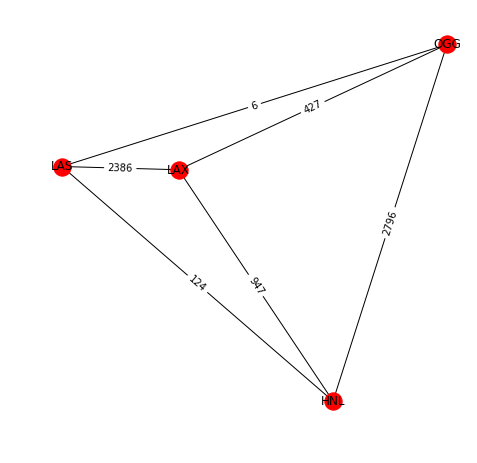

In [353]:
fun_1_draw_network_attr(G_und.subgraph(nodes_list),nodes_attr=None,edges_attr='TotalNumberinRange',size=6,with_pos=False)

In [386]:
# Demo 5 180k data 71 seconds
years = [2007,2008]
sample_airports = ['OGG','LAX','LAS','HNL']
pre_data_5,G_all_5,airports_5,data_G_all_5,data_error_5=fun_2_pre_data_gen(years = years,sample_airports = sample_airports )
G=G_all_5
pre_data=pre_data_5

+++++++++++++++++++sample airports has set: 37.66239547729492  +++++++++++++++++++++++++++++++++++++++++
number of data: 139134
number of data after drop cancelled: 137319
number of data after drop no ArrTime: 137273
number of data after drop no AirTime: 137258
number of data after drop one way trips: 137258
modify all numerical data to be integer
+++++++++++++++++++data has been simplified: 38.06132960319519  +++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++generating deault pre_data: 38.21295952796936  +++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++  ts pre gen is half way: 8.756633043289185  ++++++++++++++++++++++++
++++++++++++++++++++++++  ts pre gen is almost done : 19.8423011302948  ++++++++++++++++++++++++
+++++++++++++++++++pre_data has generated : 58.065197229385376 +++++++++++++++++++++++++++++++++++++++++
data with wrong abs time:  30 and error ratio: 0.021865889212827987
         Year  Month  DayofMonth  DepTime  ArrTime  ArrDelay  DepDelay O

In [387]:
# Demo 5 continued fun_1_nework_build_with_pre_data is extremly slow
airport='LAS'
grid=pd.date_range('2007-01-01 00:00:00','2008-12-30 00:00:00',freq='h',tz=timezone('America/Los_Angeles'))
dt=timedelta(seconds=3600)
st_abstime_str = '2007-08-01 00:00:00'
end_abstime_str = '2007-09-01 00:00:00'

#add totalnumber and delay number between st_abstime and end_abstime for each edge
#fun_1_nework_build_with_pre_data(st_abstime_str = st_abstime_str,end_abstime_str = end_abstime_str,pre_data = pre_data, G = G)
G_und=fun_1_to_undir_G(G)
fun_1_delay_rate(airport,grid=grid,dt=dt,pre_data=pre_data,G=G).head()

loading finished: 0.0
AbsDepTime columnn generated: 0.48200130462646484
AbsArrTime columnn generated: 1.0168168544769287
data concated: 1.031778335571289
fun_1_ts_gen ended: 1.031778335571289


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


,TotalFlights,DelayFlights,DelayRatio
2007-01-01 00:00:00-08:00,0,0,NaN
2007-01-01 01:00:00-08:00,0,0,NaN
2007-01-01 02:00:00-08:00,1,0,0.0
2007-01-01 03:00:00-08:00,0,0,NaN
2007-01-01 04:00:00-08:00,0,0,NaN


In [388]:
fun25_export_data_sets(grid,dt,G,pre_data)

=========Testing  HNL ==========airports remains : 4 ========time lasted so far:  0.0
loading finished: 0.0
AbsDepTime columnn generated: 0.48969078063964844
AbsArrTime columnn generated: 1.016056776046753
data concated: 1.0472590923309326
fun_1_ts_gen ended: 1.0472590923309326


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LAS ==========airports remains : 3 ========time lasted so far:  9.64563274383545
loading finished: 0.0
AbsDepTime columnn generated: 0.46774935722351074
AbsArrTime columnn generated: 0.9564735889434814
data concated: 0.969407320022583
fun_1_ts_gen ended: 0.969407320022583


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LAX ==========airports remains : 2 ========time lasted so far:  17.616421222686768
loading finished: 0.0
AbsDepTime columnn generated: 0.5205597877502441
AbsArrTime columnn generated: 0.9873919486999512
data concated: 1.003014326095581
fun_1_ts_gen ended: 1.003014326095581


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OGG ==========airports remains : 1 ========time lasted so far:  27.6803035736084
loading finished: 0.0
AbsDepTime columnn generated: 0.5508968830108643
AbsArrTime columnn generated: 1.0784542560577393
data concated: 1.094412088394165
fun_1_ts_gen ended: 1.094412088394165


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


======================Total time: 35.948527336120605
=========Testing  HNL ==========airports remains : 4 ========time lasted so far:  0.0
loading finished: 0.0
AbsDepTime columnn generated: 0.5136215686798096
AbsArrTime columnn generated: 0.9983170032501221
data concated: 1.0162711143493652
fun_1_ts_gen ended: 1.0162711143493652


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LAS ==========airports remains : 3 ========time lasted so far:  9.536739826202393
loading finished: 0.0
AbsDepTime columnn generated: 0.5246062278747559
AbsArrTime columnn generated: 1.001291036605835
data concated: 1.013258934020996
fun_1_ts_gen ended: 1.013258934020996


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  LAX ==========airports remains : 2 ========time lasted so far:  17.76590394973755
loading finished: 0.0
AbsDepTime columnn generated: 0.5331563949584961
AbsArrTime columnn generated: 1.0677266120910645
data concated: 1.0906641483306885
fun_1_ts_gen ended: 1.0906641483306885


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


=========Testing  OGG ==========airports remains : 1 ========time lasted so far:  28.394811630249023
loading finished: 0.0
AbsDepTime columnn generated: 0.4707508087158203
AbsArrTime columnn generated: 1.062157392501831
data concated: 1.0761215686798096
fun_1_ts_gen ended: 1.0761215686798096


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in longlong_scalars


======================Total time: 36.43378400802612


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:326: RuntimeWarning: invalid value encountered in true_divide


In [389]:
pre_data.head()

,Year,Month,DayofMonth,DepTime,ArrTime,ArrDelay,DepDelay,Origin,Dest,AirTime,TaxiIn,TaxiOut,AbsDepTime,AbsArrTime
1391,2007,1,2,1902,2007,2,2,LAS,LAX,38,7,20,2007-01-02 19:02:00-08:00,2007-01-02 20:07:00-08:00
1392,2007,1,2,611,703,-7,1,LAS,LAX,37,4,11,2007-01-02 06:11:00-08:00,2007-01-02 07:03:00-08:00
1393,2007,1,2,1547,1647,17,22,LAS,LAX,39,8,13,2007-01-02 15:47:00-08:00,2007-01-02 16:47:00-08:00
1394,2007,1,2,714,808,-7,-1,LAS,LAX,40,4,10,2007-01-02 07:14:00-08:00,2007-01-02 08:08:00-08:00
1395,2007,1,2,826,921,-14,-4,LAS,LAX,40,6,9,2007-01-02 08:26:00-08:00,2007-01-02 09:21:00-08:00


In [400]:
pd.read_csv('graph_edges.csv',index_col=0)

,source,target,weight,Distance,RelTime
0,HNL,LAS,1447,2762,0 days 00:00:00.000000000
1,HNL,LAX,9929,2556,0 days 02:00:00.000000000
2,HNL,OGG,27489,100,0 days 00:00:00.000000000
3,LAS,HNL,1440,2762,0 days 00:00:00.000000000
4,LAS,LAX,25086,236,0 days 00:00:00.000000000
5,LAS,OGG,96,2695,-1 days +22:00:00.000000000
6,LAX,HNL,9939,2556,-1 days +22:00:00.000000000
7,LAX,LAS,25680,236,0 days 00:00:00.000000000
8,LAX,OGG,4003,2486,-1 days +22:00:00.000000000
9,OGG,HNL,28057,100,0 days 00:00:00.000000000


In [395]:
pd.read_csv('graph_nodes.csv',index_col=0)

,pos,time_zone
HNL,"(-157.92240719999998, 21.31869111)",Pacific/Honolulu
LAS,"(-115.15233329999998, 36.08036111)",America/Los_Angeles
LAX,"(-118.40807439999999, 33.94253611)",America/Los_Angeles
OGG,"(-156.43045780000003, 20.89864972)",Pacific/Honolulu


C:\Users\guoji\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


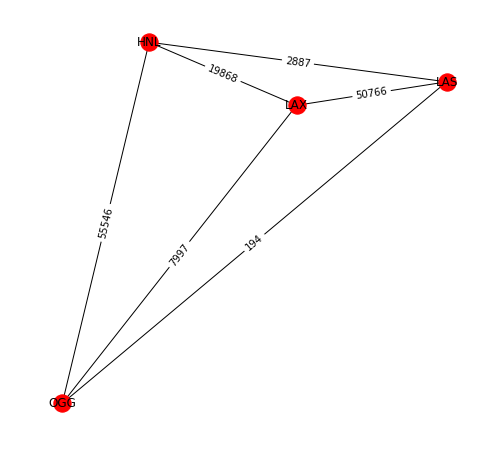

In [383]:
fun_1_draw_network_attr(G_und,nodes_attr=None,edges_attr='weight',size=6,with_pos=False)

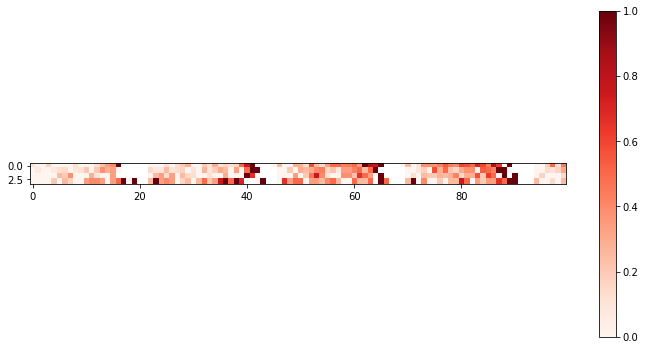

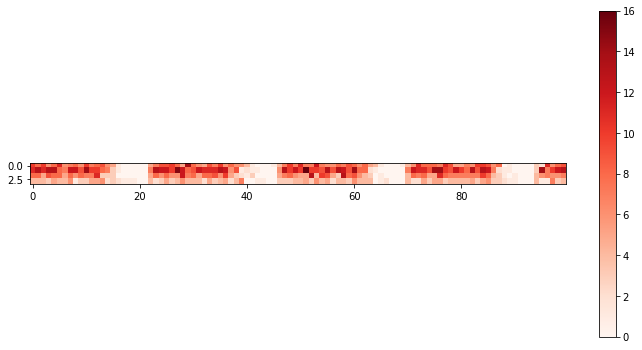

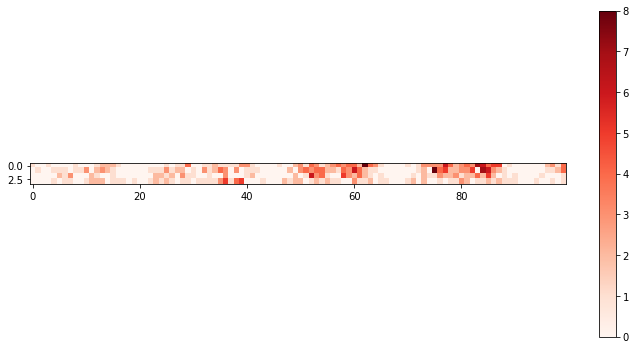

In [308]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

sample_airports=range(4)
sample_times=[str(x) for x in range(200,300)]
sample_DelayRatio=DelayRatio.loc[sample_airports,sample_times]
sample_TotalFlights=TotalFlights.loc[sample_airports,sample_times]
sample_DelayFlights=DelayFlights.loc[sample_airports,sample_times]


plt.imshow(sample_DelayRatio)
plt.set_cmap('Reds')
plt.colorbar()
plt.show()

plt.imshow(sample_TotalFlights)
plt.set_cmap('Reds')
plt.colorbar()
plt.show()


plt.imshow(sample_DelayFlights)
plt.set_cmap('Reds')
plt.colorbar()
plt.show()